# 安装依赖

- https://github.com/milesial/Pytorch-UNet/tree/master
- https://github.com/njcronin/DL_Track
- https://github.com/njcronin/DL_Track/blob/master/Labelling_Instructions.pdf

In [1]:
!pip install scipy scikit-image torch torchvision pathlib wandb segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=e2aa436f589795b6e6164dc22e8fcc24c814454af4297a1c1b52f08e6218a3d7
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=ef4fdcbcae50b7a9819749490d67fb647a7868440f97acbf62356e1f216e01b6
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


# 引用依赖包

In [2]:
%config Completer.use_jedi = False

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import models
from torchvision.transforms import v2
from torch.nn.functional import relu, pad
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image
from typing import Tuple
from pathlib import Path

import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import wandb
import logging

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

## U-Net 网络

In [4]:

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(DoubleConv,self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size=3, dropout = 0.1):
        super(Down, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels, kernel_size)
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout2d(p=dropout),
        )

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_output = self.maxpool_conv(skip_out)
        return (down_output, skip_out)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size = 2, dropout = 0.1, stride = 2):
        super().__init__()
        
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride)
        
        self.conv = nn.Sequential(
            nn.Dropout2d(p=dropout),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x1, x2):
        x = self.up(x1)
        x = torch.cat([x, x2], dim = 1)
        return self.conv(x)
    

sigmoid = nn.Sigmoid()
if torch.cuda.is_available():
    sigmoid = sigmoid.cuda()

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, n_filters = 64, bilinear=False):
        super(UNet, self).__init__()
        self.n_classes = n_classes
        self.n_channels = n_channels
        kernel_size = 3
        dropout = 0.25

        self.down1 = Down(n_channels, n_filters, kernel_size, dropout)
        self.down2 = Down(n_filters, n_filters * 2, kernel_size, dropout)
        self.down3 = Down(n_filters * 2, n_filters * 4, kernel_size, dropout)
        self.down4 = Down(n_filters * 4, n_filters * 8, kernel_size, dropout)
        
        self.bottle_conv = DoubleConv(n_filters * 8, n_filters * 16, kernel_size)
        
        kernel_size = kernel_size - 1
        self.up4 = Up(n_filters * 16, n_filters * 8, kernel_size, dropout)
        self.up3 = Up(n_filters * 8, n_filters * 4, kernel_size, dropout)
        self.up2 = Up(n_filters * 4, n_filters * 2, kernel_size, dropout)
        self.up1 = Up(n_filters * 2, n_filters, kernel_size, dropout)
        
        self.outc = nn.Conv2d(n_filters, n_classes, kernel_size=1)
        

    def forward(self, x):
        
        x, skip1 = self.down1(x)
        x, skip2 = self.down2(x)
        x, skip3 = self.down3(x)
        x, skip4 = self.down4(x)
        
        x = self.bottle_conv(x)
        
        x = self.up4(x, skip4)
        x = self.up3(x, skip3)
        x = self.up2(x, skip2)
        x = self.up1(x, skip1)
        
        out = self.outc(x)
        if not self.training:
            out = sigmoid(out)
            out = torch.where(out>0.5,torch.ones_like(out),torch.zeros_like(out))
        return out

    def use_checkpointing(self):
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.bottle_conv = torch.utils.checkpoint(self.bottle_conv)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

# 定义数据集加载器

In [5]:
# TODO: image和mask名称不一样时跳过
class APODataSet(Dataset):
    # 格式不对的异常数据
    invalid_img = [10, 184, 185]
    def __init__(self, img_dir, mask_dir: str, size) -> None:
        # 获取所有图片路径
        self.img_paths = list(Path(img_dir).glob("*"))
        self.mask_paths = list(Path(mask_dir).glob("*"))
        for idx in self.invalid_img:
            del self.img_paths[idx]
            del self.mask_paths[idx]
        
        
        # 设置 transforms
        self.transform = v2.Compose([     v2.Resize(size), 
                                             v2.RandomHorizontalFlip(),  # 随机水平翻转
                                             v2.RandomVerticalFlip(),    # 随机垂直旋转
                                             #v2.RandomRotation(10) ,     # 随机旋转 （-10,10）度
                                             v2.ToImageTensor(), v2.ConvertImageDtype()])
#         self.transform = transforms.Compose([transforms.PILToTensor()])

    # 使用函数加载原始图像
    def load_orig_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.img_paths[index]
        return Image.open(image_path).copy()
    
    # 使用函数加载tmask图像
    def load_mask_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.mask_paths[index]
        return Image.open(image_path).copy()

    #  重写 __len__() 方法 (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.img_paths)

    # 重写 __getitem__() 方法 (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        "Returns one sample of data, image and mask (X, y)."
        orig_img = self.load_orig_image(index)
        mask_img = self.load_mask_image(index)
        
        seed = np.random.randint(2147483647)
        torch.manual_seed(seed)   # 指定同样的随机种子，以保证图片和label的旋转（水平、垂直和rotation）一致
        orig_img = self.transform(orig_img)
        torch.manual_seed(seed)  # 指定同样的随机种子，以保证图片和label的旋转（水平、垂直和rotation）一致
        mask_img = self.transform(mask_img)
        
        mask_img = torch.where(mask_img>0.5,torch.ones_like(mask_img),torch.zeros_like(mask_img))
        return orig_img, mask_img


# 加载数据集

In [6]:
dataset =  APODataSet(img_dir = "/kaggle/input/dltrack/apo_images",
                      mask_dir = "/kaggle/input/dltrack/apo_masks",
                     size = [512, 512])

total = len(dataset)
train_size = int(0.8*total)
validate_size = total - train_size
train_data, validate_data = random_split(dataset, [train_size, validate_size])
print("dataset info\ntotal: {}, train_size: {}, validate_size: {}".format(total, len(train_data), len(validate_data)))

trainloader = DataLoader(dataset=train_data,
                                     batch_size=2,
                                     num_workers=0,
                                     shuffle=True)

valloader = DataLoader(dataset=validate_data,
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False)

dataset info
total: 571, train_size: 456, validate_size: 115


## 检查异常图片
要把找到的异常数据去除

In [7]:
for index in range(len(dataset)):
    orig_img, mask_img = dataset[index]
    if orig_img.size()[0] != 3:
        print("{}: orig_img size: {}".format(index,orig_img.size()))
print("[done]")

[done]


### 随机显示一张原始图片和其对应的标记图片

torch.Size([3, 512, 512])
torch.Size([1, 512, 512])
showing image of 533: 


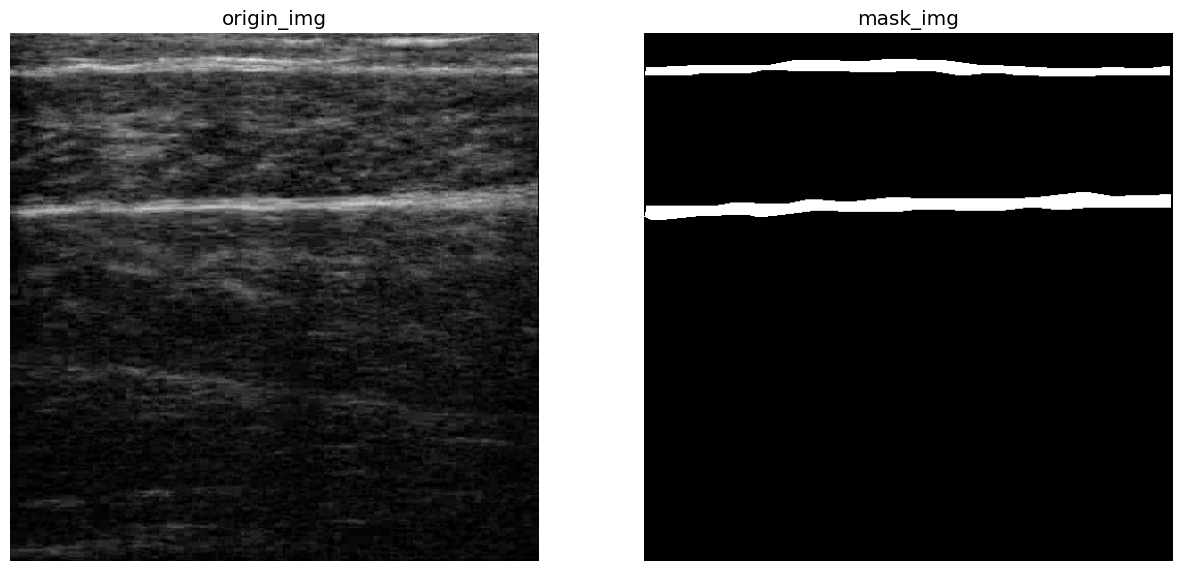

In [8]:
idx = random.randint(0, len(dataset))
orig_img, mask_img = dataset[idx]

print(orig_img.size())
print(mask_img.size())


print("showing image of {}: ".format(idx))

orig_img = orig_img.cpu().numpy().transpose(1, 2, 0)
mask_img = mask_img.cpu().numpy().transpose(1, 2, 0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))

ax1.imshow(orig_img)
ax1.grid(False)
ax1.axis('off')
ax1.set_title("origin_img")

ax2.imshow(mask_img, cmap="gray")
ax2.grid(False)
ax2.axis('off')
ax2.set_title("mask_img")

plt.show()

# 训练网络

In [9]:
os.environ['WANDB_API_KEY']='d561f1229ba7c4e207ca34042f29a43552a7447e'
!wandb login

# (Initialize logging)
experiment = wandb.init(project='U-Net', resume='allow', anonymous='must', notes='对数据进行水平和垂直翻转，无旋转')
experiment.config.update(
    dict(epochs=100, batch_size=2, amp=True)
)

wandb: Currently logged in as: torwayland (cupes-wangtao). Use `wandb login --relogin` to force relogin


wandb: Currently logged in as: torwayland (cupes-wangtao). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.5
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240121_112601-bmnui688
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run giddy-serenity-78
wandb: ⭐️ View project at https://wandb.ai/cupes-wangtao/U-Net
wandb: 🚀 View run at https://wandb.ai/cupes-wangtao/U-Net/runs/bmnui688


In [10]:

@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0
    iou_score = 0

    if isinstance(model, nn.DataParallel):
        n_classes = net.module.n_classes
    else:
        n_classes = net.n_classes
    criterion = nn.BCEWithLogitsLoss()
    dice_loss = smp.losses.DiceLoss(mode='binary')
    
    if torch.cuda.is_available():
        criterion = criterion.cuda()
        dice_loss = dice_loss.cuda()
        
    
    print("Validation round")
    # iterate over the validation set
#     with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
    for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', position=0 ,leave=True):
        images, mask_trues = batch

         # move images and labels to correct device and type
        images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
        mask_trues = mask_trues.to(device=device, dtype=torch.float32)

        # predict the mask
        mask_preds = net(images)
        dice_score += criterion(mask_preds, mask_trues.float())
        dice_score += dice_loss(mask_preds, mask_trues)
            
        tp, fp, fn, tn = smp.metrics.get_stats(mask_preds, mask_trues.long(), mode='binary', threshold=0.5)
        iou_score += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    
    dice_loss = (dice_score / max(num_val_batches, 1))
    iou_score = (iou_score / max(num_val_batches, 1))
    print("Validation dice loss: {}, IoU Score {}".format(dice_loss, iou_score))
    
    try:
        histograms = {}
        for tag, value in net.named_parameters():
            tag = tag.replace('/', '.')
            if not (torch.isinf(value) | torch.isnan(value)).any():
                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

        experiment.log({
            'validation Dice Loss': dice_loss,
            'validation IoU Score': iou_score,
            'images': wandb.Image(images[0].cpu()),
            'masks': {
                'true': wandb.Image(mask_trues[0].float().cpu()),
                'pred': wandb.Image(mask_preds[0].float().cpu()),
            },
            **histograms
        })
    except Exception as e:
        print(e)
#         pass
    
    return (dice_loss, iou_score)

## 设置wandb账号
用作统计与数据分析

In [11]:
import time
import torch.optim as optim
import segmentation_models_pytorch as smp

n_train = len(train_data)
n_val = len(validate_data)


def train(model, device, 
          epochs: int = 100,
          learning_rate: float = 1e-5, 
          weight_decay: float = 1e-8,
          momentum: float = 0.999,
          batch_size: int = 2,
          amp: bool = False,
          gradient_clipping: float = 1.0):
    if isinstance(model, nn.DataParallel):
        n_classes = model.module.n_classes
        n_channels = model.module.n_channels
    else:
        n_classes = model.n_classes
        n_channels = model.n_channels

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Device:          {device.type}
        Mixed Precision: {amp}
    ''')

     # Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#     optimizer = optim.RMSprop(model.parameters(),
#                               lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)  # goal: maximize Dice scor
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    
    criterion = nn.BCEWithLogitsLoss().cuda()
    dice_loss = smp.losses.DiceLoss(mode='binary').cuda()

    global_step = 0
    
#     iou_metric = IoU

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in trainloader:
                images, true_masks = batch

                assert images.shape[1] == n_channels, \
                    f'Network has been defined with {n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    loss = criterion(masks_pred, true_masks.float())
                    loss += dice_loss(masks_pred, true_masks)
                    tp, fp, fn, tn = smp.metrics.get_stats(masks_pred, true_masks.long(), mode='binary', threshold=0.5)
                    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    
                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train iou': iou_score,
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (20 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        val_score, iou_score = evaluate(model, valloader, device, amp)
                        
                        model.train()
                        scheduler.step(val_score)
    experiment.finish()

if __name__ == '__main__':
    model = UNet(n_channels=3, n_classes=1, bilinear=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)

    model = model.to(memory_format=torch.channels_last)
    model.to(device)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"模型参数量为：{total_params}")
    print("其详情为：")
    for name,parameters in model.named_parameters():
        print(name,':',parameters.size())
    train(model, device)

    

Let's use 2 GPUs!
模型参数量为：31043521
其详情为：
module.down1.double_conv.double_conv.0.weight : torch.Size([64, 3, 3, 3])
module.down1.double_conv.double_conv.0.bias : torch.Size([64])
module.down1.double_conv.double_conv.1.weight : torch.Size([64])
module.down1.double_conv.double_conv.1.bias : torch.Size([64])
module.down1.double_conv.double_conv.3.weight : torch.Size([64, 64, 3, 3])
module.down1.double_conv.double_conv.3.bias : torch.Size([64])
module.down1.double_conv.double_conv.4.weight : torch.Size([64])
module.down1.double_conv.double_conv.4.bias : torch.Size([64])
module.down2.double_conv.double_conv.0.weight : torch.Size([128, 64, 3, 3])
module.down2.double_conv.double_conv.0.bias : torch.Size([128])
module.down2.double_conv.double_conv.1.weight : torch.Size([128])
module.down2.double_conv.double_conv.1.bias : torch.Size([128])
module.down2.double_conv.double_conv.3.weight : torch.Size([128, 128, 3, 3])
module.down2.double_conv.double_conv.3.bias : torch.Size([128])
module.down2.doubl

Epoch 1/100:   5%|▍         | 22/456 [00:05<01:13,  5.94img/s, loss (batch)=1.45]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.26batch/s]


Validation dice loss: 1.6260592937469482, IoU Score 0.0


Epoch 1/100:  10%|▉         | 44/456 [00:23<01:31,  4.51img/s, loss (batch)=1.39]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.25batch/s]


Validation dice loss: 1.625990867614746, IoU Score 0.00709168054163456


Epoch 1/100:  14%|█▍        | 66/456 [00:40<01:28,  4.42img/s, loss (batch)=1.42]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.34batch/s]


Validation dice loss: 1.6192586421966553, IoU Score 0.2978091239929199


Epoch 1/100:  19%|█▉        | 88/456 [00:58<01:26,  4.26img/s, loss (batch)=1.32]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.26batch/s]


Validation dice loss: 1.6297823190689087, IoU Score 0.31450340151786804


Epoch 1/100:  24%|██▍       | 110/456 [01:15<01:18,  4.43img/s, loss (batch)=1.3] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.6394909620285034, IoU Score 0.2877127230167389


Epoch 1/100:  29%|██▉       | 132/456 [01:33<01:13,  4.42img/s, loss (batch)=1.22]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6476545333862305, IoU Score 0.26646777987480164


Epoch 1/100:  34%|███▍      | 154/456 [01:50<01:08,  4.39img/s, loss (batch)=1.37]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.645119309425354, IoU Score 0.2741072475910187


Epoch 1/100:  39%|███▊      | 176/456 [02:08<01:04,  4.33img/s, loss (batch)=1.3]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6439539194107056, IoU Score 0.27810949087142944


Epoch 1/100:  43%|████▎     | 198/456 [02:26<00:59,  4.34img/s, loss (batch)=1.26]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 1.6383521556854248, IoU Score 0.29324647784233093


Epoch 1/100:  48%|████▊     | 220/456 [02:45<00:54,  4.31img/s, loss (batch)=1.25]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6389976739883423, IoU Score 0.2896236777305603


Epoch 1/100:  53%|█████▎    | 242/456 [03:02<00:48,  4.37img/s, loss (batch)=1.12]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.612306833267212, IoU Score 0.417671263217926


Epoch 1/100:  58%|█████▊    | 264/456 [03:20<00:43,  4.36img/s, loss (batch)=1.15]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.6068739891052246, IoU Score 0.46781444549560547


Epoch 1/100:  63%|██████▎   | 286/456 [03:38<00:39,  4.26img/s, loss (batch)=1.35]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6072839498519897, IoU Score 0.46441516280174255


Epoch 1/100:  68%|██████▊   | 308/456 [03:56<00:34,  4.35img/s, loss (batch)=1.16]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6168662309646606, IoU Score 0.39346063137054443


Epoch 1/100:  72%|███████▏  | 330/456 [04:14<00:29,  4.32img/s, loss (batch)=1.13]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6058109998703003, IoU Score 0.4875446557998657


Epoch 1/100:  77%|███████▋  | 352/456 [04:32<00:23,  4.35img/s, loss (batch)=1.2] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.621449589729309, IoU Score 0.37267276644706726


Epoch 1/100:  82%|████████▏ | 374/456 [04:50<00:18,  4.40img/s, loss (batch)=1.1] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6121940612792969, IoU Score 0.4273325204849243


Epoch 1/100:  87%|████████▋ | 396/456 [05:08<00:14,  4.21img/s, loss (batch)=1.08]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6062076091766357, IoU Score 0.45484450459480286


Epoch 1/100:  92%|█████████▏| 418/456 [05:26<00:08,  4.30img/s, loss (batch)=1.22]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6087034940719604, IoU Score 0.4577266275882721


Epoch 1/100:  96%|█████████▋| 440/456 [05:44<00:03,  4.35img/s, loss (batch)=1.08]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6052652597427368, IoU Score 0.48767754435539246


Epoch 2/100:   1%|▏         | 6/456 [00:01<01:17,  5.83img/s, loss (batch)=1.18]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.6051974296569824, IoU Score 0.49281084537506104


Epoch 2/100:   6%|▌         | 28/456 [00:19<01:38,  4.34img/s, loss (batch)=1.09]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.606911063194275, IoU Score 0.4534068703651428


Epoch 2/100:  11%|█         | 50/456 [00:37<01:33,  4.34img/s, loss (batch)=1.11]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6061227321624756, IoU Score 0.4879082143306732


Epoch 2/100:  16%|█▌        | 72/456 [00:54<01:27,  4.36img/s, loss (batch)=1.06]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6057757139205933, IoU Score 0.4961397051811218


Epoch 2/100:  21%|██        | 94/456 [01:12<01:23,  4.32img/s, loss (batch)=1.12] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6030867099761963, IoU Score 0.5304433703422546


Epoch 2/100:  25%|██▌       | 116/456 [01:30<01:17,  4.36img/s, loss (batch)=1.05]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.605570673942566, IoU Score 0.4997907876968384


Epoch 2/100:  30%|███       | 138/456 [01:48<01:13,  4.35img/s, loss (batch)=0.999]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6037864685058594, IoU Score 0.5187997221946716


Epoch 2/100:  35%|███▌      | 160/456 [02:06<01:08,  4.30img/s, loss (batch)=1.07]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6044716835021973, IoU Score 0.5016706585884094


Epoch 2/100:  40%|███▉      | 182/456 [02:24<01:03,  4.32img/s, loss (batch)=1.05]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6069986820220947, IoU Score 0.4820403456687927


Epoch 2/100:  45%|████▍     | 204/456 [02:41<00:57,  4.38img/s, loss (batch)=1.08]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6024848222732544, IoU Score 0.5351359844207764


Epoch 2/100:  50%|████▉     | 226/456 [02:59<00:52,  4.37img/s, loss (batch)=1.04]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6034859418869019, IoU Score 0.5230758190155029


Epoch 2/100:  54%|█████▍    | 248/456 [03:17<00:48,  4.31img/s, loss (batch)=1.14] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.603990077972412, IoU Score 0.5205110907554626


Epoch 2/100:  59%|█████▉    | 270/456 [03:35<00:43,  4.31img/s, loss (batch)=1.13] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6023626327514648, IoU Score 0.5370742678642273


Epoch 2/100:  64%|██████▍   | 292/456 [03:53<00:37,  4.35img/s, loss (batch)=1.09] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6039499044418335, IoU Score 0.5193637609481812


Epoch 2/100:  69%|██████▉   | 314/456 [04:11<00:32,  4.37img/s, loss (batch)=1]   

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6035276651382446, IoU Score 0.5211535096168518


Epoch 2/100:  74%|███████▎  | 336/456 [04:28<00:27,  4.37img/s, loss (batch)=1.05]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6046921014785767, IoU Score 0.5104399919509888


Epoch 2/100:  79%|███████▊  | 358/456 [04:46<00:22,  4.33img/s, loss (batch)=1.13] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6022847890853882, IoU Score 0.5453822612762451


Epoch 2/100:  83%|████████▎ | 380/456 [05:04<00:17,  4.36img/s, loss (batch)=1.02]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6065508127212524, IoU Score 0.49318599700927734


Epoch 2/100:  88%|████████▊ | 402/456 [05:22<00:12,  4.27img/s, loss (batch)=1.11]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6045159101486206, IoU Score 0.5167465806007385


Epoch 2/100:  93%|█████████▎| 424/456 [05:40<00:07,  4.38img/s, loss (batch)=0.915]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6050012111663818, IoU Score 0.5042296051979065


Epoch 2/100:  98%|█████████▊| 446/456 [05:58<00:02,  4.38img/s, loss (batch)=0.931]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.604387879371643, IoU Score 0.5150403380393982


Epoch 3/100:   3%|▎         | 12/456 [00:02<01:16,  5.82img/s, loss (batch)=1.1] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6025471687316895, IoU Score 0.5399909019470215


Epoch 3/100:   7%|▋         | 34/456 [00:19<01:36,  4.38img/s, loss (batch)=1.22]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6061265468597412, IoU Score 0.5016098022460938


Epoch 3/100:  12%|█▏        | 56/456 [00:37<01:31,  4.38img/s, loss (batch)=1.07] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.602799415588379, IoU Score 0.5418449640274048


Epoch 3/100:  17%|█▋        | 78/456 [00:55<01:27,  4.31img/s, loss (batch)=1.05]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6044985055923462, IoU Score 0.5178964138031006


Epoch 3/100:  22%|██▏       | 100/456 [01:13<01:21,  4.36img/s, loss (batch)=1.01]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6018145084381104, IoU Score 0.5522836446762085


Epoch 3/100:  27%|██▋       | 122/456 [01:30<01:16,  4.36img/s, loss (batch)=1.15]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6015498638153076, IoU Score 0.553117573261261


Epoch 3/100:  32%|███▏      | 144/456 [01:48<01:11,  4.37img/s, loss (batch)=0.943]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.602403998374939, IoU Score 0.5444374084472656


Epoch 3/100:  36%|███▋      | 166/456 [02:06<01:06,  4.37img/s, loss (batch)=1.06]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6067866086959839, IoU Score 0.4935087561607361


Epoch 3/100:  41%|████      | 188/456 [02:24<01:01,  4.33img/s, loss (batch)=0.987]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6023460626602173, IoU Score 0.5497896671295166


Epoch 3/100:  46%|████▌     | 210/456 [02:42<00:56,  4.35img/s, loss (batch)=1.04] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6017701625823975, IoU Score 0.5587301850318909


Epoch 3/100:  51%|█████     | 232/456 [02:59<00:51,  4.35img/s, loss (batch)=1.03] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6068754196166992, IoU Score 0.49003204703330994


Epoch 3/100:  56%|█████▌    | 254/456 [03:17<00:47,  4.26img/s, loss (batch)=0.944]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6017322540283203, IoU Score 0.5560327172279358


Epoch 3/100:  61%|██████    | 276/456 [03:35<00:41,  4.36img/s, loss (batch)=1.03] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6020008325576782, IoU Score 0.5537728667259216


Epoch 3/100:  65%|██████▌   | 298/456 [03:53<00:36,  4.30img/s, loss (batch)=1.09]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6022084951400757, IoU Score 0.5474745035171509


Epoch 3/100:  70%|███████   | 320/456 [04:11<00:30,  4.43img/s, loss (batch)=0.917]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6015727519989014, IoU Score 0.5598053932189941


Epoch 3/100:  75%|███████▌  | 342/456 [04:28<00:26,  4.33img/s, loss (batch)=0.973]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6056647300720215, IoU Score 0.49391257762908936


Epoch 3/100:  80%|███████▉  | 364/456 [04:46<00:22,  4.13img/s, loss (batch)=0.936]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6024339199066162, IoU Score 0.5476362109184265


Epoch 3/100:  85%|████████▍ | 386/456 [05:04<00:16,  4.33img/s, loss (batch)=1]   

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6016710996627808, IoU Score 0.5592944622039795


Epoch 3/100:  89%|████████▉ | 408/456 [05:22<00:10,  4.39img/s, loss (batch)=0.962]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.601477861404419, IoU Score 0.5616251230239868


Epoch 3/100:  94%|█████████▍| 430/456 [05:40<00:06,  4.32img/s, loss (batch)=1.02] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6023499965667725, IoU Score 0.5467857718467712


Epoch 3/100:  99%|█████████▉| 452/456 [05:58<00:00,  4.33img/s, loss (batch)=1.13]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6017857789993286, IoU Score 0.5543144345283508


Epoch 4/100:   4%|▍         | 18/456 [00:03<01:16,  5.76img/s, loss (batch)=0.957]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.602452039718628, IoU Score 0.5465040802955627


Epoch 4/100:   9%|▉         | 40/456 [00:21<01:36,  4.30img/s, loss (batch)=1.11] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6021194458007812, IoU Score 0.5514911413192749


Epoch 4/100:  14%|█▎        | 62/456 [00:38<01:31,  4.29img/s, loss (batch)=1.04] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6022061109542847, IoU Score 0.5514224767684937


Epoch 4/100:  18%|█▊        | 84/456 [00:56<01:26,  4.32img/s, loss (batch)=0.952]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6022446155548096, IoU Score 0.5446762442588806


Epoch 4/100:  23%|██▎       | 106/456 [01:14<01:19,  4.40img/s, loss (batch)=0.886]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6007977724075317, IoU Score 0.5766503214836121


Epoch 4/100:  28%|██▊       | 128/456 [01:32<01:15,  4.36img/s, loss (batch)=0.976]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6017544269561768, IoU Score 0.562364399433136


Epoch 4/100:  33%|███▎      | 150/456 [01:50<01:10,  4.37img/s, loss (batch)=0.908]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6023589372634888, IoU Score 0.5495756268501282


Epoch 4/100:  38%|███▊      | 172/456 [02:08<01:06,  4.29img/s, loss (batch)=1.03] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.60207998752594, IoU Score 0.5510838627815247


Epoch 4/100:  43%|████▎     | 194/456 [02:26<00:59,  4.38img/s, loss (batch)=0.858]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6027357578277588, IoU Score 0.5467635989189148


Epoch 4/100:  47%|████▋     | 216/456 [02:43<00:55,  4.35img/s, loss (batch)=0.969]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6017885208129883, IoU Score 0.5635817050933838


Epoch 4/100:  52%|█████▏    | 238/456 [03:01<00:50,  4.29img/s, loss (batch)=1]    

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6034409999847412, IoU Score 0.5350737571716309


Epoch 4/100:  57%|█████▋    | 260/456 [03:19<00:45,  4.32img/s, loss (batch)=0.987]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6021804809570312, IoU Score 0.5498046875


Epoch 4/100:  62%|██████▏   | 282/456 [03:37<00:40,  4.30img/s, loss (batch)=0.955]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6038705110549927, IoU Score 0.5263471603393555


Epoch 4/100:  67%|██████▋   | 304/456 [03:55<00:34,  4.39img/s, loss (batch)=0.863]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.6018508672714233, IoU Score 0.5567042231559753


Epoch 4/100:  71%|███████▏  | 326/456 [04:13<00:30,  4.33img/s, loss (batch)=1.02]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6025243997573853, IoU Score 0.5469382405281067


Epoch 4/100:  76%|███████▋  | 348/456 [04:31<00:24,  4.38img/s, loss (batch)=0.937]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.601685881614685, IoU Score 0.5618982911109924


Epoch 4/100:  81%|████████  | 370/456 [04:49<00:19,  4.31img/s, loss (batch)=1.07]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6016836166381836, IoU Score 0.5613892078399658


Epoch 4/100:  86%|████████▌ | 392/456 [05:07<00:14,  4.33img/s, loss (batch)=0.974]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6022359132766724, IoU Score 0.5493553876876831


Epoch 4/100:  91%|█████████ | 414/456 [05:24<00:09,  4.31img/s, loss (batch)=0.952]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6018809080123901, IoU Score 0.5588874220848083


Epoch 4/100:  96%|█████████▌| 436/456 [05:42<00:04,  4.38img/s, loss (batch)=0.903]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.602047085762024, IoU Score 0.5557485222816467


Epoch 5/100:   0%|          | 2/456 [00:00<01:17,  5.87img/s, loss (batch)=1.18]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.602800965309143, IoU Score 0.5457280278205872


Epoch 5/100:   5%|▌         | 24/456 [00:18<01:39,  4.34img/s, loss (batch)=0.958]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.601987600326538, IoU Score 0.5568435192108154


Epoch 5/100:  10%|█         | 46/456 [00:36<01:33,  4.37img/s, loss (batch)=0.897]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.601301908493042, IoU Score 0.5669768452644348


Epoch 5/100:  15%|█▍        | 68/456 [00:53<01:28,  4.36img/s, loss (batch)=0.82]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.6016641855239868, IoU Score 0.5606235861778259


Epoch 5/100:  20%|█▉        | 90/456 [01:11<01:25,  4.26img/s, loss (batch)=0.884]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.602597713470459, IoU Score 0.5469852685928345


Epoch 5/100:  25%|██▍       | 112/456 [01:29<01:19,  4.31img/s, loss (batch)=0.906]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6041678190231323, IoU Score 0.5197425484657288


Epoch 5/100:  29%|██▉       | 134/456 [01:47<01:14,  4.33img/s, loss (batch)=0.89]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6027635335922241, IoU Score 0.5435855388641357


Epoch 5/100:  34%|███▍      | 156/456 [02:05<01:08,  4.38img/s, loss (batch)=0.947]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6016263961791992, IoU Score 0.5629224181175232


Epoch 5/100:  39%|███▉      | 178/456 [02:23<01:04,  4.30img/s, loss (batch)=0.952]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6026452779769897, IoU Score 0.5504115223884583


Epoch 5/100:  44%|████▍     | 200/456 [02:41<00:59,  4.34img/s, loss (batch)=0.942]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.602433681488037, IoU Score 0.5520339608192444


Epoch 5/100:  49%|████▊     | 222/456 [02:59<00:54,  4.30img/s, loss (batch)=0.942]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6004647016525269, IoU Score 0.5851192474365234


Epoch 5/100:  54%|█████▎    | 244/456 [03:17<00:48,  4.36img/s, loss (batch)=0.807]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.601272702217102, IoU Score 0.566805899143219


Epoch 5/100:  58%|█████▊    | 266/456 [03:34<00:43,  4.38img/s, loss (batch)=0.88] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6023062467575073, IoU Score 0.5507226586341858


Epoch 5/100:  63%|██████▎   | 288/456 [03:52<00:38,  4.36img/s, loss (batch)=0.831]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6026005744934082, IoU Score 0.5473151206970215


Epoch 5/100:  68%|██████▊   | 310/456 [04:10<00:33,  4.40img/s, loss (batch)=0.903]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6017016172409058, IoU Score 0.5660590529441833


Epoch 5/100:  73%|███████▎  | 332/456 [04:28<00:28,  4.33img/s, loss (batch)=0.84] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6015056371688843, IoU Score 0.5707917809486389


Epoch 5/100:  78%|███████▊  | 354/456 [04:46<00:23,  4.33img/s, loss (batch)=0.869]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6027601957321167, IoU Score 0.5442951321601868


Epoch 5/100:  82%|████████▏ | 376/456 [05:04<00:18,  4.33img/s, loss (batch)=0.942]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.6035009622573853, IoU Score 0.5369884967803955


Epoch 5/100:  87%|████████▋ | 398/456 [05:22<00:13,  4.42img/s, loss (batch)=0.776]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6019024848937988, IoU Score 0.5602787137031555


Epoch 5/100:  92%|█████████▏| 420/456 [05:40<00:08,  4.37img/s, loss (batch)=0.865]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6070141792297363, IoU Score 0.46868568658828735


Epoch 5/100:  97%|█████████▋| 442/456 [05:57<00:03,  4.37img/s, loss (batch)=0.835]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.603838324546814, IoU Score 0.5219664573669434


Epoch 6/100:   2%|▏         | 8/456 [00:01<01:16,  5.87img/s, loss (batch)=1.15] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6019142866134644, IoU Score 0.5569900870323181


Epoch 6/100:   7%|▋         | 30/456 [00:19<01:37,  4.38img/s, loss (batch)=0.891]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6003681421279907, IoU Score 0.5851143598556519


Epoch 6/100:  11%|█▏        | 52/456 [00:37<01:32,  4.38img/s, loss (batch)=0.819]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6010228395462036, IoU Score 0.573310136795044


Epoch 6/100:  16%|█▌        | 74/456 [00:54<01:28,  4.30img/s, loss (batch)=0.904]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6023542881011963, IoU Score 0.5547815561294556


Epoch 6/100:  21%|██        | 96/456 [01:12<01:21,  4.41img/s, loss (batch)=0.811]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6049507856369019, IoU Score 0.5091207027435303


Epoch 6/100:  26%|██▌       | 118/456 [01:30<01:17,  4.38img/s, loss (batch)=0.932]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.600734829902649, IoU Score 0.582391083240509


Epoch 6/100:  31%|███       | 140/456 [01:48<01:11,  4.40img/s, loss (batch)=0.877]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6019237041473389, IoU Score 0.5607244968414307


Epoch 6/100:  36%|███▌      | 162/456 [02:05<01:07,  4.36img/s, loss (batch)=0.795]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.60160493850708, IoU Score 0.5670185089111328


Epoch 6/100:  40%|████      | 184/456 [02:23<01:02,  4.32img/s, loss (batch)=1.28] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.601088523864746, IoU Score 0.5755038261413574


Epoch 6/100:  45%|████▌     | 206/456 [02:41<00:57,  4.32img/s, loss (batch)=0.906]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.60194730758667, IoU Score 0.5587288737297058


Epoch 6/100:  50%|█████     | 228/456 [02:59<00:52,  4.33img/s, loss (batch)=1]    

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6043792963027954, IoU Score 0.5202540159225464


Epoch 6/100:  55%|█████▍    | 250/456 [03:17<00:47,  4.34img/s, loss (batch)=0.79]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6012741327285767, IoU Score 0.5694081783294678


Epoch 6/100:  60%|█████▉    | 272/456 [03:35<00:42,  4.36img/s, loss (batch)=0.928]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.602959394454956, IoU Score 0.538417637348175


Epoch 6/100:  64%|██████▍   | 294/456 [03:53<00:37,  4.27img/s, loss (batch)=0.803]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6023914813995361, IoU Score 0.5535339713096619


Epoch 6/100:  69%|██████▉   | 316/456 [04:10<00:32,  4.35img/s, loss (batch)=0.775]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6024047136306763, IoU Score 0.5565882921218872


Epoch 6/100:  74%|███████▍  | 338/456 [04:28<00:28,  4.19img/s, loss (batch)=0.935]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.6026049852371216, IoU Score 0.5494898557662964


Epoch 6/100:  79%|███████▉  | 360/456 [04:46<00:22,  4.26img/s, loss (batch)=0.85] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6016478538513184, IoU Score 0.5655990242958069


Epoch 6/100:  84%|████████▍ | 382/456 [05:04<00:17,  4.30img/s, loss (batch)=0.962]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6041996479034424, IoU Score 0.5238460898399353


Epoch 6/100:  89%|████████▊ | 404/456 [05:22<00:11,  4.35img/s, loss (batch)=0.904]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6009255647659302, IoU Score 0.5774243474006653


Epoch 6/100:  93%|█████████▎| 426/456 [05:40<00:06,  4.36img/s, loss (batch)=0.816]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6017742156982422, IoU Score 0.5615371465682983


Epoch 6/100:  98%|█████████▊| 448/456 [05:58<00:01,  4.33img/s, loss (batch)=0.855]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6017040014266968, IoU Score 0.5649455785751343


Epoch 7/100:   3%|▎         | 14/456 [00:02<01:15,  5.87img/s, loss (batch)=0.795]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.601496934890747, IoU Score 0.5662624835968018


Epoch 7/100:   8%|▊         | 36/456 [00:20<01:36,  4.34img/s, loss (batch)=1.12] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6040533781051636, IoU Score 0.521731436252594


Epoch 7/100:  13%|█▎        | 58/456 [00:38<01:30,  4.39img/s, loss (batch)=0.849]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.600951910018921, IoU Score 0.5745413899421692


Epoch 7/100:  18%|█▊        | 80/456 [00:55<01:26,  4.32img/s, loss (batch)=0.788]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6022179126739502, IoU Score 0.5594583749771118


Epoch 7/100:  22%|██▏       | 102/456 [01:13<01:21,  4.35img/s, loss (batch)=0.98]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6046141386032104, IoU Score 0.5155254006385803


Epoch 7/100:  27%|██▋       | 124/456 [01:31<01:17,  4.28img/s, loss (batch)=0.936]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6023486852645874, IoU Score 0.551383376121521


Epoch 7/100:  32%|███▏      | 146/456 [01:49<01:11,  4.35img/s, loss (batch)=0.763]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.600651502609253, IoU Score 0.5820457935333252


Epoch 7/100:  37%|███▋      | 168/456 [02:07<01:06,  4.31img/s, loss (batch)=0.83] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6020275354385376, IoU Score 0.5581790208816528


Epoch 7/100:  42%|████▏     | 190/456 [02:25<01:00,  4.39img/s, loss (batch)=0.77] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.6014989614486694, IoU Score 0.5695029497146606


Epoch 7/100:  46%|████▋     | 212/456 [02:43<00:57,  4.28img/s, loss (batch)=0.877]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.601973533630371, IoU Score 0.5589134693145752


Epoch 7/100:  51%|█████▏    | 234/456 [03:01<00:51,  4.31img/s, loss (batch)=0.838]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6037323474884033, IoU Score 0.5234323143959045


Epoch 7/100:  56%|█████▌    | 256/456 [03:19<00:46,  4.26img/s, loss (batch)=0.862]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.6010522842407227, IoU Score 0.5753500461578369


Epoch 7/100:  61%|██████    | 278/456 [03:37<00:41,  4.30img/s, loss (batch)=0.865]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6009342670440674, IoU Score 0.5798210501670837


Epoch 7/100:  66%|██████▌   | 300/456 [03:55<00:35,  4.42img/s, loss (batch)=0.745]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.602151870727539, IoU Score 0.5539712309837341


Epoch 7/100:  71%|███████   | 322/456 [04:13<00:30,  4.36img/s, loss (batch)=0.816]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6026700735092163, IoU Score 0.5489580035209656


Epoch 7/100:  75%|███████▌  | 344/456 [04:31<00:25,  4.41img/s, loss (batch)=0.751]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6009687185287476, IoU Score 0.5786769986152649


Epoch 7/100:  80%|████████  | 366/456 [04:48<00:20,  4.37img/s, loss (batch)=0.824]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6016453504562378, IoU Score 0.5662922263145447


Epoch 7/100:  85%|████████▌ | 388/456 [05:06<00:15,  4.30img/s, loss (batch)=0.695]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.6034575700759888, IoU Score 0.5321820974349976


Epoch 7/100:  90%|████████▉ | 410/456 [05:24<00:10,  4.32img/s, loss (batch)=0.829]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6011403799057007, IoU Score 0.5752829909324646


Epoch 7/100:  95%|█████████▍| 432/456 [05:42<00:05,  4.33img/s, loss (batch)=0.849]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6003605127334595, IoU Score 0.5933533906936646


Epoch 7/100: 100%|█████████▉| 454/456 [06:00<00:00,  4.35img/s, loss (batch)=0.785]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6028696298599243, IoU Score 0.5486422777175903


Epoch 8/100:   4%|▍         | 20/456 [00:03<01:13,  5.89img/s, loss (batch)=0.778]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.603220820426941, IoU Score 0.5377309918403625


Epoch 8/100:   9%|▉         | 42/456 [00:21<01:35,  4.35img/s, loss (batch)=0.843]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6042413711547852, IoU Score 0.5179998874664307


Epoch 8/100:  14%|█▍        | 64/456 [00:39<01:30,  4.35img/s, loss (batch)=0.871]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6034520864486694, IoU Score 0.539908766746521


Epoch 8/100:  19%|█▉        | 86/456 [00:56<01:23,  4.45img/s, loss (batch)=0.726]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6004490852355957, IoU Score 0.5913702845573425


Epoch 8/100:  24%|██▎       | 108/456 [01:14<01:20,  4.32img/s, loss (batch)=0.889]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6024506092071533, IoU Score 0.5515472888946533


Epoch 8/100:  29%|██▊       | 130/456 [01:32<01:15,  4.34img/s, loss (batch)=0.816]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6038813591003418, IoU Score 0.5320554971694946


Epoch 8/100:  33%|███▎      | 152/456 [01:50<01:10,  4.32img/s, loss (batch)=0.739]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6035373210906982, IoU Score 0.5371899604797363


Epoch 8/100:  38%|███▊      | 174/456 [02:08<01:04,  4.34img/s, loss (batch)=0.941]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6018965244293213, IoU Score 0.5668650269508362


Epoch 8/100:  43%|████▎     | 196/456 [02:25<00:59,  4.34img/s, loss (batch)=0.733]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6027189493179321, IoU Score 0.5535270571708679


Epoch 8/100:  48%|████▊     | 218/456 [02:43<00:53,  4.42img/s, loss (batch)=0.74]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6053825616836548, IoU Score 0.5016410946846008


Epoch 8/100:  53%|█████▎    | 240/456 [03:01<00:50,  4.31img/s, loss (batch)=0.989]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6021884679794312, IoU Score 0.5568070411682129


Epoch 8/100:  57%|█████▋    | 262/456 [03:19<00:44,  4.38img/s, loss (batch)=0.769]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6021320819854736, IoU Score 0.5541390776634216


Epoch 8/100:  62%|██████▏   | 284/456 [03:37<00:39,  4.37img/s, loss (batch)=0.787]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6015697717666626, IoU Score 0.5678023099899292


Epoch 8/100:  67%|██████▋   | 306/456 [03:54<00:33,  4.43img/s, loss (batch)=0.654]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6025540828704834, IoU Score 0.5573173761367798


Epoch 8/100:  72%|███████▏  | 328/456 [04:12<00:29,  4.36img/s, loss (batch)=0.751]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6004184484481812, IoU Score 0.5924538373947144


Epoch 8/100:  77%|███████▋  | 350/456 [04:30<00:24,  4.38img/s, loss (batch)=0.779]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6018098592758179, IoU Score 0.5663665533065796


Epoch 8/100:  82%|████████▏ | 372/456 [04:48<00:19,  4.34img/s, loss (batch)=0.891]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.601745843887329, IoU Score 0.5690462589263916


Epoch 8/100:  86%|████████▋ | 394/456 [05:05<00:14,  4.40img/s, loss (batch)=0.743]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6015623807907104, IoU Score 0.571907103061676


Epoch 8/100:  91%|█████████ | 416/456 [05:23<00:08,  4.47img/s, loss (batch)=0.696]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6016104221343994, IoU Score 0.5714015364646912


Epoch 8/100:  96%|█████████▌| 438/456 [05:41<00:04,  4.32img/s, loss (batch)=1]    

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6017922163009644, IoU Score 0.5671179890632629


Epoch 9/100:   1%|          | 4/456 [00:00<01:13,  6.13img/s, loss (batch)=0.794]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.40batch/s]


Validation dice loss: 1.6011937856674194, IoU Score 0.579616129398346


Epoch 9/100:   6%|▌         | 26/456 [00:19<01:45,  4.08img/s, loss (batch)=0.707]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.32batch/s]


Validation dice loss: 1.6017955541610718, IoU Score 0.5681182146072388


Epoch 9/100:  11%|█         | 48/456 [00:38<01:43,  3.94img/s, loss (batch)=0.855]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.38batch/s]


Validation dice loss: 1.6031849384307861, IoU Score 0.5413974523544312


Epoch 9/100:  15%|█▌        | 70/456 [00:57<01:31,  4.23img/s, loss (batch)=0.782]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6020417213439941, IoU Score 0.5601405501365662


Epoch 9/100:  20%|██        | 92/456 [01:15<01:23,  4.35img/s, loss (batch)=0.663]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6013071537017822, IoU Score 0.5789179801940918


Epoch 9/100:  25%|██▌       | 114/456 [01:33<01:18,  4.37img/s, loss (batch)=0.749]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6026556491851807, IoU Score 0.5520194172859192


Epoch 9/100:  30%|██▉       | 136/456 [01:51<01:12,  4.39img/s, loss (batch)=0.807]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6017789840698242, IoU Score 0.5617002844810486


Epoch 9/100:  35%|███▍      | 158/456 [02:08<01:08,  4.37img/s, loss (batch)=0.734]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6007299423217773, IoU Score 0.5836519002914429


Epoch 9/100:  39%|███▉      | 180/456 [02:26<01:02,  4.42img/s, loss (batch)=0.672]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6011853218078613, IoU Score 0.5745735764503479


Epoch 9/100:  44%|████▍     | 202/456 [02:44<00:57,  4.42img/s, loss (batch)=0.673]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6024444103240967, IoU Score 0.5617197155952454


Epoch 9/100:  49%|████▉     | 224/456 [03:02<00:52,  4.38img/s, loss (batch)=0.717]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6014235019683838, IoU Score 0.5726606845855713


Epoch 9/100:  54%|█████▍    | 246/456 [03:20<00:50,  4.19img/s, loss (batch)=0.875]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6018376350402832, IoU Score 0.5663421154022217


Epoch 9/100:  59%|█████▉    | 268/456 [03:38<00:44,  4.26img/s, loss (batch)=0.855]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6083011627197266, IoU Score 0.4425182640552521


Epoch 9/100:  64%|██████▎   | 290/456 [03:56<00:38,  4.30img/s, loss (batch)=0.824]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6015759706497192, IoU Score 0.5756534337997437


Epoch 9/100:  68%|██████▊   | 312/456 [04:13<00:33,  4.34img/s, loss (batch)=0.718]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.600724697113037, IoU Score 0.5897595882415771


Epoch 9/100:  73%|███████▎  | 334/456 [04:31<00:27,  4.37img/s, loss (batch)=0.877]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6048102378845215, IoU Score 0.5147579908370972


Epoch 9/100:  78%|███████▊  | 356/456 [04:49<00:22,  4.36img/s, loss (batch)=0.712]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6008741855621338, IoU Score 0.5809333324432373


Epoch 9/100:  83%|████████▎ | 378/456 [05:07<00:18,  4.32img/s, loss (batch)=1.01] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6015377044677734, IoU Score 0.5705664753913879


Epoch 9/100:  88%|████████▊ | 400/456 [05:25<00:12,  4.42img/s, loss (batch)=0.745]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6000409126281738, IoU Score 0.5993477702140808


Epoch 9/100:  93%|█████████▎| 422/456 [05:43<00:07,  4.36img/s, loss (batch)=0.992]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6025140285491943, IoU Score 0.5600283145904541


Epoch 9/100:  97%|█████████▋| 444/456 [06:00<00:02,  4.33img/s, loss (batch)=0.758]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6006311178207397, IoU Score 0.5899438261985779


Epoch 10/100:   2%|▏         | 10/456 [00:01<01:13,  6.06img/s, loss (batch)=0.63]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6012647151947021, IoU Score 0.5756157636642456


Epoch 10/100:   7%|▋         | 32/456 [00:19<01:38,  4.32img/s, loss (batch)=0.803]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.603999376296997, IoU Score 0.5200984477996826


Epoch 10/100:  12%|█▏        | 54/456 [00:37<01:32,  4.34img/s, loss (batch)=0.796]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6007429361343384, IoU Score 0.5831981897354126


Epoch 10/100:  17%|█▋        | 76/456 [00:55<01:27,  4.35img/s, loss (batch)=1.01] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.5995020866394043, IoU Score 0.6045262217521667


Epoch 10/100:  21%|██▏       | 98/456 [01:12<01:21,  4.42img/s, loss (batch)=0.663]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6002614498138428, IoU Score 0.5885370969772339


Epoch 10/100:  26%|██▋       | 120/456 [01:30<01:17,  4.34img/s, loss (batch)=0.797]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.60066556930542, IoU Score 0.5818564295768738


Epoch 10/100:  31%|███       | 142/456 [01:48<01:11,  4.39img/s, loss (batch)=0.725]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6021997928619385, IoU Score 0.557441234588623


Epoch 10/100:  36%|███▌      | 164/456 [02:06<01:06,  4.37img/s, loss (batch)=0.863]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6011934280395508, IoU Score 0.575719952583313


Epoch 10/100:  41%|████      | 186/456 [02:24<01:02,  4.34img/s, loss (batch)=0.771]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.601984977722168, IoU Score 0.5666792392730713


Epoch 10/100:  46%|████▌     | 208/456 [02:41<00:57,  4.33img/s, loss (batch)=0.748]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6014039516448975, IoU Score 0.5729228258132935


Epoch 10/100:  50%|█████     | 230/456 [02:59<00:51,  4.36img/s, loss (batch)=0.69] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6046112775802612, IoU Score 0.5188164710998535


Epoch 10/100:  55%|█████▌    | 252/456 [03:17<00:47,  4.34img/s, loss (batch)=0.766]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6036067008972168, IoU Score 0.5411906242370605


Epoch 10/100:  60%|██████    | 274/456 [03:35<00:43,  4.20img/s, loss (batch)=0.796]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6015797853469849, IoU Score 0.5715819597244263


Epoch 10/100:  65%|██████▍   | 296/456 [03:53<00:36,  4.35img/s, loss (batch)=0.636]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.606184720993042, IoU Score 0.4842625558376312


Epoch 10/100:  70%|██████▉   | 318/456 [04:11<00:31,  4.35img/s, loss (batch)=0.689]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6009390354156494, IoU Score 0.5812567472457886


Epoch 10/100:  75%|███████▍  | 340/456 [04:29<00:26,  4.34img/s, loss (batch)=0.718]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.5999914407730103, IoU Score 0.6017557382583618


Epoch 10/100:  79%|███████▉  | 362/456 [04:46<00:21,  4.37img/s, loss (batch)=0.787]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6008867025375366, IoU Score 0.5808337330818176


Epoch 10/100:  84%|████████▍ | 384/456 [05:04<00:16,  4.34img/s, loss (batch)=0.668]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6002581119537354, IoU Score 0.5955353379249573


Epoch 10/100:  89%|████████▉ | 406/456 [05:22<00:11,  4.35img/s, loss (batch)=0.811]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 1.6034257411956787, IoU Score 0.5413944721221924


Epoch 10/100:  94%|█████████▍| 428/456 [05:40<00:06,  4.39img/s, loss (batch)=0.575]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6002188920974731, IoU Score 0.5974726676940918


Epoch 10/100:  99%|█████████▊| 450/456 [05:58<00:01,  4.44img/s, loss (batch)=0.602]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6010019779205322, IoU Score 0.5847851037979126


Epoch 11/100:   4%|▎         | 16/456 [00:02<01:14,  5.93img/s, loss (batch)=0.708]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6018006801605225, IoU Score 0.5774607062339783


Epoch 11/100:   8%|▊         | 38/456 [00:20<01:34,  4.43img/s, loss (batch)=0.656]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6013308763504028, IoU Score 0.5843794941902161


Epoch 11/100:  13%|█▎        | 60/456 [00:38<01:31,  4.31img/s, loss (batch)=0.717]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6012988090515137, IoU Score 0.5814493894577026


Epoch 11/100:  18%|█▊        | 82/456 [00:56<01:26,  4.35img/s, loss (batch)=0.69] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.601083517074585, IoU Score 0.575621485710144


Epoch 11/100:  23%|██▎       | 104/456 [01:13<01:21,  4.34img/s, loss (batch)=1.09] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6007601022720337, IoU Score 0.5836937427520752


Epoch 11/100:  28%|██▊       | 126/456 [01:31<01:15,  4.38img/s, loss (batch)=0.684]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.601004719734192, IoU Score 0.5803529024124146


Epoch 11/100:  32%|███▏      | 148/456 [01:49<01:10,  4.40img/s, loss (batch)=0.603]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6018275022506714, IoU Score 0.5745639204978943


Epoch 11/100:  37%|███▋      | 170/456 [02:07<01:09,  4.11img/s, loss (batch)=0.666]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6039676666259766, IoU Score 0.5342305302619934


Epoch 11/100:  42%|████▏     | 192/456 [02:25<01:01,  4.29img/s, loss (batch)=0.679]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6015217304229736, IoU Score 0.5717131495475769


Epoch 11/100:  47%|████▋     | 214/456 [02:42<00:55,  4.38img/s, loss (batch)=0.684]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6001113653182983, IoU Score 0.5940422415733337


Epoch 11/100:  52%|█████▏    | 236/456 [03:00<00:50,  4.37img/s, loss (batch)=0.885]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6007064580917358, IoU Score 0.5827253460884094


Epoch 11/100:  57%|█████▋    | 258/456 [03:18<00:45,  4.36img/s, loss (batch)=0.581]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6013368368148804, IoU Score 0.575116753578186


Epoch 11/100:  61%|██████▏   | 280/456 [03:36<00:40,  4.35img/s, loss (batch)=0.754]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6002161502838135, IoU Score 0.5927948355674744


Epoch 11/100:  66%|██████▌   | 302/456 [03:54<00:35,  4.30img/s, loss (batch)=0.728]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.601758360862732, IoU Score 0.5727073550224304


Epoch 11/100:  71%|███████   | 324/456 [04:11<00:30,  4.28img/s, loss (batch)=0.727]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6024259328842163, IoU Score 0.5600828528404236


Epoch 11/100:  76%|███████▌  | 346/456 [04:29<00:25,  4.34img/s, loss (batch)=0.651]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6016334295272827, IoU Score 0.5690416693687439


Epoch 11/100:  81%|████████  | 368/456 [04:47<00:19,  4.41img/s, loss (batch)=0.575]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6006649732589722, IoU Score 0.58603835105896


Epoch 11/100:  86%|████████▌ | 390/456 [05:05<00:15,  4.34img/s, loss (batch)=0.701]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.5996596813201904, IoU Score 0.6053091287612915


Epoch 11/100:  90%|█████████ | 412/456 [05:23<00:10,  4.36img/s, loss (batch)=0.685]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6013742685317993, IoU Score 0.5721725821495056


Epoch 11/100:  95%|█████████▌| 434/456 [05:41<00:05,  4.38img/s, loss (batch)=0.671]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.600839376449585, IoU Score 0.5835778117179871


Epoch 11/100: 100%|██████████| 456/456 [05:58<00:00,  4.35img/s, loss (batch)=0.655]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6006643772125244, IoU Score 0.5897282361984253


Epoch 12/100:   5%|▍         | 22/456 [00:03<01:14,  5.83img/s, loss (batch)=0.707]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.602573275566101, IoU Score 0.5611030459403992


Epoch 12/100:  10%|▉         | 44/456 [00:21<01:35,  4.32img/s, loss (batch)=0.753]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.603325366973877, IoU Score 0.5417085289955139


Epoch 12/100:  14%|█▍        | 66/456 [00:39<01:29,  4.36img/s, loss (batch)=0.651]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6007788181304932, IoU Score 0.5864460468292236


Epoch 12/100:  19%|█▉        | 88/456 [00:57<01:24,  4.36img/s, loss (batch)=0.857]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.600530982017517, IoU Score 0.5900656580924988


Epoch 12/100:  24%|██▍       | 110/456 [01:14<01:18,  4.41img/s, loss (batch)=0.616]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6010105609893799, IoU Score 0.584851086139679


Epoch 12/100:  29%|██▉       | 132/456 [01:32<01:14,  4.37img/s, loss (batch)=0.632]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.5996347665786743, IoU Score 0.614667534828186


Epoch 12/100:  34%|███▍      | 154/456 [01:50<01:09,  4.37img/s, loss (batch)=0.658]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.599801778793335, IoU Score 0.6036015748977661


Epoch 12/100:  39%|███▊      | 176/456 [02:08<01:04,  4.32img/s, loss (batch)=0.713]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6010922193527222, IoU Score 0.5774509310722351


Epoch 12/100:  43%|████▎     | 198/456 [02:26<00:59,  4.33img/s, loss (batch)=0.626]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.6005114316940308, IoU Score 0.5896399021148682


Epoch 12/100:  48%|████▊     | 220/456 [02:44<00:53,  4.39img/s, loss (batch)=0.615]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6017917394638062, IoU Score 0.5772424340248108


Epoch 12/100:  53%|█████▎    | 242/456 [03:02<00:48,  4.37img/s, loss (batch)=0.628]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6044977903366089, IoU Score 0.5283395648002625


Epoch 12/100:  58%|█████▊    | 264/456 [03:19<00:43,  4.39img/s, loss (batch)=0.652]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6010254621505737, IoU Score 0.5794115662574768


Epoch 12/100:  63%|██████▎   | 286/456 [03:37<00:38,  4.40img/s, loss (batch)=0.569]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6010795831680298, IoU Score 0.586849570274353


Epoch 12/100:  68%|██████▊   | 308/456 [03:55<00:33,  4.39img/s, loss (batch)=0.632]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6016244888305664, IoU Score 0.5818670988082886


Epoch 12/100:  72%|███████▏  | 330/456 [04:13<00:29,  4.28img/s, loss (batch)=0.802]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6023868322372437, IoU Score 0.5616126656532288


Epoch 12/100:  77%|███████▋  | 352/456 [04:31<00:23,  4.44img/s, loss (batch)=0.57] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6017658710479736, IoU Score 0.5728090405464172


Epoch 12/100:  82%|████████▏ | 374/456 [04:48<00:19,  4.29img/s, loss (batch)=0.65] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.601088523864746, IoU Score 0.5808124542236328


Epoch 12/100:  87%|████████▋ | 396/456 [05:06<00:13,  4.38img/s, loss (batch)=0.763]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6002072095870972, IoU Score 0.6027489900588989


Epoch 12/100:  92%|█████████▏| 418/456 [05:24<00:08,  4.28img/s, loss (batch)=0.772]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6013187170028687, IoU Score 0.5793264508247375


Epoch 12/100:  96%|█████████▋| 440/456 [05:42<00:03,  4.34img/s, loss (batch)=0.62] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6005499362945557, IoU Score 0.5901979804039001


Epoch 13/100:   1%|▏         | 6/456 [00:00<01:14,  6.05img/s, loss (batch)=0.627]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.600856900215149, IoU Score 0.5870657563209534


Epoch 13/100:   6%|▌         | 28/456 [00:18<01:37,  4.37img/s, loss (batch)=0.693]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6000137329101562, IoU Score 0.6055817604064941


Epoch 13/100:  11%|█         | 50/456 [00:36<01:33,  4.33img/s, loss (batch)=0.679]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6005498170852661, IoU Score 0.5936816334724426


Epoch 13/100:  16%|█▌        | 72/456 [00:54<01:27,  4.40img/s, loss (batch)=0.617]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6018167734146118, IoU Score 0.5772250890731812


Epoch 13/100:  21%|██        | 94/456 [01:12<01:23,  4.35img/s, loss (batch)=0.635]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.603172779083252, IoU Score 0.5543408393859863


Epoch 13/100:  25%|██▌       | 116/456 [01:30<01:18,  4.33img/s, loss (batch)=0.767]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6014692783355713, IoU Score 0.5800185799598694


Epoch 13/100:  30%|███       | 138/456 [01:48<01:12,  4.39img/s, loss (batch)=0.642]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.600570559501648, IoU Score 0.5926486849784851


Epoch 13/100:  35%|███▌      | 160/456 [02:05<01:09,  4.28img/s, loss (batch)=0.624]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6032462120056152, IoU Score 0.5454268455505371


Epoch 13/100:  40%|███▉      | 182/456 [02:23<01:03,  4.31img/s, loss (batch)=0.697]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6013472080230713, IoU Score 0.5750806927680969


Epoch 13/100:  45%|████▍     | 204/456 [02:41<00:59,  4.25img/s, loss (batch)=0.768]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.6025116443634033, IoU Score 0.554940938949585


Epoch 13/100:  50%|████▉     | 226/456 [02:59<00:53,  4.32img/s, loss (batch)=0.564]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6001173257827759, IoU Score 0.6096808910369873


Epoch 13/100:  54%|█████▍    | 248/456 [03:17<00:47,  4.33img/s, loss (batch)=0.533]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.6002451181411743, IoU Score 0.598324716091156


Epoch 13/100:  59%|█████▉    | 270/456 [03:35<00:43,  4.32img/s, loss (batch)=0.628]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.6109250783920288, IoU Score 0.4087912142276764


Epoch 13/100:  64%|██████▍   | 292/456 [03:53<00:37,  4.34img/s, loss (batch)=0.757]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6037359237670898, IoU Score 0.5428544878959656


Epoch 13/100:  69%|██████▉   | 314/456 [04:11<00:32,  4.37img/s, loss (batch)=0.556]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.6007815599441528, IoU Score 0.5910246968269348


Epoch 13/100:  74%|███████▎  | 336/456 [04:29<00:27,  4.35img/s, loss (batch)=0.559]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.601799726486206, IoU Score 0.5714755654335022


Epoch 13/100:  79%|███████▊  | 358/456 [04:47<00:22,  4.31img/s, loss (batch)=0.606]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.6068370342254639, IoU Score 0.4801816940307617


Epoch 13/100:  83%|████████▎ | 380/456 [05:05<00:17,  4.34img/s, loss (batch)=0.647]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.60122811794281, IoU Score 0.5785797238349915


Epoch 13/100:  88%|████████▊ | 402/456 [05:23<00:12,  4.21img/s, loss (batch)=0.695]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.6026703119277954, IoU Score 0.5522992014884949


Epoch 13/100:  93%|█████████▎| 424/456 [05:41<00:07,  4.38img/s, loss (batch)=0.598]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.6020185947418213, IoU Score 0.568963348865509


Epoch 13/100:  98%|█████████▊| 446/456 [05:59<00:02,  4.34img/s, loss (batch)=0.631]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6004828214645386, IoU Score 0.5971458554267883


Epoch 14/100:   3%|▎         | 12/456 [00:02<01:14,  5.93img/s, loss (batch)=0.568]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6014235019683838, IoU Score 0.5799373388290405


Epoch 14/100:   7%|▋         | 34/456 [00:20<01:40,  4.21img/s, loss (batch)=0.525]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.6005316972732544, IoU Score 0.596487820148468


Epoch 14/100:  12%|█▏        | 56/456 [00:38<01:31,  4.37img/s, loss (batch)=0.626]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.602793574333191, IoU Score 0.557519257068634


Epoch 14/100:  17%|█▋        | 78/456 [00:56<01:29,  4.20img/s, loss (batch)=0.553]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6059061288833618, IoU Score 0.5051208138465881


Epoch 14/100:  22%|██▏       | 100/456 [01:13<01:21,  4.37img/s, loss (batch)=0.786]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.6007579565048218, IoU Score 0.5944908261299133


Epoch 14/100:  27%|██▋       | 122/456 [01:32<01:17,  4.33img/s, loss (batch)=0.906]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.5994465351104736, IoU Score 0.6159963011741638


Epoch 14/100:  32%|███▏      | 144/456 [01:50<01:11,  4.37img/s, loss (batch)=0.542]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6006582975387573, IoU Score 0.5985047817230225


Epoch 14/100:  36%|███▋      | 166/456 [02:08<01:09,  4.17img/s, loss (batch)=0.699]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.6039930582046509, IoU Score 0.5265776515007019


Epoch 14/100:  41%|████      | 188/456 [02:26<01:01,  4.32img/s, loss (batch)=0.656]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.6042354106903076, IoU Score 0.5145848989486694


Epoch 14/100:  46%|████▌     | 210/456 [02:44<01:00,  4.04img/s, loss (batch)=0.588]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.600588083267212, IoU Score 0.591124951839447


Epoch 14/100:  51%|█████     | 232/456 [03:02<00:51,  4.34img/s, loss (batch)=0.615]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6033605337142944, IoU Score 0.5439278483390808


Epoch 14/100:  56%|█████▌    | 254/456 [03:20<00:48,  4.16img/s, loss (batch)=0.729]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.602291226387024, IoU Score 0.5649845004081726


Epoch 14/100:  61%|██████    | 276/456 [03:38<00:42,  4.29img/s, loss (batch)=0.629]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6019268035888672, IoU Score 0.5771895051002502


Epoch 14/100:  65%|██████▌   | 298/456 [03:56<00:36,  4.30img/s, loss (batch)=0.52] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.601769208908081, IoU Score 0.5699282288551331


Epoch 14/100:  70%|███████   | 320/456 [04:14<00:31,  4.34img/s, loss (batch)=0.608]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6001276969909668, IoU Score 0.5974286794662476


Epoch 14/100:  75%|███████▌  | 342/456 [04:32<00:26,  4.37img/s, loss (batch)=0.592]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6008650064468384, IoU Score 0.5918969511985779


Epoch 14/100:  80%|███████▉  | 364/456 [04:50<00:21,  4.23img/s, loss (batch)=0.467]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6019203662872314, IoU Score 0.5728979110717773


Epoch 14/100:  85%|████████▍ | 386/456 [05:08<00:16,  4.36img/s, loss (batch)=0.621]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6006468534469604, IoU Score 0.597586989402771


Epoch 14/100:  89%|████████▉ | 408/456 [05:26<00:11,  4.34img/s, loss (batch)=0.556]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.600162386894226, IoU Score 0.602011501789093


Epoch 14/100:  94%|█████████▍| 430/456 [05:44<00:06,  4.29img/s, loss (batch)=0.488]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.5998674631118774, IoU Score 0.6050509810447693


Epoch 14/100:  99%|█████████▉| 452/456 [06:01<00:00,  4.44img/s, loss (batch)=0.511]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.5997366905212402, IoU Score 0.6134955883026123


Epoch 15/100:   4%|▍         | 18/456 [00:03<01:13,  6.00img/s, loss (batch)=0.478]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.6056450605392456, IoU Score 0.5002229809761047


Epoch 15/100:   9%|▉         | 40/456 [00:21<01:35,  4.34img/s, loss (batch)=0.515]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6043479442596436, IoU Score 0.5328932404518127


Epoch 15/100:  14%|█▎        | 62/456 [00:39<01:30,  4.35img/s, loss (batch)=0.627]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6011569499969482, IoU Score 0.593441903591156


Epoch 15/100:  18%|█▊        | 84/456 [00:56<01:24,  4.38img/s, loss (batch)=0.51]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.602135181427002, IoU Score 0.5706863403320312


Epoch 15/100:  23%|██▎       | 106/456 [01:14<01:21,  4.29img/s, loss (batch)=0.636]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6024048328399658, IoU Score 0.5651316046714783


Epoch 15/100:  28%|██▊       | 128/456 [01:32<01:15,  4.33img/s, loss (batch)=0.558]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6019757986068726, IoU Score 0.5714119672775269


Epoch 15/100:  33%|███▎      | 150/456 [01:50<01:10,  4.36img/s, loss (batch)=0.535]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6005803346633911, IoU Score 0.5958960056304932


Epoch 15/100:  38%|███▊      | 172/456 [02:08<01:05,  4.31img/s, loss (batch)=0.462]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6062099933624268, IoU Score 0.4941134452819824


Epoch 15/100:  43%|████▎     | 194/456 [02:26<01:02,  4.20img/s, loss (batch)=0.64] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.602575421333313, IoU Score 0.5562854409217834


Epoch 15/100:  47%|████▋     | 216/456 [02:44<00:57,  4.16img/s, loss (batch)=0.572]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 1.6043295860290527, IoU Score 0.5308104157447815


Epoch 15/100:  52%|█████▏    | 238/456 [03:02<00:53,  4.07img/s, loss (batch)=0.564]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.35batch/s]


Validation dice loss: 1.606412649154663, IoU Score 0.49249282479286194


Epoch 15/100:  57%|█████▋    | 260/456 [03:21<00:47,  4.14img/s, loss (batch)=0.588]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.59batch/s]


Validation dice loss: 1.6025691032409668, IoU Score 0.5619192123413086


Epoch 15/100:  62%|██████▏   | 282/456 [03:40<00:41,  4.19img/s, loss (batch)=0.531]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.6000256538391113, IoU Score 0.605614185333252


Epoch 15/100:  67%|██████▋   | 304/456 [03:58<00:34,  4.36img/s, loss (batch)=0.456]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.600398063659668, IoU Score 0.6006177067756653


Epoch 15/100:  71%|███████▏  | 326/456 [04:16<00:30,  4.32img/s, loss (batch)=0.481]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6061147451400757, IoU Score 0.4950766861438751


Epoch 15/100:  76%|███████▋  | 348/456 [04:34<00:24,  4.45img/s, loss (batch)=0.511]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.5997434854507446, IoU Score 0.6102879643440247


Epoch 15/100:  81%|████████  | 370/456 [04:52<00:19,  4.33img/s, loss (batch)=0.473]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6011829376220703, IoU Score 0.5847448110580444


Epoch 15/100:  86%|████████▌ | 392/456 [05:10<00:14,  4.34img/s, loss (batch)=0.498]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.6009727716445923, IoU Score 0.5860461592674255


Epoch 15/100:  91%|█████████ | 414/456 [05:27<00:09,  4.43img/s, loss (batch)=0.46] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.5996085405349731, IoU Score 0.6154389381408691


Epoch 15/100:  96%|█████████▌| 436/456 [05:45<00:04,  4.40img/s, loss (batch)=0.488]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.5997811555862427, IoU Score 0.6072049140930176


Epoch 16/100:   0%|          | 2/456 [00:00<01:14,  6.10img/s, loss (batch)=0.471]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6009365320205688, IoU Score 0.5860967636108398


Epoch 16/100:   5%|▌         | 24/456 [00:18<01:39,  4.35img/s, loss (batch)=0.601]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.5999244451522827, IoU Score 0.6043391227722168


Epoch 16/100:  10%|█         | 46/456 [00:35<01:33,  4.39img/s, loss (batch)=0.406]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6006009578704834, IoU Score 0.6031205654144287


Epoch 16/100:  15%|█▍        | 68/456 [00:53<01:29,  4.34img/s, loss (batch)=0.499]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6010817289352417, IoU Score 0.5892483592033386


Epoch 16/100:  20%|█▉        | 90/456 [01:11<01:23,  4.39img/s, loss (batch)=0.492]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6030325889587402, IoU Score 0.5548479557037354


Epoch 16/100:  25%|██▍       | 112/456 [01:29<01:19,  4.31img/s, loss (batch)=0.675]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.6028779745101929, IoU Score 0.5571501851081848


Epoch 16/100:  29%|██▉       | 134/456 [01:47<01:17,  4.16img/s, loss (batch)=0.609]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.60410475730896, IoU Score 0.5328813791275024


Epoch 16/100:  34%|███▍      | 156/456 [02:05<01:10,  4.25img/s, loss (batch)=0.451]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6008210182189941, IoU Score 0.5936123728752136


Epoch 16/100:  39%|███▉      | 178/456 [02:23<01:04,  4.30img/s, loss (batch)=0.541]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6008784770965576, IoU Score 0.5886542201042175


Epoch 16/100:  44%|████▍     | 200/456 [02:41<00:59,  4.34img/s, loss (batch)=0.489]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6003904342651367, IoU Score 0.5953404903411865


Epoch 16/100:  49%|████▊     | 222/456 [02:58<00:53,  4.41img/s, loss (batch)=0.49] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6025313138961792, IoU Score 0.5620648264884949


Epoch 16/100:  54%|█████▎    | 244/456 [03:16<00:48,  4.35img/s, loss (batch)=0.906]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.599855661392212, IoU Score 0.6081408262252808


Epoch 16/100:  58%|█████▊    | 266/456 [03:34<00:43,  4.37img/s, loss (batch)=0.455]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.600020408630371, IoU Score 0.6014055013656616


Epoch 16/100:  63%|██████▎   | 288/456 [03:52<00:38,  4.42img/s, loss (batch)=0.546]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.601723551750183, IoU Score 0.5721722841262817


Epoch 16/100:  68%|██████▊   | 310/456 [04:09<00:33,  4.33img/s, loss (batch)=0.577]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.6003828048706055, IoU Score 0.5968468189239502


Epoch 16/100:  73%|███████▎  | 332/456 [04:27<00:28,  4.29img/s, loss (batch)=0.565]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6027055978775024, IoU Score 0.5619848966598511


Epoch 16/100:  78%|███████▊  | 354/456 [04:45<00:23,  4.31img/s, loss (batch)=0.524]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.611916422843933, IoU Score 0.37932488322257996


Epoch 16/100:  82%|████████▏ | 376/456 [05:03<00:18,  4.33img/s, loss (batch)=0.518]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6011626720428467, IoU Score 0.5893135666847229


Epoch 16/100:  87%|████████▋ | 398/456 [05:21<00:13,  4.35img/s, loss (batch)=0.498]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6001393795013428, IoU Score 0.6038177609443665


Epoch 16/100:  92%|█████████▏| 420/456 [05:39<00:08,  4.40img/s, loss (batch)=0.496]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.601735234260559, IoU Score 0.5762807130813599


Epoch 16/100:  97%|█████████▋| 442/456 [05:56<00:03,  4.38img/s, loss (batch)=0.625]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.6039185523986816, IoU Score 0.5433735251426697


Epoch 17/100:   2%|▏         | 8/456 [00:01<01:14,  6.04img/s, loss (batch)=0.511]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6059333086013794, IoU Score 0.5023520588874817


Epoch 17/100:   7%|▋         | 30/456 [00:19<01:37,  4.35img/s, loss (batch)=0.581]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6022273302078247, IoU Score 0.5680322647094727


Epoch 17/100:  11%|█▏        | 52/456 [00:36<01:31,  4.41img/s, loss (batch)=0.501]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6019972562789917, IoU Score 0.5771476626396179


Epoch 17/100:  16%|█▌        | 74/456 [00:54<01:27,  4.34img/s, loss (batch)=0.546]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.60433828830719, IoU Score 0.531794548034668


Epoch 17/100:  21%|██        | 96/456 [01:12<01:22,  4.38img/s, loss (batch)=0.411]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.601159691810608, IoU Score 0.5910121202468872


Epoch 17/100:  26%|██▌       | 118/456 [01:30<01:17,  4.37img/s, loss (batch)=0.501]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.5990046262741089, IoU Score 0.6250712275505066


Epoch 17/100:  31%|███       | 140/456 [01:47<01:12,  4.38img/s, loss (batch)=0.581]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.5992611646652222, IoU Score 0.6197205185890198


Epoch 17/100:  36%|███▌      | 162/456 [02:05<01:08,  4.31img/s, loss (batch)=0.581]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.599365472793579, IoU Score 0.6125731468200684


Epoch 17/100:  40%|████      | 184/456 [02:23<01:02,  4.32img/s, loss (batch)=0.733]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6050142049789429, IoU Score 0.5125603079795837


Epoch 17/100:  45%|████▌     | 206/456 [02:41<00:57,  4.32img/s, loss (batch)=0.48] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6001147031784058, IoU Score 0.6020706295967102


Epoch 17/100:  50%|█████     | 228/456 [02:59<00:53,  4.29img/s, loss (batch)=0.545]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.601508378982544, IoU Score 0.5785424113273621


Epoch 17/100:  55%|█████▍    | 250/456 [03:17<00:47,  4.35img/s, loss (batch)=0.777]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.607574701309204, IoU Score 0.46254241466522217


Epoch 17/100:  60%|█████▉    | 272/456 [03:35<00:41,  4.41img/s, loss (batch)=0.525]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.600490689277649, IoU Score 0.5955823063850403


Epoch 17/100:  64%|██████▍   | 294/456 [03:52<00:37,  4.37img/s, loss (batch)=0.583]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6006064414978027, IoU Score 0.595966100692749


Epoch 17/100:  69%|██████▉   | 316/456 [04:10<00:32,  4.32img/s, loss (batch)=0.49] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6017001867294312, IoU Score 0.5808513760566711


Epoch 17/100:  74%|███████▍  | 338/456 [04:28<00:26,  4.38img/s, loss (batch)=0.413]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.5999937057495117, IoU Score 0.6073365807533264


Epoch 17/100:  79%|███████▉  | 360/456 [04:46<00:22,  4.33img/s, loss (batch)=0.451]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6006377935409546, IoU Score 0.5922380685806274


Epoch 17/100:  84%|████████▍ | 382/456 [05:04<00:17,  4.34img/s, loss (batch)=0.543]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.5997065305709839, IoU Score 0.6116815805435181


Epoch 17/100:  89%|████████▊ | 404/456 [05:22<00:11,  4.37img/s, loss (batch)=0.517]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.5993788242340088, IoU Score 0.6144829988479614


Epoch 17/100:  93%|█████████▎| 426/456 [05:40<00:06,  4.32img/s, loss (batch)=0.581]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.599782943725586, IoU Score 0.6069369316101074


Epoch 17/100:  98%|█████████▊| 448/456 [05:57<00:01,  4.39img/s, loss (batch)=0.803]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6001172065734863, IoU Score 0.6054218411445618


Epoch 18/100:   3%|▎         | 14/456 [00:02<01:14,  5.93img/s, loss (batch)=0.528]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.599441409111023, IoU Score 0.620631992816925


Epoch 18/100:   8%|▊         | 36/456 [00:20<01:36,  4.36img/s, loss (batch)=0.481]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6029186248779297, IoU Score 0.5578173995018005


Epoch 18/100:  13%|█▎        | 58/456 [00:37<01:32,  4.32img/s, loss (batch)=0.497]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.5992645025253296, IoU Score 0.6220953464508057


Epoch 18/100:  18%|█▊        | 80/456 [00:55<01:26,  4.34img/s, loss (batch)=0.432]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.602567195892334, IoU Score 0.5664663910865784


Epoch 18/100:  22%|██▏       | 102/456 [01:13<01:22,  4.28img/s, loss (batch)=0.497]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.5992966890335083, IoU Score 0.6199578046798706


Epoch 18/100:  27%|██▋       | 124/456 [01:31<01:16,  4.33img/s, loss (batch)=0.528]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.5991212129592896, IoU Score 0.6188513040542603


Epoch 18/100:  32%|███▏      | 146/456 [01:49<01:11,  4.36img/s, loss (batch)=0.444]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.599574089050293, IoU Score 0.612292468547821


Epoch 18/100:  37%|███▋      | 168/456 [02:07<01:06,  4.30img/s, loss (batch)=0.504]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6032326221466064, IoU Score 0.543340265750885


Epoch 18/100:  42%|████▏     | 190/456 [02:25<01:00,  4.36img/s, loss (batch)=0.419]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.599643588066101, IoU Score 0.618304431438446


Epoch 18/100:  46%|████▋     | 212/456 [02:42<00:55,  4.37img/s, loss (batch)=0.535]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.600730061531067, IoU Score 0.5937709808349609


Epoch 18/100:  51%|█████▏    | 234/456 [03:00<00:51,  4.34img/s, loss (batch)=0.438]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.610198974609375, IoU Score 0.40784502029418945


Epoch 18/100:  56%|█████▌    | 256/456 [03:18<00:46,  4.31img/s, loss (batch)=0.43] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6005502939224243, IoU Score 0.5999901294708252


Epoch 18/100:  61%|██████    | 278/456 [03:36<00:41,  4.34img/s, loss (batch)=0.852]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6024442911148071, IoU Score 0.5655154585838318


Epoch 18/100:  66%|██████▌   | 300/456 [03:54<00:36,  4.26img/s, loss (batch)=0.424]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.599962592124939, IoU Score 0.6088958978652954


Epoch 18/100:  71%|███████   | 322/456 [04:12<00:30,  4.38img/s, loss (batch)=0.404]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6003514528274536, IoU Score 0.5990644693374634


Epoch 18/100:  75%|███████▌  | 344/456 [04:29<00:25,  4.31img/s, loss (batch)=0.953]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.5993329286575317, IoU Score 0.6228312253952026


Epoch 18/100:  80%|████████  | 366/456 [04:47<00:20,  4.29img/s, loss (batch)=0.441]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6002957820892334, IoU Score 0.6021584272384644


Epoch 18/100:  85%|████████▌ | 388/456 [05:05<00:16,  4.13img/s, loss (batch)=0.465]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.5997610092163086, IoU Score 0.6076434850692749


Epoch 18/100:  90%|████████▉ | 410/456 [05:23<00:11,  4.15img/s, loss (batch)=0.516]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6004188060760498, IoU Score 0.5977948307991028


Epoch 18/100:  95%|█████████▍| 432/456 [05:41<00:05,  4.29img/s, loss (batch)=0.59] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6004761457443237, IoU Score 0.5930646061897278


Epoch 18/100: 100%|█████████▉| 454/456 [05:59<00:00,  4.35img/s, loss (batch)=0.514]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6001942157745361, IoU Score 0.6043210029602051


Epoch 19/100:   4%|▍         | 20/456 [00:03<01:13,  5.90img/s, loss (batch)=0.533]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.59983229637146, IoU Score 0.6159666776657104


Epoch 19/100:   9%|▉         | 42/456 [00:21<01:35,  4.34img/s, loss (batch)=0.596]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6038142442703247, IoU Score 0.535990297794342


Epoch 19/100:  14%|█▍        | 64/456 [00:38<01:30,  4.33img/s, loss (batch)=0.372]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6010404825210571, IoU Score 0.5837511420249939


Epoch 19/100:  19%|█▉        | 86/456 [00:56<01:26,  4.28img/s, loss (batch)=0.494]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.599961280822754, IoU Score 0.6069004535675049


Epoch 19/100:  24%|██▎       | 108/456 [01:14<01:20,  4.34img/s, loss (batch)=0.454]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.60468327999115, IoU Score 0.5203759074211121


Epoch 19/100:  29%|██▊       | 130/456 [01:32<01:15,  4.33img/s, loss (batch)=0.528]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6033964157104492, IoU Score 0.5459814071655273


Epoch 19/100:  33%|███▎      | 152/456 [01:49<01:10,  4.34img/s, loss (batch)=0.451]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6003683805465698, IoU Score 0.6063107252120972


Epoch 19/100:  38%|███▊      | 174/456 [02:07<01:04,  4.36img/s, loss (batch)=0.41] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6037936210632324, IoU Score 0.5439040064811707


Epoch 19/100:  43%|████▎     | 196/456 [02:25<00:59,  4.35img/s, loss (batch)=0.752]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6006484031677246, IoU Score 0.5939009785652161


Epoch 19/100:  48%|████▊     | 218/456 [02:43<00:53,  4.41img/s, loss (batch)=0.394]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.599281668663025, IoU Score 0.6216630339622498


Epoch 19/100:  53%|█████▎    | 240/456 [03:01<00:51,  4.22img/s, loss (batch)=0.389]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6008846759796143, IoU Score 0.5910733938217163


Epoch 19/100:  57%|█████▋    | 262/456 [03:19<00:44,  4.32img/s, loss (batch)=0.62] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6037850379943848, IoU Score 0.5322433710098267


Epoch 19/100:  62%|██████▏   | 284/456 [03:36<00:40,  4.29img/s, loss (batch)=0.467]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.5993577241897583, IoU Score 0.6180300116539001


Epoch 19/100:  67%|██████▋   | 306/456 [03:54<00:34,  4.33img/s, loss (batch)=0.71] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.5993733406066895, IoU Score 0.6188009977340698


Epoch 19/100:  72%|███████▏  | 328/456 [04:12<00:29,  4.36img/s, loss (batch)=0.49] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.599596619606018, IoU Score 0.609749436378479


Epoch 19/100:  77%|███████▋  | 350/456 [04:30<00:24,  4.33img/s, loss (batch)=0.512]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.5996062755584717, IoU Score 0.6075055599212646


Epoch 19/100:  82%|████████▏ | 372/456 [04:48<00:19,  4.34img/s, loss (batch)=0.432]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.5993380546569824, IoU Score 0.6151030659675598


Epoch 19/100:  86%|████████▋ | 394/456 [05:06<00:14,  4.36img/s, loss (batch)=0.447]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.5994800329208374, IoU Score 0.6150090098381042


Epoch 19/100:  91%|█████████ | 416/456 [05:24<00:09,  4.27img/s, loss (batch)=0.483]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.5991675853729248, IoU Score 0.6264874339103699


Epoch 19/100:  96%|█████████▌| 438/456 [05:41<00:04,  4.30img/s, loss (batch)=0.552]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.599404215812683, IoU Score 0.6128482818603516


Epoch 20/100:   1%|          | 4/456 [00:00<01:20,  5.65img/s, loss (batch)=0.504]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.5996761322021484, IoU Score 0.6105583906173706


Epoch 20/100:   6%|▌         | 26/456 [00:18<01:38,  4.38img/s, loss (batch)=0.73] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.5995960235595703, IoU Score 0.6068556904792786


Epoch 20/100:  11%|█         | 48/456 [00:36<01:33,  4.36img/s, loss (batch)=0.537]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6003968715667725, IoU Score 0.6002812385559082


Epoch 20/100:  15%|█▌        | 70/456 [00:54<01:30,  4.26img/s, loss (batch)=0.432]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.6013367176055908, IoU Score 0.5841096639633179


Epoch 20/100:  20%|██        | 92/456 [01:12<01:26,  4.23img/s, loss (batch)=0.431]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.5996243953704834, IoU Score 0.6090660691261292


Epoch 20/100:  25%|██▌       | 114/456 [01:30<01:23,  4.10img/s, loss (batch)=0.487]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.6014138460159302, IoU Score 0.5798766016960144


Epoch 20/100:  30%|██▉       | 136/456 [01:48<01:14,  4.29img/s, loss (batch)=0.489]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.600852131843567, IoU Score 0.5895730257034302


Epoch 20/100:  35%|███▍      | 158/456 [02:06<01:08,  4.37img/s, loss (batch)=0.391]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.5999079942703247, IoU Score 0.6120093464851379


Epoch 20/100:  39%|███▉      | 180/456 [02:24<01:05,  4.18img/s, loss (batch)=0.367]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.5998179912567139, IoU Score 0.6081739068031311


Epoch 20/100:  44%|████▍     | 202/456 [02:42<00:58,  4.32img/s, loss (batch)=0.506]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6002942323684692, IoU Score 0.6063153147697449


Epoch 20/100:  49%|████▉     | 224/456 [03:00<00:54,  4.27img/s, loss (batch)=0.407]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6015938520431519, IoU Score 0.585167407989502


Epoch 20/100:  54%|█████▍    | 246/456 [03:18<00:48,  4.37img/s, loss (batch)=0.468]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.6003386974334717, IoU Score 0.6052964925765991


Epoch 20/100:  59%|█████▉    | 268/456 [03:36<00:43,  4.31img/s, loss (batch)=0.357]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.5996007919311523, IoU Score 0.6203514337539673


Epoch 20/100:  64%|██████▎   | 290/456 [03:54<00:38,  4.32img/s, loss (batch)=0.434]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.600530982017517, IoU Score 0.6053169965744019


Epoch 20/100:  68%|██████▊   | 312/456 [04:12<00:33,  4.31img/s, loss (batch)=0.439]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.5996522903442383, IoU Score 0.6246291399002075


Epoch 20/100:  73%|███████▎  | 334/456 [04:29<00:27,  4.38img/s, loss (batch)=0.438]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.5986922979354858, IoU Score 0.6331359148025513


Epoch 20/100:  78%|███████▊  | 356/456 [04:47<00:23,  4.22img/s, loss (batch)=0.359]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.5992411375045776, IoU Score 0.6236230731010437


Epoch 20/100:  83%|████████▎ | 378/456 [05:05<00:18,  4.32img/s, loss (batch)=0.359]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.600977897644043, IoU Score 0.5931990146636963


Epoch 20/100:  88%|████████▊ | 400/456 [05:23<00:13,  4.18img/s, loss (batch)=0.452]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.6000661849975586, IoU Score 0.6092644929885864


Epoch 20/100:  93%|█████████▎| 422/456 [05:41<00:07,  4.39img/s, loss (batch)=0.433]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.601106882095337, IoU Score 0.5960807800292969


Epoch 20/100:  97%|█████████▋| 444/456 [05:59<00:02,  4.26img/s, loss (batch)=0.444]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.598971962928772, IoU Score 0.6263840198516846


Epoch 21/100:   2%|▏         | 10/456 [00:01<01:14,  5.97img/s, loss (batch)=0.411]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6028751134872437, IoU Score 0.561412513256073


Epoch 21/100:   7%|▋         | 32/456 [00:19<01:37,  4.37img/s, loss (batch)=0.365]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.5993860960006714, IoU Score 0.6225500702857971


Epoch 21/100:  12%|█▏        | 54/456 [00:37<01:31,  4.40img/s, loss (batch)=0.391]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6007206439971924, IoU Score 0.5992639064788818


Epoch 21/100:  17%|█▋        | 76/456 [00:55<01:27,  4.33img/s, loss (batch)=0.376]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6025984287261963, IoU Score 0.5683770179748535


Epoch 21/100:  21%|██▏       | 98/456 [01:13<01:21,  4.42img/s, loss (batch)=0.319]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.602752685546875, IoU Score 0.5648795962333679


Epoch 21/100:  26%|██▋       | 120/456 [01:30<01:17,  4.34img/s, loss (batch)=0.465]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.59950590133667, IoU Score 0.6180803775787354


Epoch 21/100:  31%|███       | 142/456 [01:48<01:13,  4.28img/s, loss (batch)=0.453]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.600583553314209, IoU Score 0.5974693298339844


Epoch 21/100:  36%|███▌      | 164/456 [02:06<01:08,  4.29img/s, loss (batch)=0.481]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.599264144897461, IoU Score 0.6198581457138062


Epoch 21/100:  41%|████      | 186/456 [02:24<01:01,  4.40img/s, loss (batch)=0.467]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6031476259231567, IoU Score 0.5544956922531128


Epoch 21/100:  46%|████▌     | 208/456 [02:42<00:57,  4.30img/s, loss (batch)=0.377]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6001660823822021, IoU Score 0.6061065793037415


Epoch 21/100:  50%|█████     | 230/456 [02:59<00:51,  4.41img/s, loss (batch)=0.433]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.600350260734558, IoU Score 0.6046255826950073


Epoch 21/100:  55%|█████▌    | 252/456 [03:17<00:47,  4.29img/s, loss (batch)=0.438]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.600548505783081, IoU Score 0.5959468483924866


Epoch 21/100:  60%|██████    | 274/456 [03:35<00:41,  4.36img/s, loss (batch)=0.371]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6020005941390991, IoU Score 0.5763453841209412


Epoch 21/100:  65%|██████▍   | 296/456 [03:53<00:37,  4.28img/s, loss (batch)=0.536]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.602489709854126, IoU Score 0.565277099609375


Epoch 21/100:  70%|██████▉   | 318/456 [04:11<00:31,  4.36img/s, loss (batch)=0.625]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6008838415145874, IoU Score 0.588893711566925


Epoch 21/100:  75%|███████▍  | 340/456 [04:29<00:26,  4.41img/s, loss (batch)=0.323]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.5994013547897339, IoU Score 0.6154052019119263


Epoch 21/100:  79%|███████▉  | 362/456 [04:47<00:21,  4.32img/s, loss (batch)=0.387]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6018385887145996, IoU Score 0.5758213996887207


Epoch 21/100:  84%|████████▍ | 384/456 [05:04<00:16,  4.26img/s, loss (batch)=0.809]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.5994782447814941, IoU Score 0.6192060112953186


Epoch 21/100:  89%|████████▉ | 406/456 [05:22<00:11,  4.32img/s, loss (batch)=0.438]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6096984148025513, IoU Score 0.42800989747047424


Epoch 21/100:  94%|█████████▍| 428/456 [05:40<00:06,  4.25img/s, loss (batch)=0.732]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6003135442733765, IoU Score 0.603664219379425


Epoch 21/100:  99%|█████████▊| 450/456 [05:58<00:01,  4.42img/s, loss (batch)=0.338]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.5990766286849976, IoU Score 0.6228963732719421


Epoch 22/100:   4%|▎         | 16/456 [00:02<01:15,  5.82img/s, loss (batch)=0.324]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.5992943048477173, IoU Score 0.6191877126693726


Epoch 22/100:   8%|▊         | 38/456 [00:20<01:34,  4.40img/s, loss (batch)=0.418]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6005746126174927, IoU Score 0.6002194881439209


Epoch 22/100:  13%|█▎        | 60/456 [00:38<01:32,  4.29img/s, loss (batch)=0.329]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6047353744506836, IoU Score 0.5273535847663879


Epoch 22/100:  18%|█▊        | 82/456 [00:56<01:25,  4.35img/s, loss (batch)=0.379]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.603317141532898, IoU Score 0.5529719591140747


Epoch 22/100:  23%|██▎       | 104/456 [01:13<01:21,  4.34img/s, loss (batch)=0.384]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.5998451709747314, IoU Score 0.6117278337478638


Epoch 22/100:  28%|██▊       | 126/456 [01:31<01:16,  4.33img/s, loss (batch)=0.344]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6015831232070923, IoU Score 0.5828194618225098


Epoch 22/100:  32%|███▏      | 148/456 [01:49<01:12,  4.24img/s, loss (batch)=0.392]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.601037621498108, IoU Score 0.5902223587036133


Epoch 22/100:  37%|███▋      | 170/456 [02:07<01:05,  4.36img/s, loss (batch)=0.42] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.5999541282653809, IoU Score 0.6096743941307068


Epoch 22/100:  42%|████▏     | 192/456 [02:25<01:01,  4.33img/s, loss (batch)=0.303]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6067981719970703, IoU Score 0.4798467755317688


Epoch 22/100:  47%|████▋     | 214/456 [02:43<00:55,  4.35img/s, loss (batch)=0.325]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6040209531784058, IoU Score 0.5394295454025269


Epoch 22/100:  52%|█████▏    | 236/456 [03:01<00:51,  4.28img/s, loss (batch)=0.41] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.5994136333465576, IoU Score 0.6128217577934265


Epoch 22/100:  57%|█████▋    | 258/456 [03:19<00:45,  4.33img/s, loss (batch)=0.448]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.5986677408218384, IoU Score 0.629975438117981


Epoch 22/100:  61%|██████▏   | 280/456 [03:36<00:40,  4.35img/s, loss (batch)=0.641]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6007273197174072, IoU Score 0.5924669504165649


Epoch 22/100:  66%|██████▌   | 302/456 [03:55<00:35,  4.29img/s, loss (batch)=0.48] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6050883531570435, IoU Score 0.5142280459403992


Epoch 22/100:  71%|███████   | 324/456 [04:12<00:30,  4.30img/s, loss (batch)=0.468]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6012401580810547, IoU Score 0.5868145823478699


Epoch 22/100:  76%|███████▌  | 346/456 [04:30<00:25,  4.35img/s, loss (batch)=0.448]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6025946140289307, IoU Score 0.5613024830818176


Epoch 22/100:  81%|████████  | 368/456 [04:48<00:20,  4.30img/s, loss (batch)=0.424]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6038818359375, IoU Score 0.5393341183662415


Epoch 22/100:  86%|████████▌ | 390/456 [05:06<00:15,  4.36img/s, loss (batch)=0.293]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6006393432617188, IoU Score 0.5981025099754333


Epoch 22/100:  90%|█████████ | 412/456 [05:24<00:10,  4.36img/s, loss (batch)=0.284]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6043846607208252, IoU Score 0.5238745212554932


Epoch 22/100:  95%|█████████▌| 434/456 [05:41<00:05,  4.38img/s, loss (batch)=0.336]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6012593507766724, IoU Score 0.5822717547416687


Epoch 22/100: 100%|██████████| 456/456 [05:59<00:00,  4.19img/s, loss (batch)=0.37] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6001415252685547, IoU Score 0.6096515655517578


Epoch 23/100:   5%|▍         | 22/456 [00:03<01:12,  5.99img/s, loss (batch)=0.488]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6001267433166504, IoU Score 0.6089056134223938


Epoch 23/100:  10%|▉         | 44/456 [00:21<01:35,  4.32img/s, loss (batch)=0.624]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6002222299575806, IoU Score 0.6022351980209351


Epoch 23/100:  14%|█▍        | 66/456 [00:39<01:30,  4.32img/s, loss (batch)=0.816]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6024482250213623, IoU Score 0.5686376094818115


Epoch 23/100:  19%|█▉        | 88/456 [00:57<01:24,  4.37img/s, loss (batch)=0.389]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.6044821739196777, IoU Score 0.5397663116455078


Epoch 23/100:  24%|██▍       | 110/456 [01:15<01:18,  4.38img/s, loss (batch)=0.41] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6021559238433838, IoU Score 0.5778970718383789


Epoch 23/100:  29%|██▉       | 132/456 [01:32<01:15,  4.30img/s, loss (batch)=0.496]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6035465002059937, IoU Score 0.5522063374519348


Epoch 23/100:  34%|███▍      | 154/456 [01:50<01:09,  4.31img/s, loss (batch)=0.317]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6018799543380737, IoU Score 0.572820782661438


Epoch 23/100:  39%|███▊      | 176/456 [02:08<01:04,  4.37img/s, loss (batch)=0.255]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.5993235111236572, IoU Score 0.6185723543167114


Epoch 23/100:  43%|████▎     | 198/456 [02:26<00:58,  4.39img/s, loss (batch)=0.273]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6049491167068481, IoU Score 0.5245506167411804


Epoch 23/100:  48%|████▊     | 220/456 [02:44<00:55,  4.25img/s, loss (batch)=0.521]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6019152402877808, IoU Score 0.5784269571304321


Epoch 23/100:  53%|█████▎    | 242/456 [03:01<00:48,  4.37img/s, loss (batch)=0.312]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.5996794700622559, IoU Score 0.6193305850028992


Epoch 23/100:  58%|█████▊    | 264/456 [03:19<00:44,  4.28img/s, loss (batch)=0.323]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6027051210403442, IoU Score 0.5681745409965515


Epoch 23/100:  63%|██████▎   | 286/456 [03:37<00:39,  4.31img/s, loss (batch)=0.443]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.603383183479309, IoU Score 0.5555762052536011


Epoch 23/100:  68%|██████▊   | 308/456 [03:55<00:35,  4.15img/s, loss (batch)=0.376]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6024763584136963, IoU Score 0.5698326826095581


Epoch 23/100:  72%|███████▏  | 330/456 [04:13<00:28,  4.43img/s, loss (batch)=0.277]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.5998245477676392, IoU Score 0.6153454780578613


Epoch 23/100:  77%|███████▋  | 352/456 [04:31<00:23,  4.40img/s, loss (batch)=0.305]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.603585124015808, IoU Score 0.5474458932876587


Epoch 23/100:  82%|████████▏ | 374/456 [04:48<00:18,  4.41img/s, loss (batch)=0.377]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6013679504394531, IoU Score 0.5935553908348083


Epoch 23/100:  87%|████████▋ | 396/456 [05:06<00:14,  4.27img/s, loss (batch)=0.456]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.601112723350525, IoU Score 0.5993996262550354


Epoch 23/100:  92%|█████████▏| 418/456 [05:24<00:08,  4.32img/s, loss (batch)=0.368]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6010818481445312, IoU Score 0.5937297940254211


Epoch 23/100:  96%|█████████▋| 440/456 [05:42<00:03,  4.41img/s, loss (batch)=0.32] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6053850650787354, IoU Score 0.5039960145950317


Epoch 24/100:   1%|▏         | 6/456 [00:00<01:14,  6.04img/s, loss (batch)=0.356]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6008280515670776, IoU Score 0.5936580896377563


Epoch 24/100:   6%|▌         | 28/456 [00:18<01:36,  4.44img/s, loss (batch)=0.308]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.5991613864898682, IoU Score 0.6169745922088623


Epoch 24/100:  11%|█         | 50/456 [00:36<01:32,  4.41img/s, loss (batch)=0.31] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.5998320579528809, IoU Score 0.6076302528381348


Epoch 24/100:  16%|█▌        | 72/456 [00:54<01:28,  4.31img/s, loss (batch)=0.394]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6041100025177002, IoU Score 0.5339978933334351


Epoch 24/100:  21%|██        | 94/456 [01:12<01:23,  4.32img/s, loss (batch)=0.329]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6093670129776, IoU Score 0.4302957355976105


Epoch 24/100:  25%|██▌       | 116/456 [01:29<01:16,  4.45img/s, loss (batch)=0.312]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6030207872390747, IoU Score 0.5574681162834167


Epoch 24/100:  30%|███       | 138/456 [01:47<01:13,  4.33img/s, loss (batch)=0.453]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6046556234359741, IoU Score 0.5271288752555847


Epoch 24/100:  35%|███▌      | 160/456 [02:05<01:07,  4.36img/s, loss (batch)=0.332]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.5999541282653809, IoU Score 0.6140068769454956


Epoch 24/100:  40%|███▉      | 182/456 [02:23<01:02,  4.37img/s, loss (batch)=0.297]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6024694442749023, IoU Score 0.5667388439178467


Epoch 24/100:  45%|████▍     | 204/456 [02:41<00:57,  4.36img/s, loss (batch)=0.319]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6074974536895752, IoU Score 0.46941235661506653


Epoch 24/100:  50%|████▉     | 226/456 [02:59<00:52,  4.38img/s, loss (batch)=0.343]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6006492376327515, IoU Score 0.6023702025413513


Epoch 24/100:  54%|█████▍    | 248/456 [03:17<00:47,  4.36img/s, loss (batch)=0.276]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6036120653152466, IoU Score 0.5473557710647583


Epoch 24/100:  59%|█████▉    | 270/456 [03:34<00:42,  4.39img/s, loss (batch)=0.28]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6008580923080444, IoU Score 0.5898053646087646


Epoch 24/100:  64%|██████▍   | 292/456 [03:52<00:38,  4.32img/s, loss (batch)=0.447]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6050723791122437, IoU Score 0.5196433663368225


Epoch 24/100:  69%|██████▉   | 314/456 [04:10<00:32,  4.34img/s, loss (batch)=0.399]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6102592945098877, IoU Score 0.40737390518188477


Epoch 24/100:  74%|███████▎  | 336/456 [04:28<00:27,  4.39img/s, loss (batch)=0.303]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6062873601913452, IoU Score 0.4992201328277588


Epoch 24/100:  79%|███████▊  | 358/456 [04:46<00:22,  4.32img/s, loss (batch)=0.385]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6049777269363403, IoU Score 0.5219217538833618


Epoch 24/100:  83%|████████▎ | 380/456 [05:03<00:17,  4.36img/s, loss (batch)=0.36] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.602401614189148, IoU Score 0.5695616602897644


Epoch 24/100:  88%|████████▊ | 402/456 [05:21<00:12,  4.34img/s, loss (batch)=0.54] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.60128653049469, IoU Score 0.5904237031936646


Epoch 24/100:  93%|█████████▎| 424/456 [05:39<00:07,  4.28img/s, loss (batch)=0.324]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.6002531051635742, IoU Score 0.6084112524986267


Epoch 24/100:  98%|█████████▊| 446/456 [05:57<00:02,  4.34img/s, loss (batch)=0.354]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6009321212768555, IoU Score 0.5933182239532471


Epoch 25/100:   3%|▎         | 12/456 [00:02<01:14,  5.93img/s, loss (batch)=0.301]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6002942323684692, IoU Score 0.6008686423301697


Epoch 25/100:   7%|▋         | 34/456 [00:19<01:35,  4.43img/s, loss (batch)=0.349]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.607036828994751, IoU Score 0.470281720161438


Epoch 25/100:  12%|█▏        | 56/456 [00:37<01:31,  4.36img/s, loss (batch)=0.389]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6013892889022827, IoU Score 0.5799179077148438


Epoch 25/100:  17%|█▋        | 78/456 [00:55<01:26,  4.38img/s, loss (batch)=0.298]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6004008054733276, IoU Score 0.6063506603240967


Epoch 25/100:  22%|██▏       | 100/456 [01:13<01:21,  4.36img/s, loss (batch)=0.367]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.603819489479065, IoU Score 0.5447988510131836


Epoch 25/100:  27%|██▋       | 122/456 [01:31<01:17,  4.28img/s, loss (batch)=0.324]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.5998777151107788, IoU Score 0.6162926554679871


Epoch 25/100:  32%|███▏      | 144/456 [01:48<01:11,  4.37img/s, loss (batch)=0.3]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.5993775129318237, IoU Score 0.6234914064407349


Epoch 25/100:  36%|███▋      | 166/456 [02:06<01:06,  4.34img/s, loss (batch)=0.301]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.600199580192566, IoU Score 0.6076584458351135


Epoch 25/100:  41%|████      | 188/456 [02:24<01:01,  4.36img/s, loss (batch)=0.294]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.5997980833053589, IoU Score 0.6100186109542847


Epoch 25/100:  46%|████▌     | 210/456 [02:42<00:58,  4.21img/s, loss (batch)=0.326]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6008039712905884, IoU Score 0.5960186719894409


Epoch 25/100:  51%|█████     | 232/456 [03:00<00:52,  4.29img/s, loss (batch)=0.268]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.605147361755371, IoU Score 0.5174635648727417


Epoch 25/100:  56%|█████▌    | 254/456 [03:18<00:47,  4.29img/s, loss (batch)=0.27] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6022869348526, IoU Score 0.5753505229949951


Epoch 25/100:  61%|██████    | 276/456 [03:35<00:41,  4.34img/s, loss (batch)=0.404]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.5995259284973145, IoU Score 0.6219692230224609


Epoch 25/100:  65%|██████▌   | 298/456 [03:53<00:36,  4.35img/s, loss (batch)=0.32] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.5995230674743652, IoU Score 0.6215155720710754


Epoch 25/100:  70%|███████   | 320/456 [04:11<00:31,  4.38img/s, loss (batch)=0.296]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6013156175613403, IoU Score 0.5862125754356384


Epoch 25/100:  75%|███████▌  | 342/456 [04:29<00:26,  4.32img/s, loss (batch)=0.388]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6000727415084839, IoU Score 0.6111387014389038


Epoch 25/100:  80%|███████▉  | 364/456 [04:47<00:21,  4.31img/s, loss (batch)=0.494]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.599289894104004, IoU Score 0.6264164447784424


Epoch 25/100:  85%|████████▍ | 386/456 [05:04<00:16,  4.34img/s, loss (batch)=0.283]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.600579857826233, IoU Score 0.5970997214317322


Epoch 25/100:  89%|████████▉ | 408/456 [05:22<00:10,  4.38img/s, loss (batch)=0.399]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6014305353164673, IoU Score 0.5812312364578247


Epoch 25/100:  94%|█████████▍| 430/456 [05:40<00:05,  4.34img/s, loss (batch)=0.402]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6063511371612549, IoU Score 0.4880906641483307


Epoch 25/100:  99%|█████████▉| 452/456 [05:58<00:00,  4.35img/s, loss (batch)=0.282]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.604529619216919, IoU Score 0.5247830748558044


Epoch 26/100:   4%|▍         | 18/456 [00:03<01:13,  5.97img/s, loss (batch)=0.328]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6016314029693604, IoU Score 0.5760226845741272


Epoch 26/100:   9%|▉         | 40/456 [00:20<01:35,  4.35img/s, loss (batch)=0.382]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6000480651855469, IoU Score 0.6099780201911926


Epoch 26/100:  14%|█▎        | 62/456 [00:38<01:30,  4.37img/s, loss (batch)=0.456]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.599560260772705, IoU Score 0.6149932742118835


Epoch 26/100:  18%|█▊        | 84/456 [00:56<01:25,  4.34img/s, loss (batch)=0.295]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.60050630569458, IoU Score 0.5975773930549622


Epoch 26/100:  23%|██▎       | 106/456 [01:14<01:23,  4.20img/s, loss (batch)=0.312]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.602709174156189, IoU Score 0.5587330460548401


Epoch 26/100:  28%|██▊       | 128/456 [01:32<01:13,  4.44img/s, loss (batch)=0.276]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 1.599881649017334, IoU Score 0.6087635159492493


Epoch 26/100:  33%|███▎      | 150/456 [01:50<01:11,  4.30img/s, loss (batch)=0.298]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.5993751287460327, IoU Score 0.6230936050415039


Epoch 26/100:  38%|███▊      | 172/456 [02:08<01:05,  4.37img/s, loss (batch)=0.419]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6022963523864746, IoU Score 0.5727296471595764


Epoch 26/100:  43%|████▎     | 194/456 [02:26<01:01,  4.28img/s, loss (batch)=0.34] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.609602689743042, IoU Score 0.4368470013141632


Epoch 26/100:  47%|████▋     | 216/456 [02:44<00:55,  4.29img/s, loss (batch)=0.355]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.5998930931091309, IoU Score 0.6116706132888794


Epoch 26/100:  52%|█████▏    | 238/456 [03:02<00:50,  4.28img/s, loss (batch)=0.416]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.5995903015136719, IoU Score 0.6175756454467773


Epoch 26/100:  57%|█████▋    | 260/456 [03:20<00:45,  4.30img/s, loss (batch)=0.324]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6006180047988892, IoU Score 0.5947076082229614


Epoch 26/100:  62%|██████▏   | 282/456 [03:38<00:41,  4.17img/s, loss (batch)=0.408]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6015270948410034, IoU Score 0.5795677900314331


Epoch 26/100:  67%|██████▋   | 304/456 [03:55<00:34,  4.36img/s, loss (batch)=0.252]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6018774509429932, IoU Score 0.5699438452720642


Epoch 26/100:  71%|███████▏  | 326/456 [04:13<00:30,  4.28img/s, loss (batch)=0.465]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6021608114242554, IoU Score 0.5700474977493286


Epoch 26/100:  76%|███████▋  | 348/456 [04:31<00:24,  4.34img/s, loss (batch)=0.294]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.5994541645050049, IoU Score 0.6197062134742737


Epoch 26/100:  81%|████████  | 370/456 [04:49<00:20,  4.27img/s, loss (batch)=0.257]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6035161018371582, IoU Score 0.5547159314155579


Epoch 26/100:  86%|████████▌ | 392/456 [05:07<00:14,  4.34img/s, loss (batch)=0.241]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6006683111190796, IoU Score 0.5968599915504456


Epoch 26/100:  91%|█████████ | 414/456 [05:25<00:09,  4.30img/s, loss (batch)=0.265]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6011905670166016, IoU Score 0.5944057106971741


Epoch 26/100:  96%|█████████▌| 436/456 [05:42<00:04,  4.38img/s, loss (batch)=0.396]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6027246713638306, IoU Score 0.5645568370819092


Epoch 27/100:   0%|          | 2/456 [00:00<01:15,  6.01img/s, loss (batch)=0.268]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.60428786277771, IoU Score 0.5380349159240723


Epoch 27/100:   5%|▌         | 24/456 [00:18<01:38,  4.39img/s, loss (batch)=0.29] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6014539003372192, IoU Score 0.5830491781234741


Epoch 27/100:  10%|█         | 46/456 [00:36<01:34,  4.33img/s, loss (batch)=0.386]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.601723551750183, IoU Score 0.58059161901474


Epoch 27/100:  15%|█▍        | 68/456 [00:54<01:30,  4.31img/s, loss (batch)=0.275]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6016466617584229, IoU Score 0.5855846405029297


Epoch 27/100:  20%|█▉        | 90/456 [01:11<01:24,  4.34img/s, loss (batch)=0.412]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.602650761604309, IoU Score 0.5676900148391724


Epoch 27/100:  25%|██▍       | 112/456 [01:29<01:18,  4.38img/s, loss (batch)=0.387]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.5995919704437256, IoU Score 0.617683470249176


Epoch 27/100:  29%|██▉       | 134/456 [01:47<01:14,  4.33img/s, loss (batch)=0.293]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.599899172782898, IoU Score 0.6108433604240417


Epoch 27/100:  34%|███▍      | 156/456 [02:05<01:08,  4.37img/s, loss (batch)=0.491]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6031426191329956, IoU Score 0.5422823429107666


Epoch 27/100:  39%|███▉      | 178/456 [02:23<01:04,  4.33img/s, loss (batch)=0.295]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.6008073091506958, IoU Score 0.586327075958252


Epoch 27/100:  44%|████▍     | 200/456 [02:41<00:58,  4.35img/s, loss (batch)=0.304]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.599350929260254, IoU Score 0.6198619604110718


Epoch 27/100:  49%|████▊     | 222/456 [02:58<00:53,  4.39img/s, loss (batch)=0.324]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.6049985885620117, IoU Score 0.517611026763916


Epoch 27/100:  54%|█████▎    | 244/456 [03:16<00:48,  4.38img/s, loss (batch)=0.317]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.6004416942596436, IoU Score 0.6004775166511536


Epoch 27/100:  58%|█████▊    | 266/456 [03:34<00:44,  4.28img/s, loss (batch)=0.234]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.6017125844955444, IoU Score 0.569472074508667


Epoch 27/100:  63%|██████▎   | 288/456 [03:53<00:39,  4.27img/s, loss (batch)=0.236]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.6042706966400146, IoU Score 0.5137860774993896


Epoch 27/100:  68%|██████▊   | 310/456 [04:11<00:35,  4.17img/s, loss (batch)=0.263]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.58batch/s]


Validation dice loss: 1.5990715026855469, IoU Score 0.6208747625350952


Epoch 27/100:  73%|███████▎  | 332/456 [04:30<00:29,  4.24img/s, loss (batch)=0.279]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.5997735261917114, IoU Score 0.6159923672676086


Epoch 27/100:  78%|███████▊  | 354/456 [04:48<00:23,  4.26img/s, loss (batch)=0.359]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 1.6016000509262085, IoU Score 0.5832334160804749


Epoch 27/100:  82%|████████▏ | 376/456 [05:06<00:19,  4.19img/s, loss (batch)=0.827]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.40batch/s]


Validation dice loss: 1.6009520292282104, IoU Score 0.5968670845031738


Epoch 27/100:  87%|████████▋ | 398/456 [05:25<00:13,  4.20img/s, loss (batch)=0.214]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.38batch/s]


Validation dice loss: 1.6063860654830933, IoU Score 0.492441326379776


Epoch 27/100:  92%|█████████▏| 420/456 [05:44<00:08,  4.16img/s, loss (batch)=0.289]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 1.6031603813171387, IoU Score 0.5586020350456238


Epoch 27/100:  97%|█████████▋| 442/456 [06:02<00:03,  4.28img/s, loss (batch)=0.331]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6033282279968262, IoU Score 0.5568363070487976


Epoch 28/100:   2%|▏         | 8/456 [00:01<01:14,  6.01img/s, loss (batch)=0.395]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6022390127182007, IoU Score 0.5709996223449707


Epoch 28/100:   7%|▋         | 30/456 [00:19<01:38,  4.33img/s, loss (batch)=0.274]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6036325693130493, IoU Score 0.5410270690917969


Epoch 28/100:  11%|█▏        | 52/456 [00:36<01:32,  4.36img/s, loss (batch)=0.301]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6042625904083252, IoU Score 0.5350692868232727


Epoch 28/100:  16%|█▌        | 74/456 [00:54<01:28,  4.33img/s, loss (batch)=0.235]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6017076969146729, IoU Score 0.5815095901489258


Epoch 28/100:  21%|██        | 96/456 [01:12<01:23,  4.32img/s, loss (batch)=0.671]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.598941683769226, IoU Score 0.629875898361206


Epoch 28/100:  26%|██▌       | 118/456 [01:30<01:17,  4.36img/s, loss (batch)=0.249]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6004408597946167, IoU Score 0.600901186466217


Epoch 28/100:  31%|███       | 140/456 [01:48<01:13,  4.27img/s, loss (batch)=0.335]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6026357412338257, IoU Score 0.5582935214042664


Epoch 28/100:  36%|███▌      | 162/456 [02:06<01:07,  4.32img/s, loss (batch)=0.305]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.5996469259262085, IoU Score 0.6163644194602966


Epoch 28/100:  40%|████      | 184/456 [02:23<01:02,  4.37img/s, loss (batch)=0.251]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6007664203643799, IoU Score 0.5991635322570801


Epoch 28/100:  45%|████▌     | 206/456 [02:41<00:57,  4.33img/s, loss (batch)=0.3]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6024328470230103, IoU Score 0.5707641243934631


Epoch 28/100:  50%|█████     | 228/456 [02:59<00:52,  4.37img/s, loss (batch)=0.256]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6048212051391602, IoU Score 0.5224624276161194


Epoch 28/100:  55%|█████▍    | 250/456 [03:17<00:47,  4.34img/s, loss (batch)=0.355]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6043424606323242, IoU Score 0.5252832770347595


Epoch 28/100:  60%|█████▉    | 272/456 [03:35<00:42,  4.32img/s, loss (batch)=0.573]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6050629615783691, IoU Score 0.511675238609314


Epoch 28/100:  64%|██████▍   | 294/456 [03:53<00:37,  4.33img/s, loss (batch)=0.282]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.601058840751648, IoU Score 0.5945635437965393


Epoch 28/100:  69%|██████▉   | 316/456 [04:11<00:32,  4.34img/s, loss (batch)=0.209]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6047338247299194, IoU Score 0.5139905214309692


Epoch 28/100:  74%|███████▍  | 338/456 [04:28<00:27,  4.33img/s, loss (batch)=0.234]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6005890369415283, IoU Score 0.5967006087303162


Epoch 28/100:  79%|███████▉  | 360/456 [04:46<00:22,  4.34img/s, loss (batch)=0.293]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6001296043395996, IoU Score 0.6083136200904846


Epoch 28/100:  84%|████████▍ | 382/456 [05:04<00:16,  4.39img/s, loss (batch)=0.248]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6016981601715088, IoU Score 0.5802609324455261


Epoch 28/100:  89%|████████▊ | 404/456 [05:22<00:11,  4.38img/s, loss (batch)=0.301]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6013083457946777, IoU Score 0.5925303101539612


Epoch 28/100:  93%|█████████▎| 426/456 [05:40<00:06,  4.33img/s, loss (batch)=0.281]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.607480764389038, IoU Score 0.4804415702819824


Epoch 28/100:  98%|█████████▊| 448/456 [05:58<00:01,  4.27img/s, loss (batch)=0.253]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6001770496368408, IoU Score 0.6151484847068787


Epoch 29/100:   3%|▎         | 14/456 [00:02<01:13,  5.99img/s, loss (batch)=0.297]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.5997252464294434, IoU Score 0.6157416105270386


Epoch 29/100:   8%|▊         | 36/456 [00:20<01:35,  4.41img/s, loss (batch)=0.33] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6074466705322266, IoU Score 0.46744486689567566


Epoch 29/100:  13%|█▎        | 58/456 [00:37<01:31,  4.35img/s, loss (batch)=0.215]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6018544435501099, IoU Score 0.5751373767852783


Epoch 29/100:  18%|█▊        | 80/456 [00:55<01:29,  4.20img/s, loss (batch)=0.293]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.600205898284912, IoU Score 0.6063413023948669


Epoch 29/100:  22%|██▏       | 102/456 [01:13<01:22,  4.29img/s, loss (batch)=0.281]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.601185917854309, IoU Score 0.5883070230484009


Epoch 29/100:  27%|██▋       | 124/456 [01:31<01:14,  4.46img/s, loss (batch)=0.255]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6010619401931763, IoU Score 0.5909296274185181


Epoch 29/100:  32%|███▏      | 146/456 [01:49<01:11,  4.36img/s, loss (batch)=0.281]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.6015607118606567, IoU Score 0.5853303074836731


Epoch 29/100:  37%|███▋      | 168/456 [02:07<01:05,  4.37img/s, loss (batch)=0.294]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6014667749404907, IoU Score 0.5765746831893921


Epoch 29/100:  42%|████▏     | 190/456 [02:24<01:01,  4.33img/s, loss (batch)=0.384]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6031153202056885, IoU Score 0.5461831092834473


Epoch 29/100:  46%|████▋     | 212/456 [02:42<00:56,  4.28img/s, loss (batch)=0.331]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6003514528274536, IoU Score 0.6011488437652588


Epoch 29/100:  51%|█████▏    | 234/456 [03:00<00:51,  4.29img/s, loss (batch)=0.405]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6026767492294312, IoU Score 0.5591139793395996


Epoch 29/100:  56%|█████▌    | 256/456 [03:18<00:46,  4.29img/s, loss (batch)=0.216]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6032823324203491, IoU Score 0.5458235144615173


Epoch 29/100:  61%|██████    | 278/456 [03:36<00:40,  4.37img/s, loss (batch)=0.25] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.6017768383026123, IoU Score 0.5816491842269897


Epoch 29/100:  66%|██████▌   | 300/456 [03:54<00:36,  4.24img/s, loss (batch)=0.477]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6025770902633667, IoU Score 0.5615554451942444


Epoch 29/100:  71%|███████   | 322/456 [04:12<00:30,  4.37img/s, loss (batch)=0.232]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.5992183685302734, IoU Score 0.6259996891021729


Epoch 29/100:  75%|███████▌  | 344/456 [04:30<00:26,  4.30img/s, loss (batch)=0.279]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6008368730545044, IoU Score 0.6017992496490479


Epoch 29/100:  80%|████████  | 366/456 [04:48<00:20,  4.32img/s, loss (batch)=0.215]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.6037298440933228, IoU Score 0.5431991815567017


Epoch 29/100:  85%|████████▌ | 388/456 [05:06<00:15,  4.36img/s, loss (batch)=0.245]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.5989104509353638, IoU Score 0.6232365369796753


Epoch 29/100:  90%|████████▉ | 410/456 [05:24<00:11,  4.00img/s, loss (batch)=0.318]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.5999045372009277, IoU Score 0.5962460041046143


Epoch 29/100:  95%|█████████▍| 432/456 [05:43<00:05,  4.25img/s, loss (batch)=0.309]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6032652854919434, IoU Score 0.5411372184753418


Epoch 29/100: 100%|█████████▉| 454/456 [06:00<00:00,  4.35img/s, loss (batch)=0.508]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6001834869384766, IoU Score 0.6112128496170044


Epoch 30/100:   4%|▍         | 20/456 [00:03<01:13,  5.91img/s, loss (batch)=0.31] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6044119596481323, IoU Score 0.5251378417015076


Epoch 30/100:   9%|▉         | 42/456 [00:21<01:34,  4.37img/s, loss (batch)=0.339]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6021274328231812, IoU Score 0.569443941116333


Epoch 30/100:  14%|█▍        | 64/456 [00:39<01:30,  4.33img/s, loss (batch)=0.362]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6041277647018433, IoU Score 0.5301129817962646


Epoch 30/100:  19%|█▉        | 86/456 [00:57<01:26,  4.30img/s, loss (batch)=0.302]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6051106452941895, IoU Score 0.518418550491333


Epoch 30/100:  24%|██▎       | 108/456 [01:14<01:19,  4.37img/s, loss (batch)=0.289]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.6043862104415894, IoU Score 0.5321793556213379


Epoch 30/100:  29%|██▊       | 130/456 [01:33<01:16,  4.26img/s, loss (batch)=0.228]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6097078323364258, IoU Score 0.436886191368103


Epoch 30/100:  33%|███▎      | 152/456 [01:50<01:08,  4.41img/s, loss (batch)=0.272]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6009024381637573, IoU Score 0.5974763631820679


Epoch 30/100:  38%|███▊      | 174/456 [02:08<01:04,  4.38img/s, loss (batch)=0.427]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.601674199104309, IoU Score 0.5837275385856628


Epoch 30/100:  43%|████▎     | 196/456 [02:26<01:02,  4.17img/s, loss (batch)=0.423]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.6032359600067139, IoU Score 0.551612377166748


Epoch 30/100:  48%|████▊     | 218/456 [02:44<00:54,  4.40img/s, loss (batch)=0.298]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.60531747341156, IoU Score 0.5037879347801208


Epoch 30/100:  53%|█████▎    | 240/456 [03:02<00:49,  4.41img/s, loss (batch)=0.298]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6094744205474854, IoU Score 0.42322373390197754


Epoch 30/100:  57%|█████▋    | 262/456 [03:19<00:44,  4.38img/s, loss (batch)=0.631]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.6083430051803589, IoU Score 0.44984689354896545


Epoch 30/100:  62%|██████▏   | 284/456 [03:38<00:40,  4.27img/s, loss (batch)=0.601]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6124494075775146, IoU Score 0.3614327013492584


Epoch 30/100:  67%|██████▋   | 306/456 [03:55<00:34,  4.30img/s, loss (batch)=0.3]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6033920049667358, IoU Score 0.5510915517807007


Epoch 30/100:  72%|███████▏  | 328/456 [04:13<00:29,  4.32img/s, loss (batch)=0.277]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6017448902130127, IoU Score 0.5760698318481445


Epoch 30/100:  77%|███████▋  | 350/456 [04:31<00:24,  4.40img/s, loss (batch)=0.267]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.600556492805481, IoU Score 0.5973736643791199


Epoch 30/100:  82%|████████▏ | 372/456 [04:49<00:19,  4.30img/s, loss (batch)=0.327]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.5991828441619873, IoU Score 0.6196119785308838


Epoch 30/100:  86%|████████▋ | 394/456 [05:07<00:14,  4.26img/s, loss (batch)=0.257]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.6007249355316162, IoU Score 0.5924302935600281


Epoch 30/100:  91%|█████████ | 416/456 [05:25<00:09,  4.36img/s, loss (batch)=0.232]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.5994693040847778, IoU Score 0.6122645139694214


Epoch 30/100:  96%|█████████▌| 438/456 [05:43<00:04,  4.35img/s, loss (batch)=0.197]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.5993834733963013, IoU Score 0.6176144480705261


Epoch 31/100:   1%|          | 4/456 [00:00<01:14,  6.04img/s, loss (batch)=0.264]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.603142261505127, IoU Score 0.5544650554656982


Epoch 31/100:   6%|▌         | 26/456 [00:18<01:37,  4.39img/s, loss (batch)=0.245]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6039860248565674, IoU Score 0.539807140827179


Epoch 31/100:  11%|█         | 48/456 [00:36<01:32,  4.39img/s, loss (batch)=0.179]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.6004871129989624, IoU Score 0.6023221611976624


Epoch 31/100:  15%|█▌        | 70/456 [00:54<01:31,  4.24img/s, loss (batch)=0.266]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.612369179725647, IoU Score 0.37509685754776


Epoch 31/100:  20%|██        | 92/456 [01:12<01:24,  4.33img/s, loss (batch)=0.279]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.606117606163025, IoU Score 0.48705336451530457


Epoch 31/100:  25%|██▌       | 114/456 [01:30<01:21,  4.18img/s, loss (batch)=0.188]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.603891372680664, IoU Score 0.5325983166694641


Epoch 31/100:  30%|██▉       | 136/456 [01:48<01:13,  4.37img/s, loss (batch)=0.195]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6035146713256836, IoU Score 0.5320978760719299


Epoch 31/100:  35%|███▍      | 158/456 [02:06<01:12,  4.11img/s, loss (batch)=0.329]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.6072425842285156, IoU Score 0.4787457585334778


Epoch 31/100:  39%|███▉      | 180/456 [02:24<01:04,  4.28img/s, loss (batch)=0.225]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.600677728652954, IoU Score 0.5991992950439453


Epoch 31/100:  44%|████▍     | 202/456 [02:42<01:01,  4.12img/s, loss (batch)=0.291]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.599707007408142, IoU Score 0.6178127527236938


Epoch 31/100:  49%|████▉     | 224/456 [03:00<00:53,  4.30img/s, loss (batch)=0.356]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.5990545749664307, IoU Score 0.6252971887588501


Epoch 31/100:  54%|█████▍    | 246/456 [03:19<00:53,  3.91img/s, loss (batch)=0.454]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 1.6010476350784302, IoU Score 0.5974901914596558


Epoch 31/100:  59%|█████▉    | 268/456 [03:37<00:43,  4.31img/s, loss (batch)=0.214]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 1.6020786762237549, IoU Score 0.5776013731956482


Epoch 31/100:  64%|██████▎   | 290/456 [03:55<00:40,  4.07img/s, loss (batch)=0.272]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.6015589237213135, IoU Score 0.5898522734642029


Epoch 31/100:  68%|██████▊   | 312/456 [04:13<00:33,  4.33img/s, loss (batch)=0.309]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.66batch/s]


Validation dice loss: 1.6045585870742798, IoU Score 0.5378780364990234


Epoch 31/100:  73%|███████▎  | 334/456 [04:32<00:32,  3.74img/s, loss (batch)=0.232]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.6079449653625488, IoU Score 0.4731137454509735


Epoch 31/100:  78%|███████▊  | 356/456 [04:51<00:24,  4.07img/s, loss (batch)=0.308]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.6104531288146973, IoU Score 0.4095457196235657


Epoch 31/100:  83%|████████▎ | 378/456 [05:09<00:18,  4.14img/s, loss (batch)=0.41] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.6062421798706055, IoU Score 0.5024325847625732


Epoch 31/100:  88%|████████▊ | 400/456 [05:27<00:13,  4.23img/s, loss (batch)=0.239]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.6090940237045288, IoU Score 0.4461404085159302


Epoch 31/100:  93%|█████████▎| 422/456 [05:45<00:08,  4.12img/s, loss (batch)=0.278]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.6035231351852417, IoU Score 0.5517582297325134


Epoch 31/100:  97%|█████████▋| 444/456 [06:03<00:02,  4.23img/s, loss (batch)=0.301]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.6021463871002197, IoU Score 0.5782856941223145


Epoch 32/100:   2%|▏         | 10/456 [00:01<01:23,  5.33img/s, loss (batch)=0.732]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.6049176454544067, IoU Score 0.5289596915245056


Epoch 32/100:   7%|▋         | 32/456 [00:20<01:40,  4.24img/s, loss (batch)=0.225]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.6089756488800049, IoU Score 0.43577972054481506


Epoch 32/100:  12%|█▏        | 54/456 [00:38<01:44,  3.85img/s, loss (batch)=0.201]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.603484869003296, IoU Score 0.549127459526062


Epoch 32/100:  17%|█▋        | 76/456 [00:56<01:27,  4.34img/s, loss (batch)=0.195]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.6005059480667114, IoU Score 0.6051390767097473


Epoch 32/100:  21%|██▏       | 98/456 [01:15<01:27,  4.10img/s, loss (batch)=0.244]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.6017723083496094, IoU Score 0.5788012742996216


Epoch 32/100:  26%|██▋       | 120/456 [01:33<01:20,  4.16img/s, loss (batch)=0.243]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 1.6002922058105469, IoU Score 0.6032336354255676


Epoch 32/100:  31%|███       | 142/456 [01:51<01:12,  4.32img/s, loss (batch)=0.223]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 1.6010041236877441, IoU Score 0.5830841064453125


Epoch 32/100:  36%|███▌      | 164/456 [02:10<01:09,  4.19img/s, loss (batch)=0.333]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 1.6001063585281372, IoU Score 0.6101503968238831


Epoch 32/100:  41%|████      | 186/456 [02:28<01:03,  4.28img/s, loss (batch)=0.24] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.6006301641464233, IoU Score 0.6032288074493408


Epoch 32/100:  46%|████▌     | 208/456 [02:47<00:58,  4.23img/s, loss (batch)=0.231]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.6039526462554932, IoU Score 0.5413655638694763


Epoch 32/100:  50%|█████     | 230/456 [03:05<00:54,  4.17img/s, loss (batch)=0.296]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.601138949394226, IoU Score 0.5910065770149231


Epoch 32/100:  55%|█████▌    | 252/456 [03:23<00:49,  4.11img/s, loss (batch)=0.191]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.5984807014465332, IoU Score 0.6278856992721558


Epoch 32/100:  60%|██████    | 274/456 [03:42<00:45,  3.97img/s, loss (batch)=0.307]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.5984859466552734, IoU Score 0.632537841796875


Epoch 32/100:  65%|██████▍   | 296/456 [04:00<00:37,  4.28img/s, loss (batch)=0.242]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.6003659963607788, IoU Score 0.6035246849060059


Epoch 32/100:  70%|██████▉   | 318/456 [04:18<00:34,  4.01img/s, loss (batch)=0.229]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6011427640914917, IoU Score 0.5936077833175659


Epoch 32/100:  75%|███████▍  | 340/456 [04:36<00:27,  4.28img/s, loss (batch)=0.269]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.604489803314209, IoU Score 0.5323051810264587


Epoch 32/100:  79%|███████▉  | 362/456 [04:55<00:24,  3.77img/s, loss (batch)=0.267]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.6042675971984863, IoU Score 0.5366232991218567


Epoch 32/100:  84%|████████▍ | 384/456 [05:13<00:16,  4.29img/s, loss (batch)=0.303]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6034517288208008, IoU Score 0.5555464625358582


Epoch 32/100:  89%|████████▉ | 406/456 [05:31<00:11,  4.37img/s, loss (batch)=0.225]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.6031872034072876, IoU Score 0.5579477548599243


Epoch 32/100:  94%|█████████▍| 428/456 [05:49<00:06,  4.21img/s, loss (batch)=0.227]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6056976318359375, IoU Score 0.5208971500396729


Epoch 32/100:  99%|█████████▊| 450/456 [06:07<00:01,  4.31img/s, loss (batch)=0.658]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6029372215270996, IoU Score 0.5637343525886536


Epoch 33/100:   4%|▎         | 16/456 [00:02<01:19,  5.57img/s, loss (batch)=0.203]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.604349136352539, IoU Score 0.5397109389305115


Epoch 33/100:   8%|▊         | 38/456 [00:21<01:36,  4.33img/s, loss (batch)=0.219]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.603469729423523, IoU Score 0.5534020662307739


Epoch 33/100:  13%|█▎        | 60/456 [00:39<01:31,  4.31img/s, loss (batch)=0.227]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.51batch/s]


Validation dice loss: 1.6052947044372559, IoU Score 0.5242788195610046


Epoch 33/100:  18%|█▊        | 82/456 [00:57<01:27,  4.27img/s, loss (batch)=0.21] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6027557849884033, IoU Score 0.5592325925827026


Epoch 33/100:  23%|██▎       | 104/456 [01:16<01:24,  4.15img/s, loss (batch)=0.229]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.61batch/s]


Validation dice loss: 1.605351209640503, IoU Score 0.5193805694580078


Epoch 33/100:  28%|██▊       | 126/456 [01:34<01:15,  4.38img/s, loss (batch)=0.205]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6028292179107666, IoU Score 0.5651140809059143


Epoch 33/100:  32%|███▏      | 148/456 [01:52<01:13,  4.19img/s, loss (batch)=0.215]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 1.600997805595398, IoU Score 0.5855377316474915


Epoch 33/100:  37%|███▋      | 170/456 [02:10<01:05,  4.37img/s, loss (batch)=0.251]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6005326509475708, IoU Score 0.5991677045822144


Epoch 33/100:  42%|████▏     | 192/456 [02:28<01:04,  4.12img/s, loss (batch)=0.193]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.59batch/s]


Validation dice loss: 1.602823257446289, IoU Score 0.5582836270332336


Epoch 33/100:  47%|████▋     | 214/456 [02:47<00:56,  4.28img/s, loss (batch)=0.263]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6056427955627441, IoU Score 0.5024383068084717


Epoch 33/100:  52%|█████▏    | 236/456 [03:05<00:56,  3.92img/s, loss (batch)=0.31] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.62batch/s]


Validation dice loss: 1.6084836721420288, IoU Score 0.44560858607292175


Epoch 33/100:  57%|█████▋    | 258/456 [03:23<00:46,  4.27img/s, loss (batch)=0.22] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6044127941131592, IoU Score 0.5308845043182373


Epoch 33/100:  61%|██████▏   | 280/456 [03:41<00:42,  4.12img/s, loss (batch)=0.217]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 1.601952075958252, IoU Score 0.5757898688316345


Epoch 33/100:  66%|██████▌   | 302/456 [04:00<00:35,  4.31img/s, loss (batch)=0.207]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6022886037826538, IoU Score 0.5736714005470276


Epoch 33/100:  71%|███████   | 324/456 [04:18<00:31,  4.22img/s, loss (batch)=0.389]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.605491280555725, IoU Score 0.5107258558273315


Epoch 33/100:  76%|███████▌  | 346/456 [04:36<00:25,  4.23img/s, loss (batch)=0.207]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6027051210403442, IoU Score 0.5577712655067444


Epoch 33/100:  81%|████████  | 368/456 [04:54<00:20,  4.36img/s, loss (batch)=0.198]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.5999845266342163, IoU Score 0.6088858842849731


Epoch 33/100:  86%|████████▌ | 390/456 [05:12<00:15,  4.19img/s, loss (batch)=0.215]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.6033395528793335, IoU Score 0.5447023510932922


Epoch 33/100:  90%|█████████ | 412/456 [05:31<00:10,  4.08img/s, loss (batch)=0.178]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.45batch/s]


Validation dice loss: 1.6045362949371338, IoU Score 0.5180080533027649


Epoch 33/100:  95%|█████████▌| 434/456 [05:50<00:05,  3.99img/s, loss (batch)=0.255]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.55batch/s]


Validation dice loss: 1.6046316623687744, IoU Score 0.511468768119812


Epoch 33/100: 100%|██████████| 456/456 [06:08<00:00,  4.10img/s, loss (batch)=0.673]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.51batch/s]


Validation dice loss: 1.6066654920578003, IoU Score 0.4812602400779724


Epoch 34/100:   5%|▍         | 22/456 [00:04<01:17,  5.58img/s, loss (batch)=0.196]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.47batch/s]


Validation dice loss: 1.601547122001648, IoU Score 0.5884941816329956


Epoch 34/100:  10%|▉         | 44/456 [00:22<01:35,  4.33img/s, loss (batch)=0.228]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.62batch/s]


Validation dice loss: 1.6003888845443726, IoU Score 0.6056077480316162


Epoch 34/100:  14%|█▍        | 66/456 [00:41<01:35,  4.06img/s, loss (batch)=0.237]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.5997830629348755, IoU Score 0.6138993501663208


Epoch 34/100:  19%|█▉        | 88/456 [00:59<01:32,  3.97img/s, loss (batch)=0.203]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.6022193431854248, IoU Score 0.5705041885375977


Epoch 34/100:  24%|██▍       | 110/456 [01:18<01:23,  4.15img/s, loss (batch)=0.313]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 1.6058027744293213, IoU Score 0.5049204230308533


Epoch 34/100:  29%|██▉       | 132/456 [01:36<01:15,  4.27img/s, loss (batch)=0.3]  

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.54batch/s]


Validation dice loss: 1.6025598049163818, IoU Score 0.5673414468765259


Epoch 34/100:  34%|███▍      | 154/456 [01:55<01:09,  4.33img/s, loss (batch)=0.321]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.6051256656646729, IoU Score 0.5126932263374329


Epoch 34/100:  39%|███▊      | 176/456 [02:13<01:08,  4.08img/s, loss (batch)=0.256]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.6031688451766968, IoU Score 0.5573363900184631


Epoch 34/100:  43%|████▎     | 198/456 [02:32<01:03,  4.05img/s, loss (batch)=0.556]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.58batch/s]


Validation dice loss: 1.6083213090896606, IoU Score 0.45347440242767334


Epoch 34/100:  48%|████▊     | 220/456 [02:51<00:58,  4.01img/s, loss (batch)=0.222]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 1.6050113439559937, IoU Score 0.5194447636604309


Epoch 34/100:  53%|█████▎    | 242/456 [03:09<00:50,  4.26img/s, loss (batch)=0.252]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.50batch/s]


Validation dice loss: 1.6011725664138794, IoU Score 0.5857465863227844


Epoch 34/100:  58%|█████▊    | 264/456 [03:28<00:49,  3.86img/s, loss (batch)=0.665]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6011948585510254, IoU Score 0.5867215991020203


Epoch 34/100:  63%|██████▎   | 286/456 [03:46<00:42,  3.98img/s, loss (batch)=0.258]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 1.6012204885482788, IoU Score 0.5902920365333557


Epoch 34/100:  68%|██████▊   | 308/456 [04:05<00:34,  4.31img/s, loss (batch)=0.286]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation dice loss: 1.6008621454238892, IoU Score 0.5945137739181519


Epoch 34/100:  72%|███████▏  | 330/456 [04:23<00:31,  3.97img/s, loss (batch)=0.232]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.6027634143829346, IoU Score 0.5603877305984497


Epoch 34/100:  77%|███████▋  | 352/456 [04:42<00:25,  4.14img/s, loss (batch)=0.199]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.40batch/s]


Validation dice loss: 1.6012706756591797, IoU Score 0.5868421196937561


Epoch 34/100:  82%|████████▏ | 374/456 [05:01<00:19,  4.21img/s, loss (batch)=0.2] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.6006780862808228, IoU Score 0.5950602293014526


Epoch 34/100:  87%|████████▋ | 396/456 [05:19<00:13,  4.31img/s, loss (batch)=0.176]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.46batch/s]


Validation dice loss: 1.5995553731918335, IoU Score 0.6159029603004456


Epoch 34/100:  92%|█████████▏| 418/456 [05:38<00:08,  4.26img/s, loss (batch)=0.275]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.600917100906372, IoU Score 0.5936230421066284


Epoch 34/100:  96%|█████████▋| 440/456 [05:56<00:03,  4.32img/s, loss (batch)=0.188]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6006479263305664, IoU Score 0.6023848056793213


Epoch 35/100:   1%|▏         | 6/456 [00:01<01:16,  5.89img/s, loss (batch)=0.209]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6022220849990845, IoU Score 0.5686851739883423


Epoch 35/100:   6%|▌         | 28/456 [00:18<01:37,  4.37img/s, loss (batch)=0.275]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.5992980003356934, IoU Score 0.6191844940185547


Epoch 35/100:  11%|█         | 50/456 [00:36<01:33,  4.34img/s, loss (batch)=0.225]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6010076999664307, IoU Score 0.5870909690856934


Epoch 35/100:  16%|█▌        | 72/456 [00:54<01:29,  4.27img/s, loss (batch)=0.425]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.608885407447815, IoU Score 0.4357559382915497


Epoch 35/100:  21%|██        | 94/456 [01:12<01:23,  4.32img/s, loss (batch)=0.25] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6015456914901733, IoU Score 0.5823060274124146


Epoch 35/100:  25%|██▌       | 116/456 [01:29<01:18,  4.34img/s, loss (batch)=0.213]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6004977226257324, IoU Score 0.6050165891647339


Epoch 35/100:  30%|███       | 138/456 [01:47<01:14,  4.26img/s, loss (batch)=0.638]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6045888662338257, IoU Score 0.5239459872245789


Epoch 35/100:  35%|███▌      | 160/456 [02:05<01:07,  4.37img/s, loss (batch)=0.239]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6073803901672363, IoU Score 0.464945524930954


Epoch 35/100:  40%|███▉      | 182/456 [02:23<01:03,  4.32img/s, loss (batch)=0.2]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6006672382354736, IoU Score 0.6043744087219238


Epoch 35/100:  45%|████▍     | 204/456 [02:41<00:57,  4.38img/s, loss (batch)=0.262]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6001337766647339, IoU Score 0.6131340265274048


Epoch 35/100:  50%|████▉     | 226/456 [02:59<00:53,  4.26img/s, loss (batch)=0.219]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.6001460552215576, IoU Score 0.6092586517333984


Epoch 35/100:  54%|█████▍    | 248/456 [03:17<00:48,  4.25img/s, loss (batch)=0.319]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6001532077789307, IoU Score 0.6086799502372742


Epoch 35/100:  59%|█████▉    | 270/456 [03:35<00:42,  4.34img/s, loss (batch)=0.236]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.601246953010559, IoU Score 0.5840792655944824


Epoch 35/100:  64%|██████▍   | 292/456 [03:53<00:37,  4.38img/s, loss (batch)=0.304]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6026438474655151, IoU Score 0.5562548041343689


Epoch 35/100:  69%|██████▉   | 314/456 [04:11<00:33,  4.24img/s, loss (batch)=0.845]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6011039018630981, IoU Score 0.591153085231781


Epoch 35/100:  74%|███████▎  | 336/456 [04:28<00:27,  4.34img/s, loss (batch)=0.271]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.599685788154602, IoU Score 0.6152486801147461


Epoch 35/100:  79%|███████▊  | 358/456 [04:46<00:22,  4.33img/s, loss (batch)=0.445]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6013988256454468, IoU Score 0.587709367275238


Epoch 35/100:  83%|████████▎ | 380/456 [05:04<00:17,  4.27img/s, loss (batch)=0.328]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6000443696975708, IoU Score 0.6066526174545288


Epoch 35/100:  88%|████████▊ | 402/456 [05:22<00:12,  4.32img/s, loss (batch)=0.224]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6023956537246704, IoU Score 0.5653485655784607


Epoch 35/100:  93%|█████████▎| 424/456 [05:40<00:07,  4.29img/s, loss (batch)=0.256]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.608319640159607, IoU Score 0.4596702456474304


Epoch 35/100:  98%|█████████▊| 446/456 [05:58<00:02,  4.38img/s, loss (batch)=0.238]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6138556003570557, IoU Score 0.34405532479286194


Epoch 36/100:   3%|▎         | 12/456 [00:02<01:15,  5.86img/s, loss (batch)=0.256]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6049320697784424, IoU Score 0.5202483534812927


Epoch 36/100:   7%|▋         | 34/456 [00:19<01:37,  4.33img/s, loss (batch)=0.216]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6028918027877808, IoU Score 0.5621948838233948


Epoch 36/100:  12%|█▏        | 56/456 [00:37<01:32,  4.35img/s, loss (batch)=0.226]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6016533374786377, IoU Score 0.5817919969558716


Epoch 36/100:  17%|█▋        | 78/456 [00:55<01:25,  4.40img/s, loss (batch)=0.197]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6017646789550781, IoU Score 0.5812058448791504


Epoch 36/100:  22%|██▏       | 100/456 [01:13<01:21,  4.37img/s, loss (batch)=0.211]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6062391996383667, IoU Score 0.4899381995201111


Epoch 36/100:  27%|██▋       | 122/456 [01:31<01:16,  4.38img/s, loss (batch)=0.272]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6063038110733032, IoU Score 0.4894700348377228


Epoch 36/100:  32%|███▏      | 144/456 [01:48<01:12,  4.31img/s, loss (batch)=0.423]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6025713682174683, IoU Score 0.5653226375579834


Epoch 36/100:  36%|███▋      | 166/456 [02:06<01:06,  4.33img/s, loss (batch)=0.212]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6026402711868286, IoU Score 0.5602272748947144


Epoch 36/100:  41%|████      | 188/456 [02:24<01:01,  4.36img/s, loss (batch)=0.177]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6032730340957642, IoU Score 0.5504058599472046


Epoch 36/100:  46%|████▌     | 210/456 [02:42<00:56,  4.38img/s, loss (batch)=0.19] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.600752830505371, IoU Score 0.5974228382110596


Epoch 36/100:  51%|█████     | 232/456 [03:00<00:52,  4.29img/s, loss (batch)=0.246]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6043968200683594, IoU Score 0.5311534404754639


Epoch 36/100:  56%|█████▌    | 254/456 [03:18<00:46,  4.37img/s, loss (batch)=0.212]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.5999093055725098, IoU Score 0.6129845976829529


Epoch 36/100:  61%|██████    | 276/456 [03:35<00:41,  4.34img/s, loss (batch)=0.195]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6035776138305664, IoU Score 0.5434892773628235


Epoch 36/100:  65%|██████▌   | 298/456 [03:53<00:36,  4.34img/s, loss (batch)=0.189]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.5988752841949463, IoU Score 0.626452624797821


Epoch 36/100:  70%|███████   | 320/456 [04:11<00:31,  4.30img/s, loss (batch)=0.331]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.603680968284607, IoU Score 0.5318308472633362


Epoch 36/100:  75%|███████▌  | 342/456 [04:29<00:26,  4.31img/s, loss (batch)=0.205]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6002665758132935, IoU Score 0.6031401753425598


Epoch 36/100:  80%|███████▉  | 364/456 [04:47<00:21,  4.35img/s, loss (batch)=0.298]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6025863885879517, IoU Score 0.560965359210968


Epoch 36/100:  85%|████████▍ | 386/456 [05:04<00:15,  4.39img/s, loss (batch)=0.158]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.5998390913009644, IoU Score 0.611587405204773


Epoch 36/100:  89%|████████▉ | 408/456 [05:22<00:11,  4.33img/s, loss (batch)=0.205]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6002618074417114, IoU Score 0.6008546352386475


Epoch 36/100:  94%|█████████▍| 430/456 [05:40<00:06,  4.31img/s, loss (batch)=0.233]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.601534128189087, IoU Score 0.5805444717407227


Epoch 36/100:  99%|█████████▉| 452/456 [05:58<00:00,  4.24img/s, loss (batch)=0.189]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.6010633707046509, IoU Score 0.593812108039856


Epoch 37/100:   4%|▍         | 18/456 [00:03<01:13,  5.97img/s, loss (batch)=0.161]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.60068941116333, IoU Score 0.5953817367553711


Epoch 37/100:   9%|▉         | 40/456 [00:20<01:35,  4.36img/s, loss (batch)=0.209]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6038962602615356, IoU Score 0.5406973958015442


Epoch 37/100:  14%|█▎        | 62/456 [00:38<01:30,  4.36img/s, loss (batch)=0.185]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6027041673660278, IoU Score 0.5582660436630249


Epoch 37/100:  18%|█▊        | 84/456 [00:56<01:28,  4.19img/s, loss (batch)=0.609]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.602196455001831, IoU Score 0.5766363143920898


Epoch 37/100:  23%|██▎       | 106/456 [01:14<01:20,  4.34img/s, loss (batch)=0.182]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6041688919067383, IoU Score 0.538013756275177


Epoch 37/100:  28%|██▊       | 128/456 [01:32<01:15,  4.36img/s, loss (batch)=0.264]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.604990005493164, IoU Score 0.5177054405212402


Epoch 37/100:  33%|███▎      | 150/456 [01:50<01:10,  4.34img/s, loss (batch)=0.393]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6014035940170288, IoU Score 0.5864371657371521


Epoch 37/100:  38%|███▊      | 172/456 [02:08<01:07,  4.23img/s, loss (batch)=0.589]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6014779806137085, IoU Score 0.5776463150978088


Epoch 37/100:  43%|████▎     | 194/456 [02:25<01:00,  4.35img/s, loss (batch)=0.169]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.601055383682251, IoU Score 0.5865922570228577


Epoch 37/100:  47%|████▋     | 216/456 [02:43<00:55,  4.34img/s, loss (batch)=0.239]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.5992664098739624, IoU Score 0.6178854703903198


Epoch 37/100:  52%|█████▏    | 238/456 [03:01<00:50,  4.34img/s, loss (batch)=0.197]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.6007587909698486, IoU Score 0.5994016528129578


Epoch 37/100:  57%|█████▋    | 260/456 [03:19<00:45,  4.27img/s, loss (batch)=0.439]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.6085782051086426, IoU Score 0.4507589042186737


Epoch 37/100:  62%|██████▏   | 282/456 [03:37<00:43,  4.01img/s, loss (batch)=0.217]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.5995702743530273, IoU Score 0.6170068383216858


Epoch 37/100:  67%|██████▋   | 304/456 [03:55<00:35,  4.31img/s, loss (batch)=0.204]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.5997830629348755, IoU Score 0.6103482842445374


Epoch 37/100:  71%|███████▏  | 326/456 [04:13<00:30,  4.31img/s, loss (batch)=0.192]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.51batch/s]


Validation dice loss: 1.6049622297286987, IoU Score 0.5328201651573181


Epoch 37/100:  76%|███████▋  | 348/456 [04:32<00:24,  4.32img/s, loss (batch)=0.239]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.607353687286377, IoU Score 0.4798394441604614


Epoch 37/100:  81%|████████  | 370/456 [04:50<00:19,  4.34img/s, loss (batch)=0.238]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6041409969329834, IoU Score 0.5416234135627747


Epoch 37/100:  86%|████████▌ | 392/456 [05:07<00:15,  4.26img/s, loss (batch)=0.28] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6024129390716553, IoU Score 0.5722341537475586


Epoch 37/100:  91%|█████████ | 414/456 [05:25<00:09,  4.31img/s, loss (batch)=0.221]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.601689100265503, IoU Score 0.586669921875


Epoch 37/100:  96%|█████████▌| 436/456 [05:43<00:04,  4.35img/s, loss (batch)=0.308]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6007654666900635, IoU Score 0.6050482392311096


Epoch 38/100:   0%|          | 2/456 [00:00<01:12,  6.23img/s, loss (batch)=0.238]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6020963191986084, IoU Score 0.5818100571632385


Epoch 38/100:   5%|▌         | 24/456 [00:17<01:37,  4.42img/s, loss (batch)=0.308]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6025164127349854, IoU Score 0.5729005932807922


Epoch 38/100:  10%|█         | 46/456 [00:35<01:35,  4.29img/s, loss (batch)=0.179]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.6046861410140991, IoU Score 0.5353086590766907


Epoch 38/100:  15%|█▍        | 68/456 [00:53<01:30,  4.30img/s, loss (batch)=0.34] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6054041385650635, IoU Score 0.5160133838653564


Epoch 38/100:  20%|█▉        | 90/456 [01:11<01:25,  4.30img/s, loss (batch)=0.237]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.6022675037384033, IoU Score 0.5758711695671082


Epoch 38/100:  25%|██▍       | 112/456 [01:29<01:17,  4.44img/s, loss (batch)=0.217]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6007989645004272, IoU Score 0.5971629023551941


Epoch 38/100:  29%|██▉       | 134/456 [01:47<01:14,  4.33img/s, loss (batch)=0.172]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6020162105560303, IoU Score 0.574360191822052


Epoch 38/100:  34%|███▍      | 156/456 [02:05<01:08,  4.36img/s, loss (batch)=0.296]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6031347513198853, IoU Score 0.562725841999054


Epoch 38/100:  39%|███▉      | 178/456 [02:23<01:04,  4.31img/s, loss (batch)=0.19] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6003018617630005, IoU Score 0.612667977809906


Epoch 38/100:  44%|████▍     | 200/456 [02:40<00:58,  4.34img/s, loss (batch)=0.225]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.600325345993042, IoU Score 0.606069803237915


Epoch 38/100:  49%|████▊     | 222/456 [02:58<00:54,  4.33img/s, loss (batch)=0.182]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.602449655532837, IoU Score 0.5727178454399109


Epoch 38/100:  54%|█████▎    | 244/456 [03:16<00:49,  4.29img/s, loss (batch)=0.21] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6053723096847534, IoU Score 0.5181712508201599


Epoch 38/100:  58%|█████▊    | 266/456 [03:34<00:44,  4.28img/s, loss (batch)=0.229]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.6053706407546997, IoU Score 0.5110146403312683


Epoch 38/100:  63%|██████▎   | 288/456 [03:52<00:39,  4.30img/s, loss (batch)=0.231]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.6098861694335938, IoU Score 0.4195537567138672


Epoch 38/100:  68%|██████▊   | 310/456 [04:11<00:34,  4.29img/s, loss (batch)=0.303]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.6055340766906738, IoU Score 0.5137907266616821


Epoch 38/100:  73%|███████▎  | 332/456 [04:29<00:28,  4.29img/s, loss (batch)=0.208]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6046818494796753, IoU Score 0.5306652784347534


Epoch 38/100:  78%|███████▊  | 354/456 [04:46<00:23,  4.32img/s, loss (batch)=0.221]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6015666723251343, IoU Score 0.5881803631782532


Epoch 38/100:  82%|████████▏ | 376/456 [05:04<00:18,  4.28img/s, loss (batch)=0.608]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6015923023223877, IoU Score 0.5819270014762878


Epoch 38/100:  87%|████████▋ | 398/456 [05:22<00:14,  4.11img/s, loss (batch)=0.464]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6050586700439453, IoU Score 0.5125080943107605


Epoch 38/100:  92%|█████████▏| 420/456 [05:40<00:08,  4.38img/s, loss (batch)=0.38] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.601904273033142, IoU Score 0.5737670063972473


Epoch 38/100:  97%|█████████▋| 442/456 [05:58<00:03,  4.34img/s, loss (batch)=0.632]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.605392336845398, IoU Score 0.5069077014923096


Epoch 39/100:   2%|▏         | 8/456 [00:01<01:14,  6.00img/s, loss (batch)=0.326]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 1.607857584953308, IoU Score 0.45102065801620483


Epoch 39/100:   7%|▋         | 30/456 [00:19<01:39,  4.26img/s, loss (batch)=0.674]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.601426124572754, IoU Score 0.5828118324279785


Epoch 39/100:  11%|█▏        | 52/456 [00:37<01:33,  4.32img/s, loss (batch)=0.223]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6023311614990234, IoU Score 0.5655160546302795


Epoch 39/100:  16%|█▌        | 74/456 [00:55<01:28,  4.32img/s, loss (batch)=0.26]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.5992149114608765, IoU Score 0.6258959174156189


Epoch 39/100:  21%|██        | 96/456 [01:12<01:22,  4.36img/s, loss (batch)=0.323]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.5999259948730469, IoU Score 0.6111286282539368


Epoch 39/100:  26%|██▌       | 118/456 [01:30<01:19,  4.26img/s, loss (batch)=0.219]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6029974222183228, IoU Score 0.5618541836738586


Epoch 39/100:  31%|███       | 140/456 [01:48<01:12,  4.37img/s, loss (batch)=0.182]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6008223295211792, IoU Score 0.6022838354110718


Epoch 39/100:  36%|███▌      | 162/456 [02:06<01:07,  4.34img/s, loss (batch)=0.607]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.600815773010254, IoU Score 0.5995064377784729


Epoch 39/100:  40%|████      | 184/456 [02:24<01:04,  4.25img/s, loss (batch)=0.337]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.602662205696106, IoU Score 0.5595961809158325


Epoch 39/100:  45%|████▌     | 206/456 [02:42<00:58,  4.30img/s, loss (batch)=0.207]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6012002229690552, IoU Score 0.5892676115036011


Epoch 39/100:  50%|█████     | 228/456 [03:00<00:53,  4.29img/s, loss (batch)=0.268]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6011155843734741, IoU Score 0.5972354412078857


Epoch 39/100:  55%|█████▍    | 250/456 [03:17<00:47,  4.31img/s, loss (batch)=0.265]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6019080877304077, IoU Score 0.5747288465499878


Epoch 39/100:  60%|█████▉    | 272/456 [03:35<00:42,  4.33img/s, loss (batch)=0.283]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.6003575325012207, IoU Score 0.6101407408714294


Epoch 39/100:  64%|██████▍   | 294/456 [03:53<00:37,  4.36img/s, loss (batch)=0.232]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6023224592208862, IoU Score 0.5739850401878357


Epoch 39/100:  69%|██████▉   | 316/456 [04:11<00:32,  4.31img/s, loss (batch)=0.402]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6038141250610352, IoU Score 0.540345311164856


Epoch 39/100:  74%|███████▍  | 338/456 [04:29<00:27,  4.35img/s, loss (batch)=0.206]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6008203029632568, IoU Score 0.5920711159706116


Epoch 39/100:  79%|███████▉  | 360/456 [04:47<00:22,  4.33img/s, loss (batch)=0.264]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 1.600277066230774, IoU Score 0.6024330854415894


Epoch 39/100:  84%|████████▍ | 382/456 [05:05<00:17,  4.32img/s, loss (batch)=0.161]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.604278326034546, IoU Score 0.5243576765060425


Epoch 39/100:  89%|████████▊ | 404/456 [05:23<00:12,  4.27img/s, loss (batch)=0.194]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6017675399780273, IoU Score 0.5717534422874451


Epoch 39/100:  93%|█████████▎| 426/456 [05:40<00:06,  4.31img/s, loss (batch)=0.217]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.5997250080108643, IoU Score 0.6130756139755249


Epoch 39/100:  98%|█████████▊| 448/456 [05:58<00:01,  4.35img/s, loss (batch)=0.175]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.5993205308914185, IoU Score 0.6176257133483887


Epoch 40/100:   3%|▎         | 14/456 [00:02<01:14,  5.93img/s, loss (batch)=0.158]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6027976274490356, IoU Score 0.5555517077445984


Epoch 40/100:   8%|▊         | 36/456 [00:20<01:37,  4.33img/s, loss (batch)=0.267]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6037522554397583, IoU Score 0.5460568070411682


Epoch 40/100:  13%|█▎        | 58/456 [00:38<01:34,  4.20img/s, loss (batch)=0.68]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.600969672203064, IoU Score 0.6017568707466125


Epoch 40/100:  18%|█▊        | 80/456 [00:56<01:27,  4.29img/s, loss (batch)=0.204]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.6028761863708496, IoU Score 0.5620389580726624


Epoch 40/100:  22%|██▏       | 102/456 [01:14<01:24,  4.18img/s, loss (batch)=0.243]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 1.6002973318099976, IoU Score 0.6067185401916504


Epoch 40/100:  27%|██▋       | 124/456 [01:32<01:17,  4.30img/s, loss (batch)=0.149]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6004618406295776, IoU Score 0.6039121150970459


Epoch 40/100:  32%|███▏      | 146/456 [01:50<01:10,  4.39img/s, loss (batch)=0.663]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.6003398895263672, IoU Score 0.6074879169464111


Epoch 40/100:  37%|███▋      | 168/456 [02:08<01:07,  4.25img/s, loss (batch)=0.173]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.6088004112243652, IoU Score 0.4375196397304535


Epoch 40/100:  42%|████▏     | 190/456 [02:26<01:03,  4.22img/s, loss (batch)=0.18] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6033223867416382, IoU Score 0.5486237406730652


Epoch 40/100:  46%|████▋     | 212/456 [02:44<00:57,  4.24img/s, loss (batch)=0.194]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.5989729166030884, IoU Score 0.630472719669342


Epoch 40/100:  51%|█████▏    | 234/456 [03:02<00:51,  4.35img/s, loss (batch)=0.233]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.600282907485962, IoU Score 0.6028737425804138


Epoch 40/100:  56%|█████▌    | 256/456 [03:20<00:48,  4.16img/s, loss (batch)=0.237]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.5994120836257935, IoU Score 0.6253135800361633


Epoch 40/100:  61%|██████    | 278/456 [03:38<00:41,  4.28img/s, loss (batch)=0.32] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.5994596481323242, IoU Score 0.623710036277771


Epoch 40/100:  66%|██████▌   | 300/456 [03:56<00:36,  4.32img/s, loss (batch)=0.171]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6049381494522095, IoU Score 0.5202149748802185


Epoch 40/100:  71%|███████   | 322/456 [04:14<00:31,  4.30img/s, loss (batch)=0.184]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6035780906677246, IoU Score 0.544525146484375


Epoch 40/100:  75%|███████▌  | 344/456 [04:32<00:25,  4.41img/s, loss (batch)=0.299]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6018620729446411, IoU Score 0.5806547999382019


Epoch 40/100:  80%|████████  | 366/456 [04:50<00:20,  4.32img/s, loss (batch)=0.227]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.5997610092163086, IoU Score 0.6183966994285583


Epoch 40/100:  85%|████████▌ | 388/456 [05:07<00:15,  4.37img/s, loss (batch)=0.157]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6007269620895386, IoU Score 0.6047036647796631


Epoch 40/100:  90%|████████▉ | 410/456 [05:25<00:10,  4.30img/s, loss (batch)=0.213]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6016845703125, IoU Score 0.5882411003112793


Epoch 40/100:  95%|█████████▍| 432/456 [05:43<00:05,  4.38img/s, loss (batch)=0.232]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.601499080657959, IoU Score 0.5871565937995911


Epoch 40/100: 100%|█████████▉| 454/456 [06:01<00:00,  3.98img/s, loss (batch)=0.159]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.51batch/s]


Validation dice loss: 1.6048400402069092, IoU Score 0.5203760266304016


Epoch 41/100:   4%|▍         | 20/456 [00:03<01:17,  5.61img/s, loss (batch)=0.255]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.5997394323349, IoU Score 0.6093483567237854


Epoch 41/100:   9%|▉         | 42/456 [00:21<01:36,  4.31img/s, loss (batch)=0.249]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.600337266921997, IoU Score 0.5975483059883118


Epoch 41/100:  14%|█▍        | 64/456 [00:39<01:31,  4.27img/s, loss (batch)=0.168]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6005504131317139, IoU Score 0.6011873483657837


Epoch 41/100:  19%|█▉        | 86/456 [00:57<01:29,  4.15img/s, loss (batch)=0.284]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6037278175354004, IoU Score 0.5400324463844299


Epoch 41/100:  24%|██▎       | 108/456 [01:15<01:21,  4.25img/s, loss (batch)=0.153]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.6009927988052368, IoU Score 0.5898920893669128


Epoch 41/100:  29%|██▊       | 130/456 [01:33<01:21,  3.99img/s, loss (batch)=0.248]

Validation round


Validation round: 100%|██████████| 115/115 [00:14<00:00,  8.01batch/s]


Validation dice loss: 1.6055817604064941, IoU Score 0.5028956532478333


Epoch 41/100:  33%|███▎      | 152/456 [01:53<01:11,  4.27img/s, loss (batch)=0.146]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6024401187896729, IoU Score 0.5702741742134094


Epoch 41/100:  38%|███▊      | 174/456 [02:11<01:04,  4.35img/s, loss (batch)=0.253]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6053258180618286, IoU Score 0.5080733895301819


Epoch 41/100:  43%|████▎     | 196/456 [02:29<01:00,  4.27img/s, loss (batch)=0.127]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6062525510787964, IoU Score 0.4884468615055084


Epoch 41/100:  48%|████▊     | 218/456 [02:47<00:56,  4.24img/s, loss (batch)=0.199]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.6014139652252197, IoU Score 0.5879381895065308


Epoch 41/100:  53%|█████▎    | 240/456 [03:05<00:49,  4.35img/s, loss (batch)=0.289]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6024913787841797, IoU Score 0.5620439648628235


Epoch 41/100:  57%|█████▋    | 262/456 [03:22<00:45,  4.30img/s, loss (batch)=0.219]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6057240962982178, IoU Score 0.5022581219673157


Epoch 41/100:  62%|██████▏   | 284/456 [03:40<00:39,  4.35img/s, loss (batch)=0.155]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.6039777994155884, IoU Score 0.538368821144104


Epoch 41/100:  67%|██████▋   | 306/456 [03:58<00:35,  4.26img/s, loss (batch)=0.577]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6020194292068481, IoU Score 0.5762690305709839


Epoch 41/100:  72%|███████▏  | 328/456 [04:16<00:29,  4.32img/s, loss (batch)=0.187]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.600225806236267, IoU Score 0.6090741753578186


Epoch 41/100:  77%|███████▋  | 350/456 [04:34<00:24,  4.39img/s, loss (batch)=0.167]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6008328199386597, IoU Score 0.5958996415138245


Epoch 41/100:  82%|████████▏ | 372/456 [04:51<00:19,  4.32img/s, loss (batch)=0.169]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6007859706878662, IoU Score 0.5960730910301208


Epoch 41/100:  86%|████████▋ | 394/456 [05:09<00:14,  4.28img/s, loss (batch)=0.207]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.602220058441162, IoU Score 0.5690968632698059


Epoch 41/100:  91%|█████████ | 416/456 [05:27<00:09,  4.41img/s, loss (batch)=0.171]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6006383895874023, IoU Score 0.5934024453163147


Epoch 41/100:  96%|█████████▌| 438/456 [05:45<00:04,  4.32img/s, loss (batch)=0.202]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6021578311920166, IoU Score 0.5703573822975159


Epoch 42/100:   1%|          | 4/456 [00:00<01:13,  6.12img/s, loss (batch)=0.291]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.601589322090149, IoU Score 0.5812935829162598


Epoch 42/100:   6%|▌         | 26/456 [00:18<01:41,  4.25img/s, loss (batch)=0.175]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6044671535491943, IoU Score 0.5310056209564209


Epoch 42/100:  11%|█         | 48/456 [00:36<01:34,  4.33img/s, loss (batch)=0.299]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.605638027191162, IoU Score 0.5057668685913086


Epoch 42/100:  15%|█▌        | 70/456 [00:54<01:29,  4.32img/s, loss (batch)=0.192]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6063790321350098, IoU Score 0.4941047132015228


Epoch 42/100:  20%|██        | 92/456 [01:11<01:23,  4.38img/s, loss (batch)=0.236]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6029078960418701, IoU Score 0.5622285604476929


Epoch 42/100:  25%|██▌       | 114/456 [01:29<01:18,  4.35img/s, loss (batch)=0.162]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.607334017753601, IoU Score 0.4778614640235901


Epoch 42/100:  30%|██▉       | 136/456 [01:47<01:13,  4.37img/s, loss (batch)=0.187]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6085833311080933, IoU Score 0.44679030776023865


Epoch 42/100:  35%|███▍      | 158/456 [02:05<01:09,  4.29img/s, loss (batch)=0.164]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.605699896812439, IoU Score 0.507451057434082


Epoch 42/100:  39%|███▉      | 180/456 [02:22<01:03,  4.34img/s, loss (batch)=0.172]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.60398530960083, IoU Score 0.5376270413398743


Epoch 42/100:  44%|████▍     | 202/456 [02:40<00:59,  4.24img/s, loss (batch)=0.204]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.6049385070800781, IoU Score 0.5252974033355713


Epoch 42/100:  49%|████▉     | 224/456 [02:58<00:53,  4.30img/s, loss (batch)=0.168]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6060106754302979, IoU Score 0.5060722827911377


Epoch 42/100:  54%|█████▍    | 246/456 [03:16<00:48,  4.34img/s, loss (batch)=0.171]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6094038486480713, IoU Score 0.4332217872142792


Epoch 42/100:  59%|█████▉    | 268/456 [03:34<00:43,  4.31img/s, loss (batch)=0.183]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6058136224746704, IoU Score 0.5041934251785278


Epoch 42/100:  64%|██████▎   | 290/456 [03:52<00:38,  4.28img/s, loss (batch)=0.186]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.60385262966156, IoU Score 0.5419439673423767


Epoch 42/100:  68%|██████▊   | 312/456 [04:10<00:33,  4.31img/s, loss (batch)=0.158]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6070245504379272, IoU Score 0.47696760296821594


Epoch 42/100:  73%|███████▎  | 334/456 [04:27<00:28,  4.32img/s, loss (batch)=0.143]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6012375354766846, IoU Score 0.5919811725616455


Epoch 42/100:  78%|███████▊  | 356/456 [04:45<00:22,  4.39img/s, loss (batch)=0.178]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6000430583953857, IoU Score 0.6113989949226379


Epoch 42/100:  83%|████████▎ | 378/456 [05:03<00:17,  4.34img/s, loss (batch)=0.216]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.6033670902252197, IoU Score 0.5570786595344543


Epoch 42/100:  88%|████████▊ | 400/456 [05:21<00:12,  4.33img/s, loss (batch)=0.257]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6046419143676758, IoU Score 0.5263261198997498


Epoch 42/100:  93%|█████████▎| 422/456 [05:39<00:07,  4.34img/s, loss (batch)=0.187]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6020704507827759, IoU Score 0.5768330097198486


Epoch 42/100:  97%|█████████▋| 444/456 [05:56<00:02,  4.39img/s, loss (batch)=0.164]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.5998164415359497, IoU Score 0.6152303814888


Epoch 43/100:   2%|▏         | 10/456 [00:01<01:16,  5.81img/s, loss (batch)=0.157]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6050820350646973, IoU Score 0.5290106534957886


Epoch 43/100:   7%|▋         | 32/456 [00:19<01:36,  4.39img/s, loss (batch)=0.246]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6018826961517334, IoU Score 0.5821071267127991


Epoch 43/100:  12%|█▏        | 54/456 [00:37<01:32,  4.36img/s, loss (batch)=0.173]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6005332469940186, IoU Score 0.6050798892974854


Epoch 43/100:  17%|█▋        | 76/456 [00:54<01:28,  4.31img/s, loss (batch)=0.156]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6004397869110107, IoU Score 0.6070838570594788


Epoch 43/100:  21%|██▏       | 98/456 [01:12<01:22,  4.33img/s, loss (batch)=0.193]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6055243015289307, IoU Score 0.5066545605659485


Epoch 43/100:  26%|██▋       | 120/456 [01:30<01:17,  4.34img/s, loss (batch)=0.157]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6036454439163208, IoU Score 0.5448457598686218


Epoch 43/100:  31%|███       | 142/456 [01:48<01:13,  4.29img/s, loss (batch)=0.283]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6066266298294067, IoU Score 0.4930911064147949


Epoch 43/100:  36%|███▌      | 164/456 [02:06<01:08,  4.27img/s, loss (batch)=0.169]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6030539274215698, IoU Score 0.5630549192428589


Epoch 43/100:  41%|████      | 186/456 [02:23<01:02,  4.31img/s, loss (batch)=0.204]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 1.603065848350525, IoU Score 0.5551783442497253


Epoch 43/100:  46%|████▌     | 208/456 [02:42<01:00,  4.08img/s, loss (batch)=0.602]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.604608178138733, IoU Score 0.5235428810119629


Epoch 43/100:  50%|█████     | 230/456 [02:59<00:51,  4.37img/s, loss (batch)=0.156]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6018954515457153, IoU Score 0.5775060653686523


Epoch 43/100:  55%|█████▌    | 252/456 [03:17<00:46,  4.37img/s, loss (batch)=0.172]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6040229797363281, IoU Score 0.5376835465431213


Epoch 43/100:  60%|██████    | 274/456 [03:35<00:44,  4.12img/s, loss (batch)=0.145]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6057522296905518, IoU Score 0.501498281955719


Epoch 43/100:  65%|██████▍   | 296/456 [03:53<00:37,  4.26img/s, loss (batch)=0.333]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6035078763961792, IoU Score 0.5507168173789978


Epoch 43/100:  70%|██████▉   | 318/456 [04:11<00:31,  4.35img/s, loss (batch)=0.241]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6039844751358032, IoU Score 0.5433129668235779


Epoch 43/100:  75%|███████▍  | 340/456 [04:29<00:26,  4.34img/s, loss (batch)=0.293]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6033718585968018, IoU Score 0.5574818253517151


Epoch 43/100:  79%|███████▉  | 362/456 [04:46<00:21,  4.28img/s, loss (batch)=0.781]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6010738611221313, IoU Score 0.5963238477706909


Epoch 43/100:  84%|████████▍ | 384/456 [05:04<00:16,  4.31img/s, loss (batch)=0.457]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6003003120422363, IoU Score 0.61283940076828


Epoch 43/100:  89%|████████▉ | 406/456 [05:22<00:11,  4.32img/s, loss (batch)=0.183]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6036667823791504, IoU Score 0.5427876710891724


Epoch 43/100:  94%|█████████▍| 428/456 [05:40<00:06,  4.36img/s, loss (batch)=0.161]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6035513877868652, IoU Score 0.5490937829017639


Epoch 43/100:  99%|█████████▊| 450/456 [05:57<00:01,  4.38img/s, loss (batch)=0.163]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.599514126777649, IoU Score 0.6171213388442993


Epoch 44/100:   4%|▎         | 16/456 [00:02<01:13,  5.97img/s, loss (batch)=0.247]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.601739525794983, IoU Score 0.5743682384490967


Epoch 44/100:   8%|▊         | 38/456 [00:20<01:34,  4.41img/s, loss (batch)=0.236]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6002137660980225, IoU Score 0.6047311425209045


Epoch 44/100:  13%|█▎        | 60/456 [00:38<01:30,  4.36img/s, loss (batch)=0.178]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.5993043184280396, IoU Score 0.6201554536819458


Epoch 44/100:  18%|█▊        | 82/456 [00:55<01:27,  4.28img/s, loss (batch)=0.132]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6016157865524292, IoU Score 0.579194962978363


Epoch 44/100:  23%|██▎       | 104/456 [01:13<01:22,  4.29img/s, loss (batch)=0.188]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.602906584739685, IoU Score 0.5542756915092468


Epoch 44/100:  28%|██▊       | 126/456 [01:31<01:15,  4.36img/s, loss (batch)=0.207]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.5998485088348389, IoU Score 0.6142705082893372


Epoch 44/100:  32%|███▏      | 148/456 [01:49<01:11,  4.32img/s, loss (batch)=0.225]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6007025241851807, IoU Score 0.6027023792266846


Epoch 44/100:  37%|███▋      | 170/456 [02:07<01:06,  4.30img/s, loss (batch)=0.119]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 1.6013506650924683, IoU Score 0.5827457308769226


Epoch 44/100:  42%|████▏     | 192/456 [02:25<01:03,  4.18img/s, loss (batch)=0.161]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.6044893264770508, IoU Score 0.5275638699531555


Epoch 44/100:  47%|████▋     | 214/456 [02:43<00:56,  4.30img/s, loss (batch)=0.282]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6001797914505005, IoU Score 0.6109016537666321


Epoch 44/100:  52%|█████▏    | 236/456 [03:01<00:51,  4.23img/s, loss (batch)=0.688]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 1.600695013999939, IoU Score 0.6021170020103455


Epoch 44/100:  57%|█████▋    | 258/456 [03:19<00:47,  4.19img/s, loss (batch)=0.24] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6001962423324585, IoU Score 0.6124411225318909


Epoch 44/100:  61%|██████▏   | 280/456 [03:37<00:40,  4.32img/s, loss (batch)=0.204]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.6039209365844727, IoU Score 0.5384705066680908


Epoch 44/100:  66%|██████▌   | 302/456 [03:55<00:36,  4.27img/s, loss (batch)=0.195]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.5999641418457031, IoU Score 0.6166507601737976


Epoch 44/100:  71%|███████   | 324/456 [04:13<00:31,  4.16img/s, loss (batch)=0.248]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.598874807357788, IoU Score 0.6286523938179016


Epoch 44/100:  76%|███████▌  | 346/456 [04:31<00:25,  4.27img/s, loss (batch)=0.169]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6003457307815552, IoU Score 0.601298987865448


Epoch 44/100:  81%|████████  | 368/456 [04:49<00:20,  4.28img/s, loss (batch)=0.382]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6015831232070923, IoU Score 0.5737195611000061


Epoch 44/100:  86%|████████▌ | 390/456 [05:07<00:15,  4.31img/s, loss (batch)=0.292]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6055793762207031, IoU Score 0.5067141056060791


Epoch 44/100:  90%|█████████ | 412/456 [05:25<00:10,  4.27img/s, loss (batch)=0.156]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6067864894866943, IoU Score 0.48077207803726196


Epoch 44/100:  95%|█████████▌| 434/456 [05:43<00:05,  4.07img/s, loss (batch)=0.228]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.605865716934204, IoU Score 0.4821309447288513


Epoch 44/100: 100%|██████████| 456/456 [06:01<00:00,  4.41img/s, loss (batch)=0.187]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.601644515991211, IoU Score 0.5630497932434082


Epoch 45/100:   5%|▍         | 22/456 [00:03<01:14,  5.81img/s, loss (batch)=0.364]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6028708219528198, IoU Score 0.5465900301933289


Epoch 45/100:  10%|▉         | 44/456 [00:21<01:33,  4.39img/s, loss (batch)=0.167]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6001101732254028, IoU Score 0.6106312870979309


Epoch 45/100:  14%|█▍        | 66/456 [00:39<01:30,  4.31img/s, loss (batch)=0.14] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.5999319553375244, IoU Score 0.6115991473197937


Epoch 45/100:  19%|█▉        | 88/456 [00:57<01:24,  4.34img/s, loss (batch)=0.152]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.5995562076568604, IoU Score 0.6193380951881409


Epoch 45/100:  24%|██▍       | 110/456 [01:15<01:20,  4.32img/s, loss (batch)=0.171]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.600667119026184, IoU Score 0.5995151400566101


Epoch 45/100:  29%|██▉       | 132/456 [01:33<01:14,  4.34img/s, loss (batch)=0.334]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6032099723815918, IoU Score 0.5551019310951233


Epoch 45/100:  34%|███▍      | 154/456 [01:50<01:09,  4.33img/s, loss (batch)=0.212]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.6031572818756104, IoU Score 0.5593069195747375


Epoch 45/100:  39%|███▊      | 176/456 [02:08<01:04,  4.32img/s, loss (batch)=0.204]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6117029190063477, IoU Score 0.390831857919693


Epoch 45/100:  43%|████▎     | 198/456 [02:27<00:59,  4.33img/s, loss (batch)=0.157]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6086806058883667, IoU Score 0.45591434836387634


Epoch 45/100:  48%|████▊     | 220/456 [02:44<00:54,  4.32img/s, loss (batch)=0.131]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6079429388046265, IoU Score 0.4669707417488098


Epoch 45/100:  53%|█████▎    | 242/456 [03:02<00:50,  4.25img/s, loss (batch)=0.192]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.6110577583312988, IoU Score 0.40259650349617004


Epoch 45/100:  58%|█████▊    | 264/456 [03:20<00:44,  4.34img/s, loss (batch)=0.14] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6080137491226196, IoU Score 0.45776230096817017


Epoch 45/100:  63%|██████▎   | 286/456 [03:38<00:39,  4.29img/s, loss (batch)=0.19] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6067595481872559, IoU Score 0.4847114086151123


Epoch 45/100:  68%|██████▊   | 308/456 [03:56<00:34,  4.29img/s, loss (batch)=0.384]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6104812622070312, IoU Score 0.4066009223461151


Epoch 45/100:  72%|███████▏  | 330/456 [04:14<00:29,  4.32img/s, loss (batch)=0.124]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6024423837661743, IoU Score 0.5657625198364258


Epoch 45/100:  77%|███████▋  | 352/456 [04:31<00:23,  4.33img/s, loss (batch)=0.653]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6028213500976562, IoU Score 0.5619868040084839


Epoch 45/100:  82%|████████▏ | 374/456 [04:49<00:18,  4.33img/s, loss (batch)=0.364]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.605817198753357, IoU Score 0.5050245523452759


Epoch 45/100:  87%|████████▋ | 396/456 [05:07<00:14,  4.25img/s, loss (batch)=0.128]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.608847737312317, IoU Score 0.44578567147254944


Epoch 45/100:  92%|█████████▏| 418/456 [05:25<00:08,  4.27img/s, loss (batch)=0.143]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.600154161453247, IoU Score 0.6122787594795227


Epoch 45/100:  96%|█████████▋| 440/456 [05:43<00:03,  4.28img/s, loss (batch)=0.128]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6003590822219849, IoU Score 0.6060490012168884


Epoch 46/100:   1%|▏         | 6/456 [00:01<01:16,  5.90img/s, loss (batch)=0.156]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6048153638839722, IoU Score 0.529177188873291


Epoch 46/100:   6%|▌         | 28/456 [00:18<01:38,  4.32img/s, loss (batch)=0.243]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6036756038665771, IoU Score 0.5556691288948059


Epoch 46/100:  11%|█         | 50/456 [00:36<01:36,  4.23img/s, loss (batch)=0.282]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.6074343919754028, IoU Score 0.48883259296417236


Epoch 46/100:  16%|█▌        | 72/456 [00:54<01:27,  4.39img/s, loss (batch)=0.199]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6102854013442993, IoU Score 0.4266175329685211


Epoch 46/100:  21%|██        | 94/456 [01:12<01:22,  4.39img/s, loss (batch)=0.122]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6108273267745972, IoU Score 0.3993756175041199


Epoch 46/100:  25%|██▌       | 116/456 [01:30<01:17,  4.36img/s, loss (batch)=0.326]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6028950214385986, IoU Score 0.5656460523605347


Epoch 46/100:  30%|███       | 138/456 [01:47<01:17,  4.11img/s, loss (batch)=0.195]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6002191305160522, IoU Score 0.6121568083763123


Epoch 46/100:  35%|███▌      | 160/456 [02:05<01:08,  4.34img/s, loss (batch)=0.204]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6062642335891724, IoU Score 0.4913128614425659


Epoch 46/100:  40%|███▉      | 182/456 [02:23<01:03,  4.33img/s, loss (batch)=0.14]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6002792119979858, IoU Score 0.5969358682632446


Epoch 46/100:  45%|████▍     | 204/456 [02:41<00:57,  4.38img/s, loss (batch)=0.13] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6002564430236816, IoU Score 0.6076875329017639


Epoch 46/100:  50%|████▉     | 226/456 [02:58<00:53,  4.34img/s, loss (batch)=0.138]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6001538038253784, IoU Score 0.5950068831443787


Epoch 46/100:  54%|█████▍    | 248/456 [03:16<00:47,  4.34img/s, loss (batch)=0.164]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6054511070251465, IoU Score 0.5127752423286438


Epoch 46/100:  59%|█████▉    | 270/456 [03:34<00:42,  4.33img/s, loss (batch)=0.187]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6047173738479614, IoU Score 0.5292212963104248


Epoch 46/100:  64%|██████▍   | 292/456 [03:51<00:37,  4.41img/s, loss (batch)=0.165]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6016403436660767, IoU Score 0.5804705023765564


Epoch 46/100:  69%|██████▉   | 314/456 [04:09<00:33,  4.24img/s, loss (batch)=0.246]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6038823127746582, IoU Score 0.5331315994262695


Epoch 46/100:  74%|███████▎  | 336/456 [04:27<00:27,  4.35img/s, loss (batch)=0.133]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6006263494491577, IoU Score 0.5926548838615417


Epoch 46/100:  79%|███████▊  | 358/456 [04:45<00:22,  4.37img/s, loss (batch)=0.206]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.599740982055664, IoU Score 0.6158918738365173


Epoch 46/100:  83%|████████▎ | 380/456 [05:03<00:17,  4.36img/s, loss (batch)=0.696]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6029068231582642, IoU Score 0.5611605644226074


Epoch 46/100:  88%|████████▊ | 402/456 [05:20<00:12,  4.30img/s, loss (batch)=0.26] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6061112880706787, IoU Score 0.5030625462532043


Epoch 46/100:  93%|█████████▎| 424/456 [05:38<00:07,  4.39img/s, loss (batch)=0.282]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6095577478408813, IoU Score 0.43752628564834595


Epoch 46/100:  98%|█████████▊| 446/456 [05:56<00:02,  4.36img/s, loss (batch)=0.34]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6077873706817627, IoU Score 0.46581852436065674


Epoch 47/100:   3%|▎         | 12/456 [00:02<01:12,  6.08img/s, loss (batch)=0.284]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.601531744003296, IoU Score 0.5862529873847961


Epoch 47/100:   7%|▋         | 34/456 [00:19<01:37,  4.34img/s, loss (batch)=0.74] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6023449897766113, IoU Score 0.5665533542633057


Epoch 47/100:  12%|█▏        | 56/456 [00:37<01:31,  4.39img/s, loss (batch)=0.135]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6004080772399902, IoU Score 0.6083137392997742


Epoch 47/100:  17%|█▋        | 78/456 [00:55<01:28,  4.26img/s, loss (batch)=0.149]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6026164293289185, IoU Score 0.5698619484901428


Epoch 47/100:  22%|██▏       | 100/456 [01:12<01:20,  4.40img/s, loss (batch)=0.14] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.5994954109191895, IoU Score 0.6231909990310669


Epoch 47/100:  27%|██▋       | 122/456 [01:30<01:17,  4.29img/s, loss (batch)=0.149]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.60084867477417, IoU Score 0.6002762317657471


Epoch 47/100:  32%|███▏      | 144/456 [01:48<01:13,  4.23img/s, loss (batch)=0.14] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6066391468048096, IoU Score 0.4837139844894409


Epoch 47/100:  36%|███▋      | 166/456 [02:06<01:06,  4.35img/s, loss (batch)=0.167]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.606732726097107, IoU Score 0.48032936453819275


Epoch 47/100:  41%|████      | 188/456 [02:24<01:02,  4.31img/s, loss (batch)=0.322]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6031497716903687, IoU Score 0.5569178462028503


Epoch 47/100:  46%|████▌     | 210/456 [02:41<00:56,  4.38img/s, loss (batch)=0.283]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.6044776439666748, IoU Score 0.5308949947357178


Epoch 47/100:  51%|█████     | 232/456 [03:00<00:52,  4.27img/s, loss (batch)=0.261]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.603302240371704, IoU Score 0.5532653331756592


Epoch 47/100:  56%|█████▌    | 254/456 [03:18<00:46,  4.35img/s, loss (batch)=0.118]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.599744200706482, IoU Score 0.6185811161994934


Epoch 47/100:  61%|██████    | 276/456 [03:36<00:41,  4.33img/s, loss (batch)=0.187]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.5993273258209229, IoU Score 0.6245619058609009


Epoch 47/100:  65%|██████▌   | 298/456 [03:53<00:36,  4.31img/s, loss (batch)=0.139]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.6029260158538818, IoU Score 0.5539039969444275


Epoch 47/100:  70%|███████   | 320/456 [04:11<00:31,  4.30img/s, loss (batch)=0.184]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6032792329788208, IoU Score 0.5414679646492004


Epoch 47/100:  75%|███████▌  | 342/456 [04:29<00:26,  4.30img/s, loss (batch)=0.789]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6011567115783691, IoU Score 0.5748351216316223


Epoch 47/100:  80%|███████▉  | 364/456 [04:47<00:21,  4.37img/s, loss (batch)=0.262]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6035515069961548, IoU Score 0.5276476740837097


Epoch 47/100:  85%|████████▍ | 386/456 [05:04<00:15,  4.38img/s, loss (batch)=0.256]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6020864248275757, IoU Score 0.5725939273834229


Epoch 47/100:  89%|████████▉ | 408/456 [05:22<00:10,  4.39img/s, loss (batch)=0.167]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.599126935005188, IoU Score 0.6227432489395142


Epoch 47/100:  94%|█████████▍| 430/456 [05:40<00:06,  4.31img/s, loss (batch)=0.231]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6023566722869873, IoU Score 0.574495792388916


Epoch 47/100:  99%|█████████▉| 452/456 [05:58<00:00,  4.34img/s, loss (batch)=0.158]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.602918028831482, IoU Score 0.5609004497528076


Epoch 48/100:   4%|▍         | 18/456 [00:02<01:12,  6.05img/s, loss (batch)=0.353]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.6009995937347412, IoU Score 0.5949814915657043


Epoch 48/100:   9%|▉         | 40/456 [00:20<01:37,  4.27img/s, loss (batch)=0.248]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6059399843215942, IoU Score 0.4989815056324005


Epoch 48/100:  14%|█▎        | 62/456 [00:38<01:29,  4.41img/s, loss (batch)=0.339]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6083706617355347, IoU Score 0.44784414768218994


Epoch 48/100:  18%|█▊        | 84/456 [00:56<01:25,  4.33img/s, loss (batch)=0.182]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6039949655532837, IoU Score 0.5334841012954712


Epoch 48/100:  23%|██▎       | 106/456 [01:14<01:19,  4.38img/s, loss (batch)=0.158]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6021009683609009, IoU Score 0.5695844292640686


Epoch 48/100:  28%|██▊       | 128/456 [01:32<01:15,  4.35img/s, loss (batch)=0.169]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.5998471975326538, IoU Score 0.6124047040939331


Epoch 48/100:  33%|███▎      | 150/456 [01:49<01:10,  4.33img/s, loss (batch)=0.151]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.60103178024292, IoU Score 0.589737594127655


Epoch 48/100:  38%|███▊      | 172/456 [02:07<01:05,  4.34img/s, loss (batch)=0.209]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6022686958312988, IoU Score 0.5675011277198792


Epoch 48/100:  43%|████▎     | 194/456 [02:25<01:01,  4.29img/s, loss (batch)=0.197]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.6019095182418823, IoU Score 0.5742260217666626


Epoch 48/100:  47%|████▋     | 216/456 [02:43<00:55,  4.36img/s, loss (batch)=0.181]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.5993821620941162, IoU Score 0.6246938109397888


Epoch 48/100:  52%|█████▏    | 238/456 [03:01<00:50,  4.31img/s, loss (batch)=0.142]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6006475687026978, IoU Score 0.6003223061561584


Epoch 48/100:  57%|█████▋    | 260/456 [03:19<00:44,  4.37img/s, loss (batch)=0.273]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6042964458465576, IoU Score 0.527252733707428


Epoch 48/100:  62%|██████▏   | 282/456 [03:37<00:40,  4.29img/s, loss (batch)=0.124]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6054551601409912, IoU Score 0.5095530152320862


Epoch 48/100:  67%|██████▋   | 304/456 [03:55<00:35,  4.24img/s, loss (batch)=0.251]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6078095436096191, IoU Score 0.47401246428489685


Epoch 48/100:  71%|███████▏  | 326/456 [04:12<00:29,  4.38img/s, loss (batch)=0.147]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6014869213104248, IoU Score 0.5881817936897278


Epoch 48/100:  76%|███████▋  | 348/456 [04:30<00:25,  4.24img/s, loss (batch)=0.268]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.601671576499939, IoU Score 0.5796462893486023


Epoch 48/100:  81%|████████  | 370/456 [04:48<00:20,  4.28img/s, loss (batch)=0.78] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.6079968214035034, IoU Score 0.4493349492549896


Epoch 48/100:  86%|████████▌ | 392/456 [05:06<00:15,  4.23img/s, loss (batch)=0.308]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6091852188110352, IoU Score 0.4288346767425537


Epoch 48/100:  91%|█████████ | 414/456 [05:24<00:09,  4.37img/s, loss (batch)=0.239]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.607284426689148, IoU Score 0.4682397246360779


Epoch 48/100:  96%|█████████▌| 436/456 [05:42<00:04,  4.33img/s, loss (batch)=0.133]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6026190519332886, IoU Score 0.5680019855499268


Epoch 49/100:   0%|          | 2/456 [00:00<01:13,  6.18img/s, loss (batch)=0.253]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.600858211517334, IoU Score 0.6015499234199524


Epoch 49/100:   5%|▌         | 24/456 [00:18<01:40,  4.32img/s, loss (batch)=0.166]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6117947101593018, IoU Score 0.38801446557044983


Epoch 49/100:  10%|█         | 46/456 [00:36<01:34,  4.34img/s, loss (batch)=0.136]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6048294305801392, IoU Score 0.5280384421348572


Epoch 49/100:  15%|█▍        | 68/456 [00:53<01:29,  4.32img/s, loss (batch)=0.166]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6081981658935547, IoU Score 0.4594496488571167


Epoch 49/100:  20%|█▉        | 90/456 [01:11<01:27,  4.20img/s, loss (batch)=0.152]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6051217317581177, IoU Score 0.5101285576820374


Epoch 49/100:  25%|██▍       | 112/456 [01:29<01:20,  4.29img/s, loss (batch)=0.118]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6054760217666626, IoU Score 0.5151142477989197


Epoch 49/100:  29%|██▉       | 134/456 [01:47<01:15,  4.27img/s, loss (batch)=0.135]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.6010925769805908, IoU Score 0.5933217406272888


Epoch 49/100:  34%|███▍      | 156/456 [02:05<01:09,  4.34img/s, loss (batch)=0.275]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.600577712059021, IoU Score 0.6007331609725952


Epoch 49/100:  39%|███▉      | 178/456 [02:23<01:03,  4.36img/s, loss (batch)=0.699]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6038991212844849, IoU Score 0.5351553559303284


Epoch 49/100:  44%|████▍     | 200/456 [02:41<01:00,  4.21img/s, loss (batch)=0.129]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6129114627838135, IoU Score 0.36120110750198364


Epoch 49/100:  49%|████▊     | 222/456 [02:59<00:53,  4.39img/s, loss (batch)=0.158]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6031068563461304, IoU Score 0.552007257938385


Epoch 49/100:  54%|█████▎    | 244/456 [03:16<00:49,  4.32img/s, loss (batch)=0.184]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6076096296310425, IoU Score 0.46917128562927246


Epoch 49/100:  58%|█████▊    | 266/456 [03:34<00:43,  4.40img/s, loss (batch)=0.331]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6037983894348145, IoU Score 0.5436913967132568


Epoch 49/100:  63%|██████▎   | 288/456 [03:52<00:40,  4.20img/s, loss (batch)=0.154]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.602757215499878, IoU Score 0.5618419051170349


Epoch 49/100:  68%|██████▊   | 310/456 [04:10<00:33,  4.34img/s, loss (batch)=0.215]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6084392070770264, IoU Score 0.4498356878757477


Epoch 49/100:  73%|███████▎  | 332/456 [04:28<00:28,  4.37img/s, loss (batch)=0.135]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6081336736679077, IoU Score 0.46042853593826294


Epoch 49/100:  78%|███████▊  | 354/456 [04:45<00:23,  4.37img/s, loss (batch)=0.259]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.600714087486267, IoU Score 0.6043425798416138


Epoch 49/100:  82%|████████▏ | 376/456 [05:03<00:18,  4.29img/s, loss (batch)=0.604]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.602706789970398, IoU Score 0.5673655867576599


Epoch 49/100:  87%|████████▋ | 398/456 [05:21<00:13,  4.31img/s, loss (batch)=0.191]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6047180891036987, IoU Score 0.5318126082420349


Epoch 49/100:  92%|█████████▏| 420/456 [05:39<00:08,  4.38img/s, loss (batch)=0.201]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6059093475341797, IoU Score 0.5066889524459839


Epoch 49/100:  97%|█████████▋| 442/456 [05:57<00:03,  4.34img/s, loss (batch)=0.176]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6080375909805298, IoU Score 0.47053542733192444


Epoch 50/100:   2%|▏         | 8/456 [00:01<01:16,  5.89img/s, loss (batch)=0.189]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.6049672365188599, IoU Score 0.5291072130203247


Epoch 50/100:   7%|▋         | 30/456 [00:19<01:38,  4.32img/s, loss (batch)=0.16] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6016138792037964, IoU Score 0.5804687142372131


Epoch 50/100:  11%|█▏        | 52/456 [00:37<01:32,  4.36img/s, loss (batch)=0.211]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6013081073760986, IoU Score 0.5868014693260193


Epoch 50/100:  16%|█▌        | 74/456 [00:54<01:27,  4.39img/s, loss (batch)=0.157]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6068755388259888, IoU Score 0.4821009635925293


Epoch 50/100:  21%|██        | 96/456 [01:13<01:24,  4.27img/s, loss (batch)=0.317]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.602452039718628, IoU Score 0.5561389327049255


Epoch 50/100:  26%|██▌       | 118/456 [01:30<01:18,  4.33img/s, loss (batch)=0.246]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6013908386230469, IoU Score 0.5880016088485718


Epoch 50/100:  31%|███       | 140/456 [01:48<01:13,  4.28img/s, loss (batch)=0.119]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6043164730072021, IoU Score 0.5384555459022522


Epoch 50/100:  36%|███▌      | 162/456 [02:06<01:07,  4.32img/s, loss (batch)=0.242]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6075516939163208, IoU Score 0.4688774347305298


Epoch 50/100:  40%|████      | 184/456 [02:24<01:04,  4.25img/s, loss (batch)=0.282]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6028995513916016, IoU Score 0.5641937851905823


Epoch 50/100:  45%|████▌     | 206/456 [02:42<00:58,  4.29img/s, loss (batch)=0.199]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6018894910812378, IoU Score 0.5807129740715027


Epoch 50/100:  50%|█████     | 228/456 [03:00<00:52,  4.35img/s, loss (batch)=0.269]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6044787168502808, IoU Score 0.5339731574058533


Epoch 50/100:  55%|█████▍    | 250/456 [03:17<00:47,  4.31img/s, loss (batch)=0.174]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6006865501403809, IoU Score 0.6020304560661316


Epoch 50/100:  60%|█████▉    | 272/456 [03:35<00:42,  4.29img/s, loss (batch)=0.128]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.6020619869232178, IoU Score 0.5679425597190857


Epoch 50/100:  64%|██████▍   | 294/456 [03:53<00:37,  4.36img/s, loss (batch)=0.691]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6030187606811523, IoU Score 0.5516917705535889


Epoch 50/100:  69%|██████▉   | 316/456 [04:11<00:31,  4.41img/s, loss (batch)=0.168]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.602052927017212, IoU Score 0.5654722452163696


Epoch 50/100:  74%|███████▍  | 338/456 [04:29<00:27,  4.36img/s, loss (batch)=0.149]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6047871112823486, IoU Score 0.5239863991737366


Epoch 50/100:  79%|███████▉  | 360/456 [04:46<00:22,  4.34img/s, loss (batch)=0.14] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.607214331626892, IoU Score 0.4796532094478607


Epoch 50/100:  84%|████████▍ | 382/456 [05:04<00:17,  4.30img/s, loss (batch)=0.202]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6081879138946533, IoU Score 0.4569038450717926


Epoch 50/100:  89%|████████▊ | 404/456 [05:22<00:12,  4.29img/s, loss (batch)=0.293]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6030327081680298, IoU Score 0.551179826259613


Epoch 50/100:  93%|█████████▎| 426/456 [05:40<00:06,  4.37img/s, loss (batch)=0.345]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.60417640209198, IoU Score 0.5333164930343628


Epoch 50/100:  98%|█████████▊| 448/456 [05:58<00:01,  4.31img/s, loss (batch)=0.112]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6006667613983154, IoU Score 0.6013538241386414


Epoch 51/100:   3%|▎         | 14/456 [00:02<01:16,  5.75img/s, loss (batch)=0.153]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6017719507217407, IoU Score 0.5848222970962524


Epoch 51/100:   8%|▊         | 36/456 [00:20<01:35,  4.38img/s, loss (batch)=0.106]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6027915477752686, IoU Score 0.5669631958007812


Epoch 51/100:  13%|█▎        | 58/456 [00:38<01:30,  4.40img/s, loss (batch)=0.215]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6065514087677002, IoU Score 0.49359697103500366


Epoch 51/100:  18%|█▊        | 80/456 [00:55<01:27,  4.32img/s, loss (batch)=0.277]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.61410653591156, IoU Score 0.34458470344543457


Epoch 51/100:  22%|██▏       | 102/456 [01:13<01:21,  4.34img/s, loss (batch)=0.229]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6057415008544922, IoU Score 0.5178493857383728


Epoch 51/100:  27%|██▋       | 124/456 [01:31<01:16,  4.36img/s, loss (batch)=0.217]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.602805733680725, IoU Score 0.5698946714401245


Epoch 51/100:  32%|███▏      | 146/456 [01:49<01:11,  4.32img/s, loss (batch)=0.136]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6033499240875244, IoU Score 0.5605903267860413


Epoch 51/100:  37%|███▋      | 168/456 [02:07<01:05,  4.37img/s, loss (batch)=0.11] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 1.606725811958313, IoU Score 0.4982908070087433


Epoch 51/100:  42%|████▏     | 190/456 [02:25<01:02,  4.27img/s, loss (batch)=0.14] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6067633628845215, IoU Score 0.4931035041809082


Epoch 51/100:  46%|████▋     | 212/456 [02:43<00:57,  4.24img/s, loss (batch)=0.234]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6046971082687378, IoU Score 0.5322259068489075


Epoch 51/100:  51%|█████▏    | 234/456 [03:00<00:50,  4.36img/s, loss (batch)=0.116]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6040130853652954, IoU Score 0.5419470071792603


Epoch 51/100:  56%|█████▌    | 256/456 [03:18<00:47,  4.25img/s, loss (batch)=0.196]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 1.6035314798355103, IoU Score 0.5495895743370056


Epoch 51/100:  61%|██████    | 278/456 [03:36<00:41,  4.27img/s, loss (batch)=0.11] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.603217363357544, IoU Score 0.5537558197975159


Epoch 51/100:  66%|██████▌   | 300/456 [03:54<00:35,  4.34img/s, loss (batch)=0.19] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6011964082717896, IoU Score 0.5903353691101074


Epoch 51/100:  71%|███████   | 322/456 [04:12<00:30,  4.35img/s, loss (batch)=0.204]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.601378083229065, IoU Score 0.5808010101318359


Epoch 51/100:  75%|███████▌  | 344/456 [04:30<00:25,  4.35img/s, loss (batch)=0.188]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6059391498565674, IoU Score 0.4927428066730499


Epoch 51/100:  80%|████████  | 366/456 [04:48<00:20,  4.31img/s, loss (batch)=0.243]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6025257110595703, IoU Score 0.5672100186347961


Epoch 51/100:  85%|████████▌ | 388/456 [05:06<00:15,  4.33img/s, loss (batch)=0.14] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6029317378997803, IoU Score 0.5626955032348633


Epoch 51/100:  90%|████████▉ | 410/456 [05:23<00:10,  4.28img/s, loss (batch)=0.274]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation dice loss: 1.602459192276001, IoU Score 0.5751497149467468


Epoch 51/100:  95%|█████████▍| 432/456 [05:42<00:05,  4.28img/s, loss (batch)=0.197]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.59batch/s]


Validation dice loss: 1.5998293161392212, IoU Score 0.6228092908859253


Epoch 51/100: 100%|█████████▉| 454/456 [06:00<00:00,  4.21img/s, loss (batch)=0.32] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6019868850708008, IoU Score 0.5722305178642273


Epoch 52/100:   4%|▍         | 20/456 [00:03<01:14,  5.87img/s, loss (batch)=0.671]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6021474599838257, IoU Score 0.5687820315361023


Epoch 52/100:   9%|▉         | 42/456 [00:21<01:35,  4.36img/s, loss (batch)=0.23] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.603759765625, IoU Score 0.5388523936271667


Epoch 52/100:  14%|█▍        | 64/456 [00:39<01:29,  4.36img/s, loss (batch)=0.211]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.602112054824829, IoU Score 0.5736207365989685


Epoch 52/100:  19%|█▉        | 86/456 [00:57<01:25,  4.31img/s, loss (batch)=0.152] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 1.603472352027893, IoU Score 0.5413376092910767


Epoch 52/100:  24%|██▎       | 108/456 [01:15<01:22,  4.21img/s, loss (batch)=0.501]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.6012622117996216, IoU Score 0.5868882536888123


Epoch 52/100:  29%|██▊       | 130/456 [01:33<01:17,  4.20img/s, loss (batch)=0.174]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6032220125198364, IoU Score 0.55539470911026


Epoch 52/100:  33%|███▎      | 152/456 [01:51<01:10,  4.32img/s, loss (batch)=0.19] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6041172742843628, IoU Score 0.5423435568809509


Epoch 52/100:  38%|███▊      | 174/456 [02:09<01:06,  4.22img/s, loss (batch)=0.277]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.602927803993225, IoU Score 0.5664252638816833


Epoch 52/100:  43%|████▎     | 196/456 [02:27<00:59,  4.35img/s, loss (batch)=0.0972]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6014256477355957, IoU Score 0.5862105488777161


Epoch 52/100:  48%|████▊     | 218/456 [02:45<00:55,  4.28img/s, loss (batch)=0.131]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.606096625328064, IoU Score 0.4993714392185211


Epoch 52/100:  53%|█████▎    | 240/456 [03:03<00:50,  4.32img/s, loss (batch)=0.184]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6022334098815918, IoU Score 0.5753540396690369


Epoch 52/100:  57%|█████▋    | 262/456 [03:21<00:45,  4.27img/s, loss (batch)=0.129]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6017693281173706, IoU Score 0.5819688439369202


Epoch 52/100:  62%|██████▏   | 284/456 [03:38<00:39,  4.32img/s, loss (batch)=0.298]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6035466194152832, IoU Score 0.5478430986404419


Epoch 52/100:  67%|██████▋   | 306/456 [03:56<00:34,  4.36img/s, loss (batch)=0.205]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6017746925354004, IoU Score 0.5843077898025513


Epoch 52/100:  72%|███████▏  | 328/456 [04:14<00:29,  4.37img/s, loss (batch)=0.192]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.601906657218933, IoU Score 0.5788894295692444


Epoch 52/100:  77%|███████▋  | 350/456 [04:32<00:25,  4.23img/s, loss (batch)=0.117]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6033720970153809, IoU Score 0.5521594285964966


Epoch 52/100:  82%|████████▏ | 372/456 [04:50<00:19,  4.29img/s, loss (batch)=0.189]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.605132818222046, IoU Score 0.5144598484039307


Epoch 52/100:  86%|████████▋ | 394/456 [05:08<00:14,  4.30img/s, loss (batch)=0.143]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6012324094772339, IoU Score 0.5958430767059326


Epoch 52/100:  91%|█████████ | 416/456 [05:26<00:09,  4.38img/s, loss (batch)=0.329]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 1.601324200630188, IoU Score 0.5926266312599182


Epoch 52/100:  96%|█████████▌| 438/456 [05:44<00:04,  4.26img/s, loss (batch)=0.229]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6029484272003174, IoU Score 0.5598459243774414


Epoch 53/100:   1%|          | 4/456 [00:00<01:16,  5.94img/s, loss (batch)=0.164]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6046109199523926, IoU Score 0.5239526033401489


Epoch 53/100:   6%|▌         | 26/456 [00:18<01:38,  4.36img/s, loss (batch)=0.185]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.600456714630127, IoU Score 0.5992437601089478


Epoch 53/100:  11%|█         | 48/456 [00:36<01:32,  4.39img/s, loss (batch)=0.146]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.5998976230621338, IoU Score 0.6089123487472534


Epoch 53/100:  15%|█▌        | 70/456 [00:54<01:28,  4.37img/s, loss (batch)=0.153]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.6005719900131226, IoU Score 0.6005065441131592


Epoch 53/100:  20%|██        | 92/456 [01:11<01:24,  4.30img/s, loss (batch)=0.196]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6024174690246582, IoU Score 0.5675099492073059


Epoch 53/100:  25%|██▌       | 114/456 [01:29<01:18,  4.38img/s, loss (batch)=0.164]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6067641973495483, IoU Score 0.486802339553833


Epoch 53/100:  30%|██▉       | 136/456 [01:47<01:13,  4.37img/s, loss (batch)=0.157]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6016221046447754, IoU Score 0.5712187886238098


Epoch 53/100:  35%|███▍      | 158/456 [02:05<01:10,  4.23img/s, loss (batch)=0.141]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6039961576461792, IoU Score 0.5394319295883179


Epoch 53/100:  39%|███▉      | 180/456 [02:23<01:03,  4.36img/s, loss (batch)=0.117]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6046062707901, IoU Score 0.5182849764823914


Epoch 53/100:  44%|████▍     | 202/456 [02:40<00:59,  4.27img/s, loss (batch)=0.6] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.6084556579589844, IoU Score 0.44849032163619995


Epoch 53/100:  49%|████▉     | 224/456 [02:58<00:53,  4.31img/s, loss (batch)=0.166]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6107351779937744, IoU Score 0.402648389339447


Epoch 53/100:  54%|█████▍    | 246/456 [03:16<00:48,  4.30img/s, loss (batch)=0.148]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6095911264419556, IoU Score 0.43681424856185913


Epoch 53/100:  59%|█████▉    | 268/456 [03:34<00:43,  4.31img/s, loss (batch)=0.249]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6011078357696533, IoU Score 0.5972644686698914


Epoch 53/100:  64%|██████▎   | 290/456 [03:52<00:38,  4.34img/s, loss (batch)=0.171]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6019245386123657, IoU Score 0.5747787356376648


Epoch 53/100:  68%|██████▊   | 312/456 [04:10<00:33,  4.32img/s, loss (batch)=0.129]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6054998636245728, IoU Score 0.5031749606132507


Epoch 53/100:  73%|███████▎  | 334/456 [04:27<00:28,  4.35img/s, loss (batch)=0.191]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.603936791419983, IoU Score 0.5369564294815063


Epoch 53/100:  78%|███████▊  | 356/456 [04:45<00:23,  4.34img/s, loss (batch)=0.199]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6034191846847534, IoU Score 0.5490118265151978


Epoch 53/100:  83%|████████▎ | 378/456 [05:03<00:18,  4.26img/s, loss (batch)=0.127]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.601607322692871, IoU Score 0.5805280804634094


Epoch 53/100:  88%|████████▊ | 400/456 [05:21<00:13,  4.23img/s, loss (batch)=0.122]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6036663055419922, IoU Score 0.5428088903427124


Epoch 53/100:  93%|█████████▎| 422/456 [05:39<00:07,  4.33img/s, loss (batch)=0.158]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.6008265018463135, IoU Score 0.6000573635101318


Epoch 53/100:  97%|█████████▋| 444/456 [05:57<00:02,  4.30img/s, loss (batch)=0.142]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6010782718658447, IoU Score 0.5865368247032166


Epoch 54/100:   2%|▏         | 10/456 [00:01<01:14,  5.97img/s, loss (batch)=0.373]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6022894382476807, IoU Score 0.5708260536193848


Epoch 54/100:   7%|▋         | 32/456 [00:19<01:36,  4.38img/s, loss (batch)=0.132]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.604493498802185, IoU Score 0.5273581743240356


Epoch 54/100:  12%|█▏        | 54/456 [00:37<01:32,  4.35img/s, loss (batch)=0.135]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6059398651123047, IoU Score 0.5063036680221558


Epoch 54/100:  17%|█▋        | 76/456 [00:55<01:29,  4.26img/s, loss (batch)=0.228]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6004117727279663, IoU Score 0.6065727472305298


Epoch 54/100:  21%|██▏       | 98/456 [01:13<01:21,  4.38img/s, loss (batch)=0.175]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6005573272705078, IoU Score 0.593092143535614


Epoch 54/100:  26%|██▋       | 120/456 [01:30<01:17,  4.34img/s, loss (batch)=0.257]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6017605066299438, IoU Score 0.5740920305252075


Epoch 54/100:  31%|███       | 142/456 [01:48<01:12,  4.32img/s, loss (batch)=0.14] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.6019269227981567, IoU Score 0.5742381811141968


Epoch 54/100:  36%|███▌      | 164/456 [02:06<01:07,  4.31img/s, loss (batch)=0.275]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.601779580116272, IoU Score 0.5819949507713318


Epoch 54/100:  41%|████      | 186/456 [02:24<01:03,  4.25img/s, loss (batch)=0.123]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6046372652053833, IoU Score 0.5285083651542664


Epoch 54/100:  46%|████▌     | 208/456 [02:42<00:57,  4.33img/s, loss (batch)=0.152]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6020535230636597, IoU Score 0.5786676406860352


Epoch 54/100:  50%|█████     | 230/456 [03:00<00:52,  4.34img/s, loss (batch)=0.136]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6055546998977661, IoU Score 0.5118147134780884


Epoch 54/100:  55%|█████▌    | 252/456 [03:18<00:47,  4.33img/s, loss (batch)=0.134]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6013590097427368, IoU Score 0.5841960906982422


Epoch 54/100:  60%|██████    | 274/456 [03:36<00:41,  4.34img/s, loss (batch)=0.151]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6018232107162476, IoU Score 0.5671103596687317


Epoch 54/100:  65%|██████▍   | 296/456 [03:54<00:37,  4.28img/s, loss (batch)=0.672]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.601928472518921, IoU Score 0.5785955190658569


Epoch 54/100:  70%|██████▉   | 318/456 [04:12<00:32,  4.27img/s, loss (batch)=0.131]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6039798259735107, IoU Score 0.54373699426651


Epoch 54/100:  75%|███████▍  | 340/456 [04:29<00:26,  4.34img/s, loss (batch)=0.134]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.600885033607483, IoU Score 0.602497398853302


Epoch 54/100:  79%|███████▉  | 362/456 [04:47<00:21,  4.33img/s, loss (batch)=0.229]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6026276350021362, IoU Score 0.5764990448951721


Epoch 54/100:  84%|████████▍ | 384/456 [05:05<00:16,  4.30img/s, loss (batch)=0.18]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6074599027633667, IoU Score 0.48212242126464844


Epoch 54/100:  89%|████████▉ | 406/456 [05:23<00:11,  4.34img/s, loss (batch)=0.184]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 1.609513759613037, IoU Score 0.43572360277175903


Epoch 54/100:  94%|█████████▍| 428/456 [05:41<00:06,  4.21img/s, loss (batch)=0.153]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.6088775396347046, IoU Score 0.4391750693321228


Epoch 54/100:  99%|█████████▊| 450/456 [06:00<00:01,  4.20img/s, loss (batch)=0.294]

Validation round


Validation round: 100%|██████████| 115/115 [00:14<00:00,  8.01batch/s]


Validation dice loss: 1.6029102802276611, IoU Score 0.5524737238883972


Epoch 55/100:   4%|▎         | 16/456 [00:02<01:12,  6.05img/s, loss (batch)=0.115]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.26batch/s]


Validation dice loss: 1.6035572290420532, IoU Score 0.5390860438346863


Epoch 55/100:   8%|▊         | 38/456 [00:22<01:53,  3.69img/s, loss (batch)=0.213]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.40batch/s]


Validation dice loss: 1.6048946380615234, IoU Score 0.5263335704803467


Epoch 55/100:  13%|█▎        | 60/456 [00:41<01:33,  4.23img/s, loss (batch)=0.148]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.54batch/s]


Validation dice loss: 1.6037688255310059, IoU Score 0.5434539318084717


Epoch 55/100:  18%|█▊        | 82/456 [01:00<01:35,  3.93img/s, loss (batch)=0.263]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.39batch/s]


Validation dice loss: 1.6046085357666016, IoU Score 0.5278800129890442


Epoch 55/100:  23%|██▎       | 104/456 [01:19<01:23,  4.24img/s, loss (batch)=0.213]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.63batch/s]


Validation dice loss: 1.6026055812835693, IoU Score 0.5561942458152771


Epoch 55/100:  28%|██▊       | 126/456 [01:38<01:27,  3.78img/s, loss (batch)=0.145]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.60batch/s]


Validation dice loss: 1.6005749702453613, IoU Score 0.5953494310379028


Epoch 55/100:  32%|███▏      | 148/456 [01:56<01:13,  4.21img/s, loss (batch)=0.288]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.29batch/s]


Validation dice loss: 1.6008994579315186, IoU Score 0.5971727967262268


Epoch 55/100:  37%|███▋      | 170/456 [02:15<01:07,  4.24img/s, loss (batch)=0.167]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6020236015319824, IoU Score 0.577800452709198


Epoch 55/100:  42%|████▏     | 192/456 [02:33<01:01,  4.26img/s, loss (batch)=0.117]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6035410165786743, IoU Score 0.5463383197784424


Epoch 55/100:  47%|████▋     | 214/456 [02:51<00:56,  4.28img/s, loss (batch)=0.657]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.6048942804336548, IoU Score 0.52273029088974


Epoch 55/100:  52%|█████▏    | 236/456 [03:09<00:51,  4.24img/s, loss (batch)=0.161]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6021884679794312, IoU Score 0.5737740993499756


Epoch 55/100:  57%|█████▋    | 258/456 [03:27<00:45,  4.35img/s, loss (batch)=0.324]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.5998365879058838, IoU Score 0.6100162863731384


Epoch 55/100:  61%|██████▏   | 280/456 [03:45<00:40,  4.31img/s, loss (batch)=0.184]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6018065214157104, IoU Score 0.575900137424469


Epoch 55/100:  66%|██████▌   | 302/456 [04:03<00:35,  4.32img/s, loss (batch)=0.12] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6000577211380005, IoU Score 0.6131429672241211


Epoch 55/100:  71%|███████   | 324/456 [04:21<00:30,  4.29img/s, loss (batch)=0.187]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6048790216445923, IoU Score 0.5289391875267029


Epoch 55/100:  76%|███████▌  | 346/456 [04:39<00:25,  4.25img/s, loss (batch)=0.099]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6090407371520996, IoU Score 0.43947598338127136


Epoch 55/100:  81%|████████  | 368/456 [04:57<00:20,  4.37img/s, loss (batch)=0.12] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6032602787017822, IoU Score 0.556022047996521


Epoch 55/100:  86%|████████▌ | 390/456 [05:15<00:15,  4.34img/s, loss (batch)=0.243]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6017646789550781, IoU Score 0.5846260786056519


Epoch 55/100:  90%|█████████ | 412/456 [05:32<00:10,  4.38img/s, loss (batch)=0.149]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6006921529769897, IoU Score 0.5995462536811829


Epoch 55/100:  95%|█████████▌| 434/456 [05:50<00:05,  4.34img/s, loss (batch)=0.11] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6055970191955566, IoU Score 0.5091522336006165


Epoch 55/100: 100%|██████████| 456/456 [06:08<00:00,  4.36img/s, loss (batch)=0.0961]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6022611856460571, IoU Score 0.5746108889579773


Epoch 56/100:   5%|▍         | 22/456 [00:03<01:14,  5.83img/s, loss (batch)=0.118]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6020346879959106, IoU Score 0.5738385915756226


Epoch 56/100:  10%|▉         | 44/456 [00:21<01:34,  4.36img/s, loss (batch)=0.164]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6067935228347778, IoU Score 0.4828069508075714


Epoch 56/100:  14%|█▍        | 66/456 [00:39<01:29,  4.35img/s, loss (batch)=0.322]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6035643815994263, IoU Score 0.5417141914367676


Epoch 56/100:  19%|█▉        | 88/456 [00:57<01:24,  4.37img/s, loss (batch)=0.258]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6088988780975342, IoU Score 0.4358704686164856


Epoch 56/100:  24%|██▍       | 110/456 [01:15<01:19,  4.33img/s, loss (batch)=0.0981]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.60492742061615, IoU Score 0.5200977921485901


Epoch 56/100:  29%|██▉       | 132/456 [01:32<01:15,  4.32img/s, loss (batch)=0.167]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6018508672714233, IoU Score 0.5783997178077698


Epoch 56/100:  34%|███▍      | 154/456 [01:50<01:09,  4.33img/s, loss (batch)=0.134]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6004608869552612, IoU Score 0.6042349338531494


Epoch 56/100:  39%|███▊      | 176/456 [02:08<01:04,  4.37img/s, loss (batch)=0.143]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6081739664077759, IoU Score 0.4616817235946655


Epoch 56/100:  43%|████▎     | 198/456 [02:26<00:59,  4.34img/s, loss (batch)=0.133]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6078027486801147, IoU Score 0.4643075466156006


Epoch 56/100:  48%|████▊     | 220/456 [02:44<00:54,  4.32img/s, loss (batch)=0.168]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.603014588356018, IoU Score 0.5584554672241211


Epoch 56/100:  53%|█████▎    | 242/456 [03:02<00:50,  4.22img/s, loss (batch)=0.149]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6050492525100708, IoU Score 0.5191663503646851


Epoch 56/100:  58%|█████▊    | 264/456 [03:20<00:44,  4.36img/s, loss (batch)=0.278]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.6027947664260864, IoU Score 0.5538882613182068


Epoch 56/100:  63%|██████▎   | 286/456 [03:38<00:39,  4.31img/s, loss (batch)=0.174]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6003150939941406, IoU Score 0.6023759841918945


Epoch 56/100:  68%|██████▊   | 308/456 [03:56<00:33,  4.38img/s, loss (batch)=0.34] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6040570735931396, IoU Score 0.531692385673523


Epoch 56/100:  72%|███████▏  | 330/456 [04:14<00:30,  4.12img/s, loss (batch)=0.169]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6089531183242798, IoU Score 0.4394327700138092


Epoch 56/100:  77%|███████▋  | 352/456 [04:32<00:24,  4.31img/s, loss (batch)=0.117]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6057358980178833, IoU Score 0.5069621205329895


Epoch 56/100:  82%|████████▏ | 374/456 [04:50<00:18,  4.34img/s, loss (batch)=0.136]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.603482723236084, IoU Score 0.5525803565979004


Epoch 56/100:  87%|████████▋ | 396/456 [05:07<00:13,  4.29img/s, loss (batch)=0.114]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.606241226196289, IoU Score 0.5076315999031067


Epoch 56/100:  92%|█████████▏| 418/456 [05:25<00:08,  4.33img/s, loss (batch)=0.434]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6018123626708984, IoU Score 0.5796573758125305


Epoch 56/100:  96%|█████████▋| 440/456 [05:43<00:03,  4.37img/s, loss (batch)=0.166]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6028693914413452, IoU Score 0.5496650338172913


Epoch 57/100:   1%|▏         | 6/456 [00:01<01:14,  6.05img/s, loss (batch)=0.129]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6045082807540894, IoU Score 0.5264959335327148


Epoch 57/100:   6%|▌         | 28/456 [00:18<01:37,  4.40img/s, loss (batch)=0.136]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6031497716903687, IoU Score 0.5476621389389038


Epoch 57/100:  11%|█         | 50/456 [00:36<01:35,  4.24img/s, loss (batch)=0.728]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6009409427642822, IoU Score 0.5973612666130066


Epoch 57/100:  16%|█▌        | 72/456 [00:54<01:27,  4.41img/s, loss (batch)=0.167]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.607365369796753, IoU Score 0.4699029326438904


Epoch 57/100:  21%|██        | 94/456 [01:12<01:24,  4.31img/s, loss (batch)=0.167]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6060692071914673, IoU Score 0.5013428926467896


Epoch 57/100:  25%|██▌       | 116/456 [01:30<01:18,  4.34img/s, loss (batch)=0.139]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6024847030639648, IoU Score 0.5747660994529724


Epoch 57/100:  30%|███       | 138/456 [01:48<01:13,  4.35img/s, loss (batch)=0.129]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.5996041297912598, IoU Score 0.6260398030281067


Epoch 57/100:  35%|███▌      | 160/456 [02:06<01:08,  4.34img/s, loss (batch)=0.134]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6021596193313599, IoU Score 0.5770363211631775


Epoch 57/100:  40%|███▉      | 182/456 [02:23<01:02,  4.38img/s, loss (batch)=0.204]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6023943424224854, IoU Score 0.5701392292976379


Epoch 57/100:  45%|████▍     | 204/456 [02:41<00:57,  4.35img/s, loss (batch)=0.118]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6005555391311646, IoU Score 0.6048030853271484


Epoch 57/100:  50%|████▉     | 226/456 [02:59<00:54,  4.26img/s, loss (batch)=0.0939]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.6022120714187622, IoU Score 0.5793101191520691


Epoch 57/100:  54%|█████▍    | 248/456 [03:17<00:48,  4.30img/s, loss (batch)=0.158]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6079487800598145, IoU Score 0.45644253492355347


Epoch 57/100:  59%|█████▉    | 270/456 [03:35<00:42,  4.35img/s, loss (batch)=0.318]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.604239821434021, IoU Score 0.5256710648536682


Epoch 57/100:  64%|██████▍   | 292/456 [03:53<00:38,  4.28img/s, loss (batch)=0.106]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6040265560150146, IoU Score 0.5435179471969604


Epoch 57/100:  69%|██████▉   | 314/456 [04:11<00:32,  4.36img/s, loss (batch)=0.219]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6061103343963623, IoU Score 0.5015335083007812


Epoch 57/100:  74%|███████▎  | 336/456 [04:29<00:27,  4.33img/s, loss (batch)=0.116]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6012072563171387, IoU Score 0.5851886868476868


Epoch 57/100:  79%|███████▊  | 358/456 [04:46<00:22,  4.33img/s, loss (batch)=0.108]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6025468111038208, IoU Score 0.5643905401229858


Epoch 57/100:  83%|████████▎ | 380/456 [05:04<00:17,  4.42img/s, loss (batch)=0.206]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6014758348464966, IoU Score 0.5829941630363464


Epoch 57/100:  88%|████████▊ | 402/456 [05:22<00:12,  4.31img/s, loss (batch)=0.178]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6011908054351807, IoU Score 0.5822535753250122


Epoch 57/100:  93%|█████████▎| 424/456 [05:40<00:07,  4.27img/s, loss (batch)=0.237]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6013845205307007, IoU Score 0.5785309672355652


Epoch 57/100:  98%|█████████▊| 446/456 [05:58<00:02,  4.34img/s, loss (batch)=0.366]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.600217580795288, IoU Score 0.5950325131416321


Epoch 58/100:   3%|▎         | 12/456 [00:01<01:13,  6.07img/s, loss (batch)=0.174]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6067851781845093, IoU Score 0.47460803389549255


Epoch 58/100:   7%|▋         | 34/456 [00:19<01:38,  4.30img/s, loss (batch)=0.137]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6060221195220947, IoU Score 0.5038138031959534


Epoch 58/100:  12%|█▏        | 56/456 [00:37<01:35,  4.19img/s, loss (batch)=0.22] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.6041253805160522, IoU Score 0.5471279621124268


Epoch 58/100:  17%|█▋        | 78/456 [00:55<01:26,  4.36img/s, loss (batch)=0.127]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6026744842529297, IoU Score 0.5686246752738953


Epoch 58/100:  22%|██▏       | 100/456 [01:13<01:23,  4.28img/s, loss (batch)=0.299] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6037027835845947, IoU Score 0.5457501411437988


Epoch 58/100:  27%|██▋       | 122/456 [01:31<01:16,  4.35img/s, loss (batch)=0.149]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6096138954162598, IoU Score 0.4290306568145752


Epoch 58/100:  32%|███▏      | 144/456 [01:49<01:13,  4.25img/s, loss (batch)=0.404]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6101922988891602, IoU Score 0.4232051372528076


Epoch 58/100:  36%|███▋      | 166/456 [02:07<01:06,  4.34img/s, loss (batch)=0.115]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6057626008987427, IoU Score 0.5104342103004456


Epoch 58/100:  41%|████      | 188/456 [02:24<01:00,  4.41img/s, loss (batch)=0.171]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6046892404556274, IoU Score 0.5296599864959717


Epoch 58/100:  46%|████▌     | 210/456 [02:42<00:56,  4.36img/s, loss (batch)=0.105]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6017485857009888, IoU Score 0.5753566026687622


Epoch 58/100:  51%|█████     | 232/456 [03:00<00:52,  4.30img/s, loss (batch)=0.115]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.6036922931671143, IoU Score 0.5396475195884705


Epoch 58/100:  56%|█████▌    | 254/456 [03:18<00:47,  4.24img/s, loss (batch)=0.449]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.604739785194397, IoU Score 0.5194377303123474


Epoch 58/100:  61%|██████    | 276/456 [03:36<00:41,  4.35img/s, loss (batch)=0.109]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6111282110214233, IoU Score 0.40067189931869507


Epoch 58/100:  65%|██████▌   | 298/456 [03:54<00:36,  4.37img/s, loss (batch)=0.18] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6068426370620728, IoU Score 0.4860139489173889


Epoch 58/100:  70%|███████   | 320/456 [04:11<00:31,  4.37img/s, loss (batch)=0.259]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.601043462753296, IoU Score 0.5890939235687256


Epoch 58/100:  75%|███████▌  | 342/456 [04:29<00:26,  4.29img/s, loss (batch)=0.236]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.603559970855713, IoU Score 0.538547158241272


Epoch 58/100:  80%|███████▉  | 364/456 [04:47<00:21,  4.31img/s, loss (batch)=0.497]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.601566195487976, IoU Score 0.5673094987869263


Epoch 58/100:  85%|████████▍ | 386/456 [05:05<00:16,  4.36img/s, loss (batch)=0.132]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6025077104568481, IoU Score 0.5552033185958862


Epoch 58/100:  89%|████████▉ | 408/456 [05:23<00:11,  4.29img/s, loss (batch)=0.119]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6058952808380127, IoU Score 0.49726802110671997


Epoch 58/100:  94%|█████████▍| 430/456 [05:40<00:05,  4.35img/s, loss (batch)=0.198]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6029492616653442, IoU Score 0.5591019988059998


Epoch 58/100:  99%|█████████▉| 452/456 [05:59<00:01,  3.95img/s, loss (batch)=0.11] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6042248010635376, IoU Score 0.5367218852043152


Epoch 59/100:   4%|▍         | 18/456 [00:03<01:13,  5.93img/s, loss (batch)=0.153]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.6016955375671387, IoU Score 0.5910506844520569


Epoch 59/100:   9%|▉         | 40/456 [00:21<01:36,  4.33img/s, loss (batch)=0.236]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.6082936525344849, IoU Score 0.4599291980266571


Epoch 59/100:  14%|█▎        | 62/456 [00:39<01:37,  4.06img/s, loss (batch)=0.3]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.603622317314148, IoU Score 0.5506429076194763


Epoch 59/100:  18%|█▊        | 84/456 [00:57<01:28,  4.20img/s, loss (batch)=0.161]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 1.6011061668395996, IoU Score 0.5962913036346436


Epoch 59/100:  23%|██▎       | 106/456 [01:15<01:20,  4.35img/s, loss (batch)=0.109]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6016125679016113, IoU Score 0.5876653790473938


Epoch 59/100:  28%|██▊       | 128/456 [01:33<01:15,  4.32img/s, loss (batch)=0.121]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.6049227714538574, IoU Score 0.5183157920837402


Epoch 59/100:  33%|███▎      | 150/456 [01:51<01:13,  4.18img/s, loss (batch)=0.14] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6001390218734741, IoU Score 0.6113196015357971


Epoch 59/100:  38%|███▊      | 172/456 [02:09<01:05,  4.30img/s, loss (batch)=0.231]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.6062283515930176, IoU Score 0.500976026058197


Epoch 59/100:  43%|████▎     | 194/456 [02:27<01:01,  4.27img/s, loss (batch)=0.141]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.60150945186615, IoU Score 0.589704692363739


Epoch 59/100:  47%|████▋     | 216/456 [02:45<00:55,  4.34img/s, loss (batch)=0.188]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.43batch/s]


Validation dice loss: 1.602156639099121, IoU Score 0.5782104730606079


Epoch 59/100:  52%|█████▏    | 238/456 [03:04<00:53,  4.10img/s, loss (batch)=0.149]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.57batch/s]


Validation dice loss: 1.6052769422531128, IoU Score 0.511924147605896


Epoch 59/100:  57%|█████▋    | 260/456 [03:23<00:45,  4.29img/s, loss (batch)=0.131]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6046912670135498, IoU Score 0.5242016315460205


Epoch 59/100:  62%|██████▏   | 282/456 [03:40<00:40,  4.34img/s, loss (batch)=0.223]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6033236980438232, IoU Score 0.5557265877723694


Epoch 59/100:  67%|██████▋   | 304/456 [03:58<00:35,  4.34img/s, loss (batch)=0.196]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.60270094871521, IoU Score 0.5687822103500366


Epoch 59/100:  71%|███████▏  | 326/456 [04:16<00:30,  4.28img/s, loss (batch)=0.137]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.6052930355072021, IoU Score 0.5147832036018372


Epoch 59/100:  76%|███████▋  | 348/456 [04:34<00:25,  4.25img/s, loss (batch)=0.123]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6002342700958252, IoU Score 0.6054664850234985


Epoch 59/100:  81%|████████  | 370/456 [04:52<00:19,  4.34img/s, loss (batch)=0.154]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6008609533309937, IoU Score 0.5941669344902039


Epoch 59/100:  86%|████████▌ | 392/456 [05:10<00:14,  4.30img/s, loss (batch)=0.088]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6010406017303467, IoU Score 0.5897399187088013


Epoch 59/100:  91%|█████████ | 414/456 [05:28<00:09,  4.35img/s, loss (batch)=0.318]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6006613969802856, IoU Score 0.5969254374504089


Epoch 59/100:  96%|█████████▌| 436/456 [05:45<00:04,  4.36img/s, loss (batch)=0.117]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6059455871582031, IoU Score 0.4966982305049896


Epoch 60/100:   0%|          | 2/456 [00:00<01:16,  5.96img/s, loss (batch)=0.0782]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.603175401687622, IoU Score 0.5576542615890503


Epoch 60/100:   5%|▌         | 24/456 [00:18<01:39,  4.33img/s, loss (batch)=0.125]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.601161241531372, IoU Score 0.599743664264679


Epoch 60/100:  10%|█         | 46/456 [00:36<01:37,  4.22img/s, loss (batch)=0.142]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6017290353775024, IoU Score 0.5820467472076416


Epoch 60/100:  15%|█▍        | 68/456 [00:53<01:28,  4.38img/s, loss (batch)=0.19] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.603438138961792, IoU Score 0.5517101287841797


Epoch 60/100:  20%|█▉        | 90/456 [01:11<01:23,  4.36img/s, loss (batch)=0.296]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6095293760299683, IoU Score 0.4176906645298004


Epoch 60/100:  25%|██▍       | 112/456 [01:29<01:19,  4.30img/s, loss (batch)=0.11] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.5996769666671753, IoU Score 0.6201184988021851


Epoch 60/100:  29%|██▉       | 134/456 [01:47<01:13,  4.36img/s, loss (batch)=0.0974]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.5999350547790527, IoU Score 0.6185743808746338


Epoch 60/100:  34%|███▍      | 156/456 [02:04<01:09,  4.34img/s, loss (batch)=0.187]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.5997354984283447, IoU Score 0.6135152578353882


Epoch 60/100:  39%|███▉      | 178/456 [02:22<01:04,  4.32img/s, loss (batch)=0.126]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6013472080230713, IoU Score 0.5713407397270203


Epoch 60/100:  44%|████▍     | 200/456 [02:40<00:59,  4.33img/s, loss (batch)=0.217]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6007722616195679, IoU Score 0.5957874059677124


Epoch 60/100:  49%|████▊     | 222/456 [02:58<00:56,  4.15img/s, loss (batch)=0.222]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.5997322797775269, IoU Score 0.6159185767173767


Epoch 60/100:  54%|█████▎    | 244/456 [03:16<00:48,  4.37img/s, loss (batch)=0.211]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.5994142293930054, IoU Score 0.6159513592720032


Epoch 60/100:  58%|█████▊    | 266/456 [03:33<00:43,  4.32img/s, loss (batch)=0.208]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6018476486206055, IoU Score 0.5747784376144409


Epoch 60/100:  63%|██████▎   | 288/456 [03:51<00:38,  4.32img/s, loss (batch)=0.121]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.603126883506775, IoU Score 0.5527949333190918


Epoch 60/100:  68%|██████▊   | 310/456 [04:09<00:34,  4.26img/s, loss (batch)=0.134]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.603055715560913, IoU Score 0.5580574870109558


Epoch 60/100:  73%|███████▎  | 332/456 [04:26<00:28,  4.34img/s, loss (batch)=0.439]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6073328256607056, IoU Score 0.47544682025909424


Epoch 60/100:  78%|███████▊  | 354/456 [04:44<00:23,  4.36img/s, loss (batch)=0.18] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6064046621322632, IoU Score 0.49593669176101685


Epoch 60/100:  82%|████████▏ | 376/456 [05:02<00:19,  4.17img/s, loss (batch)=0.137]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6038342714309692, IoU Score 0.5454961061477661


Epoch 60/100:  87%|████████▋ | 398/456 [05:20<00:13,  4.32img/s, loss (batch)=0.298]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6065855026245117, IoU Score 0.49021780490875244


Epoch 60/100:  92%|█████████▏| 420/456 [05:38<00:08,  4.39img/s, loss (batch)=0.148]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6017732620239258, IoU Score 0.5840274095535278


Epoch 60/100:  97%|█████████▋| 442/456 [05:56<00:03,  4.37img/s, loss (batch)=0.161]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6001555919647217, IoU Score 0.6144171357154846


Epoch 61/100:   2%|▏         | 8/456 [00:01<01:16,  5.84img/s, loss (batch)=0.118]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6021398305892944, IoU Score 0.5751611590385437


Epoch 61/100:   7%|▋         | 30/456 [00:19<01:37,  4.38img/s, loss (batch)=0.174]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.600589394569397, IoU Score 0.5821310877799988


Epoch 61/100:  11%|█▏        | 52/456 [00:36<01:31,  4.42img/s, loss (batch)=0.214]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6022453308105469, IoU Score 0.5741663575172424


Epoch 61/100:  16%|█▌        | 74/456 [00:54<01:28,  4.31img/s, loss (batch)=0.112]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6017881631851196, IoU Score 0.5793106555938721


Epoch 61/100:  21%|██        | 96/456 [01:12<01:23,  4.31img/s, loss (batch)=0.144]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6008498668670654, IoU Score 0.5966295599937439


Epoch 61/100:  26%|██▌       | 118/456 [01:30<01:17,  4.34img/s, loss (batch)=0.152]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6061121225357056, IoU Score 0.5005260109901428


Epoch 61/100:  31%|███       | 140/456 [01:48<01:12,  4.35img/s, loss (batch)=0.132]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6088272333145142, IoU Score 0.4510737359523773


Epoch 61/100:  36%|███▌      | 162/456 [02:06<01:07,  4.35img/s, loss (batch)=0.133]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6064534187316895, IoU Score 0.49493861198425293


Epoch 61/100:  40%|████      | 184/456 [02:23<01:02,  4.35img/s, loss (batch)=0.182]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6031936407089233, IoU Score 0.5596204400062561


Epoch 61/100:  45%|████▌     | 206/456 [02:41<00:57,  4.36img/s, loss (batch)=0.104]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.603446364402771, IoU Score 0.5392032265663147


Epoch 61/100:  50%|█████     | 228/456 [02:59<00:52,  4.32img/s, loss (batch)=0.159]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6020478010177612, IoU Score 0.5663677453994751


Epoch 61/100:  55%|█████▍    | 250/456 [03:17<00:48,  4.29img/s, loss (batch)=0.145]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.6037538051605225, IoU Score 0.5310649871826172


Epoch 61/100:  60%|█████▉    | 272/456 [03:35<00:42,  4.29img/s, loss (batch)=0.124]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6016438007354736, IoU Score 0.5723085999488831


Epoch 61/100:  64%|██████▍   | 294/456 [03:53<00:37,  4.35img/s, loss (batch)=0.128]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6122708320617676, IoU Score 0.37279051542282104


Epoch 61/100:  69%|██████▉   | 316/456 [04:10<00:32,  4.32img/s, loss (batch)=0.181]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6025605201721191, IoU Score 0.5690446496009827


Epoch 61/100:  74%|███████▍  | 338/456 [04:28<00:27,  4.27img/s, loss (batch)=0.0948]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.600709080696106, IoU Score 0.6055729985237122


Epoch 61/100:  79%|███████▉  | 360/456 [04:46<00:22,  4.32img/s, loss (batch)=0.168]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6002322435379028, IoU Score 0.6054295897483826


Epoch 61/100:  84%|████████▍ | 382/456 [05:04<00:17,  4.34img/s, loss (batch)=0.157]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6016252040863037, IoU Score 0.5860580205917358


Epoch 61/100:  89%|████████▊ | 404/456 [05:22<00:11,  4.36img/s, loss (batch)=0.184]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.600845217704773, IoU Score 0.5916935801506042


Epoch 61/100:  93%|█████████▎| 426/456 [05:40<00:06,  4.31img/s, loss (batch)=0.216]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6029871702194214, IoU Score 0.5530938506126404


Epoch 61/100:  98%|█████████▊| 448/456 [05:58<00:01,  4.34img/s, loss (batch)=0.1]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6030313968658447, IoU Score 0.5557671189308167


Epoch 62/100:   3%|▎         | 14/456 [00:02<01:14,  5.92img/s, loss (batch)=0.144]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.602953314781189, IoU Score 0.5588993430137634


Epoch 62/100:   8%|▊         | 36/456 [00:20<01:41,  4.13img/s, loss (batch)=0.102] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6014552116394043, IoU Score 0.5893509984016418


Epoch 62/100:  13%|█▎        | 58/456 [00:38<01:30,  4.40img/s, loss (batch)=0.275]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.606226921081543, IoU Score 0.48923176527023315


Epoch 62/100:  18%|█▊        | 80/456 [00:56<01:31,  4.12img/s, loss (batch)=0.253]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6040425300598145, IoU Score 0.5337254405021667


Epoch 62/100:  22%|██▏       | 102/456 [01:14<01:20,  4.40img/s, loss (batch)=0.168]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 1.6087151765823364, IoU Score 0.4533469080924988


Epoch 62/100:  27%|██▋       | 124/456 [01:32<01:24,  3.95img/s, loss (batch)=0.277]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 1.6044089794158936, IoU Score 0.5336785316467285


Epoch 62/100:  32%|███▏      | 146/456 [01:51<01:15,  4.09img/s, loss (batch)=0.335]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6001290082931519, IoU Score 0.6129791140556335


Epoch 62/100:  37%|███▋      | 168/456 [02:09<01:06,  4.35img/s, loss (batch)=0.733]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.5998849868774414, IoU Score 0.614010214805603


Epoch 62/100:  42%|████▏     | 190/456 [02:27<01:02,  4.29img/s, loss (batch)=0.171]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6024962663650513, IoU Score 0.5666844844818115


Epoch 62/100:  46%|████▋     | 212/456 [02:44<00:55,  4.41img/s, loss (batch)=0.129]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6000428199768066, IoU Score 0.614121675491333


Epoch 62/100:  51%|█████▏    | 234/456 [03:02<00:51,  4.32img/s, loss (batch)=0.249]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6000670194625854, IoU Score 0.6092993021011353


Epoch 62/100:  56%|█████▌    | 256/456 [03:20<00:45,  4.35img/s, loss (batch)=0.105]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.5995508432388306, IoU Score 0.6046603322029114


Epoch 62/100:  61%|██████    | 278/456 [03:38<00:41,  4.31img/s, loss (batch)=0.154]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.5984362363815308, IoU Score 0.6390084624290466


Epoch 62/100:  66%|██████▌   | 300/456 [03:56<00:36,  4.29img/s, loss (batch)=0.304]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.5991228818893433, IoU Score 0.6271539330482483


Epoch 62/100:  71%|███████   | 322/456 [04:14<00:30,  4.33img/s, loss (batch)=0.117]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.600575566291809, IoU Score 0.6052168011665344


Epoch 62/100:  75%|███████▌  | 344/456 [04:31<00:25,  4.33img/s, loss (batch)=0.0951]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.601351022720337, IoU Score 0.5844551920890808


Epoch 62/100:  80%|████████  | 366/456 [04:49<00:20,  4.32img/s, loss (batch)=0.163]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.601166009902954, IoU Score 0.5808534622192383


Epoch 62/100:  85%|████████▌ | 388/456 [05:07<00:15,  4.32img/s, loss (batch)=0.245]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6003341674804688, IoU Score 0.6022983193397522


Epoch 62/100:  90%|████████▉ | 410/456 [05:25<00:10,  4.30img/s, loss (batch)=0.129]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6000535488128662, IoU Score 0.6167225241661072


Epoch 62/100:  95%|█████████▍| 432/456 [05:43<00:05,  4.32img/s, loss (batch)=0.0897]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.602892279624939, IoU Score 0.5565981864929199


Epoch 62/100: 100%|█████████▉| 454/456 [06:01<00:00,  4.35img/s, loss (batch)=0.111]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.6002674102783203, IoU Score 0.6033383011817932


Epoch 63/100:   4%|▍         | 20/456 [00:03<01:14,  5.87img/s, loss (batch)=0.214] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6015738248825073, IoU Score 0.578296422958374


Epoch 63/100:   9%|▉         | 42/456 [00:21<01:33,  4.41img/s, loss (batch)=0.222]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.602402687072754, IoU Score 0.5683169364929199


Epoch 63/100:  14%|█▍        | 64/456 [00:39<01:29,  4.38img/s, loss (batch)=0.237]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.608429193496704, IoU Score 0.44755807518959045


Epoch 63/100:  19%|█▉        | 86/456 [00:57<01:32,  4.01img/s, loss (batch)=0.155]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6035300493240356, IoU Score 0.5481391549110413


Epoch 63/100:  24%|██▎       | 108/456 [01:15<01:20,  4.30img/s, loss (batch)=0.142]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6030657291412354, IoU Score 0.5568122267723083


Epoch 63/100:  29%|██▊       | 130/456 [01:32<01:15,  4.31img/s, loss (batch)=0.116] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.604335904121399, IoU Score 0.535460352897644


Epoch 63/100:  33%|███▎      | 152/456 [01:50<01:10,  4.32img/s, loss (batch)=0.642]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6024194955825806, IoU Score 0.572357177734375


Epoch 63/100:  38%|███▊      | 174/456 [02:08<01:06,  4.27img/s, loss (batch)=0.138]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.608813762664795, IoU Score 0.44863399863243103


Epoch 63/100:  43%|████▎     | 196/456 [02:26<01:00,  4.32img/s, loss (batch)=0.191]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.606912612915039, IoU Score 0.48767855763435364


Epoch 63/100:  48%|████▊     | 218/456 [02:44<00:55,  4.30img/s, loss (batch)=0.774]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6064825057983398, IoU Score 0.4959034025669098


Epoch 63/100:  53%|█████▎    | 240/456 [03:02<00:49,  4.32img/s, loss (batch)=0.127]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6022372245788574, IoU Score 0.5723453164100647


Epoch 63/100:  57%|█████▋    | 262/456 [03:20<00:45,  4.31img/s, loss (batch)=0.307]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.601625680923462, IoU Score 0.5838093757629395


Epoch 63/100:  62%|██████▏   | 284/456 [03:37<00:39,  4.35img/s, loss (batch)=0.178]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6011592149734497, IoU Score 0.593049943447113


Epoch 63/100:  67%|██████▋   | 306/456 [03:55<00:34,  4.33img/s, loss (batch)=0.175]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6021122932434082, IoU Score 0.5758957862854004


Epoch 63/100:  72%|███████▏  | 328/456 [04:13<00:29,  4.37img/s, loss (batch)=0.612]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6055253744125366, IoU Score 0.5117342472076416


Epoch 63/100:  77%|███████▋  | 350/456 [04:31<00:24,  4.34img/s, loss (batch)=0.12] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.603475570678711, IoU Score 0.5448538064956665


Epoch 63/100:  82%|████████▏ | 372/456 [04:49<00:19,  4.25img/s, loss (batch)=0.0974]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6027016639709473, IoU Score 0.5680970549583435


Epoch 63/100:  86%|████████▋ | 394/456 [05:07<00:14,  4.31img/s, loss (batch)=0.463]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6066086292266846, IoU Score 0.4880555272102356


Epoch 63/100:  91%|█████████ | 416/456 [05:24<00:09,  4.35img/s, loss (batch)=0.159]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6055330038070679, IoU Score 0.5089719891548157


Epoch 63/100:  96%|█████████▌| 438/456 [05:42<00:04,  4.37img/s, loss (batch)=0.134]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6066838502883911, IoU Score 0.4811706244945526


Epoch 64/100:   1%|          | 4/456 [00:00<01:15,  5.97img/s, loss (batch)=0.138] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6051702499389648, IoU Score 0.5150356888771057


Epoch 64/100:   6%|▌         | 26/456 [00:18<01:39,  4.31img/s, loss (batch)=0.153]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6097991466522217, IoU Score 0.4238397777080536


Epoch 64/100:  11%|█         | 48/456 [00:36<01:35,  4.27img/s, loss (batch)=0.096]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.6021229028701782, IoU Score 0.5759264230728149


Epoch 64/100:  15%|█▌        | 70/456 [00:55<01:33,  4.12img/s, loss (batch)=0.132]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.602165699005127, IoU Score 0.5699003338813782


Epoch 64/100:  20%|██        | 92/456 [01:13<01:27,  4.14img/s, loss (batch)=0.092]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.606697916984558, IoU Score 0.4858245253562927


Epoch 64/100:  25%|██▌       | 114/456 [01:30<01:19,  4.32img/s, loss (batch)=0.0998]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6095693111419678, IoU Score 0.4283345937728882


Epoch 64/100:  30%|██▉       | 136/456 [01:48<01:14,  4.30img/s, loss (batch)=0.234]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6023274660110474, IoU Score 0.569625973701477


Epoch 64/100:  35%|███▍      | 158/456 [02:06<01:09,  4.30img/s, loss (batch)=0.112]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.600204348564148, IoU Score 0.6128988265991211


Epoch 64/100:  39%|███▉      | 180/456 [02:24<01:02,  4.40img/s, loss (batch)=0.177]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.606229543685913, IoU Score 0.4999675452709198


Epoch 64/100:  44%|████▍     | 202/456 [02:42<00:58,  4.34img/s, loss (batch)=0.152]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 1.600204348564148, IoU Score 0.6103029847145081


Epoch 64/100:  49%|████▉     | 224/456 [03:00<00:56,  4.08img/s, loss (batch)=0.0852]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.6016696691513062, IoU Score 0.5814385414123535


Epoch 64/100:  54%|█████▍    | 246/456 [03:18<00:51,  4.08img/s, loss (batch)=0.235]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.6025385856628418, IoU Score 0.5666654109954834


Epoch 64/100:  59%|█████▉    | 268/456 [03:37<00:45,  4.17img/s, loss (batch)=0.153]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.59batch/s]


Validation dice loss: 1.6120357513427734, IoU Score 0.37706702947616577


Epoch 64/100:  64%|██████▎   | 290/456 [03:55<00:40,  4.07img/s, loss (batch)=0.632]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6026732921600342, IoU Score 0.5631600022315979


Epoch 64/100:  68%|██████▊   | 312/456 [04:13<00:33,  4.34img/s, loss (batch)=0.142]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6028053760528564, IoU Score 0.5639130473136902


Epoch 64/100:  73%|███████▎  | 334/456 [04:31<00:28,  4.34img/s, loss (batch)=0.308]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6071522235870361, IoU Score 0.47884657979011536


Epoch 64/100:  78%|███████▊  | 356/456 [04:49<00:23,  4.28img/s, loss (batch)=0.1]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6005334854125977, IoU Score 0.6023028492927551


Epoch 64/100:  83%|████████▎ | 378/456 [05:06<00:18,  4.21img/s, loss (batch)=0.56]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.6010080575942993, IoU Score 0.5934968590736389


Epoch 64/100:  88%|████████▊ | 400/456 [05:24<00:13,  4.25img/s, loss (batch)=0.101]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6049376726150513, IoU Score 0.5161097645759583


Epoch 64/100:  93%|█████████▎| 422/456 [05:42<00:07,  4.27img/s, loss (batch)=0.121]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6015524864196777, IoU Score 0.5793699026107788


Epoch 64/100:  97%|█████████▋| 444/456 [06:00<00:02,  4.34img/s, loss (batch)=0.14] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.5999444723129272, IoU Score 0.6097664833068848


Epoch 65/100:   2%|▏         | 10/456 [00:01<01:14,  5.97img/s, loss (batch)=0.136]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6012136936187744, IoU Score 0.5847992300987244


Epoch 65/100:   7%|▋         | 32/456 [00:19<01:36,  4.38img/s, loss (batch)=0.246]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6034908294677734, IoU Score 0.5417901277542114


Epoch 65/100:  12%|█▏        | 54/456 [00:37<01:33,  4.30img/s, loss (batch)=0.215]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6018285751342773, IoU Score 0.5812187790870667


Epoch 65/100:  17%|█▋        | 76/456 [00:54<01:26,  4.37img/s, loss (batch)=0.0908]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6017881631851196, IoU Score 0.5739490985870361


Epoch 65/100:  21%|██▏       | 98/456 [01:12<01:24,  4.23img/s, loss (batch)=0.176]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6003196239471436, IoU Score 0.6029219031333923


Epoch 65/100:  26%|██▋       | 120/456 [01:30<01:18,  4.29img/s, loss (batch)=0.165]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.605818271636963, IoU Score 0.5002238750457764


Epoch 65/100:  31%|███       | 142/456 [01:48<01:12,  4.35img/s, loss (batch)=0.213]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6073938608169556, IoU Score 0.4731781482696533


Epoch 65/100:  36%|███▌      | 164/456 [02:06<01:06,  4.37img/s, loss (batch)=0.17] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6035329103469849, IoU Score 0.5451359152793884


Epoch 65/100:  41%|████      | 186/456 [02:24<01:01,  4.37img/s, loss (batch)=0.104]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6005936861038208, IoU Score 0.6000542640686035


Epoch 65/100:  46%|████▌     | 208/456 [02:41<00:57,  4.31img/s, loss (batch)=0.08] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6023685932159424, IoU Score 0.5667546987533569


Epoch 65/100:  50%|█████     | 230/456 [02:59<00:52,  4.27img/s, loss (batch)=0.144]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.600661277770996, IoU Score 0.6031943559646606


Epoch 65/100:  55%|█████▌    | 252/456 [03:17<00:47,  4.30img/s, loss (batch)=0.2]  

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 1.602212905883789, IoU Score 0.573111891746521


Epoch 65/100:  60%|██████    | 274/456 [03:36<00:42,  4.27img/s, loss (batch)=0.118]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6016912460327148, IoU Score 0.5800583362579346


Epoch 65/100:  65%|██████▍   | 296/456 [03:53<00:36,  4.36img/s, loss (batch)=0.528]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6081715822219849, IoU Score 0.4480108916759491


Epoch 65/100:  70%|██████▉   | 318/456 [04:12<00:33,  4.17img/s, loss (batch)=0.315]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.604435682296753, IoU Score 0.5235385894775391


Epoch 65/100:  75%|███████▍  | 340/456 [04:29<00:26,  4.34img/s, loss (batch)=0.0923]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.6000314950942993, IoU Score 0.604548990726471


Epoch 65/100:  79%|███████▉  | 362/456 [04:48<00:21,  4.30img/s, loss (batch)=0.14] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6071330308914185, IoU Score 0.4690648317337036


Epoch 65/100:  84%|████████▍ | 384/456 [05:05<00:16,  4.29img/s, loss (batch)=0.103]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6028692722320557, IoU Score 0.5576152205467224


Epoch 65/100:  89%|████████▉ | 406/456 [05:23<00:11,  4.34img/s, loss (batch)=0.16] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6088650226593018, IoU Score 0.4413871765136719


Epoch 65/100:  94%|█████████▍| 428/456 [05:41<00:06,  4.24img/s, loss (batch)=0.174]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.6017500162124634, IoU Score 0.5781300663948059


Epoch 65/100:  99%|█████████▊| 450/456 [05:59<00:01,  4.30img/s, loss (batch)=0.177]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6027380228042603, IoU Score 0.5604903697967529


Epoch 66/100:   4%|▎         | 16/456 [00:02<01:13,  5.95img/s, loss (batch)=0.178]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6029237508773804, IoU Score 0.5560518503189087


Epoch 66/100:   8%|▊         | 38/456 [00:20<01:35,  4.38img/s, loss (batch)=0.108]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6053588390350342, IoU Score 0.5078508257865906


Epoch 66/100:  13%|█▎        | 60/456 [00:38<01:32,  4.28img/s, loss (batch)=0.137]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6057922840118408, IoU Score 0.5021300911903381


Epoch 66/100:  18%|█▊        | 82/456 [00:56<01:25,  4.36img/s, loss (batch)=0.129]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6028268337249756, IoU Score 0.5546976923942566


Epoch 66/100:  23%|██▎       | 104/456 [01:13<01:20,  4.37img/s, loss (batch)=0.114]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.60208261013031, IoU Score 0.5659870505332947


Epoch 66/100:  28%|██▊       | 126/456 [01:31<01:15,  4.35img/s, loss (batch)=0.142]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.6022522449493408, IoU Score 0.5614575743675232


Epoch 66/100:  32%|███▏      | 148/456 [01:49<01:12,  4.25img/s, loss (batch)=0.58] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.601146936416626, IoU Score 0.5831538438796997


Epoch 66/100:  37%|███▋      | 170/456 [02:07<01:05,  4.39img/s, loss (batch)=0.186]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6033016443252563, IoU Score 0.5447535514831543


Epoch 66/100:  42%|████▏     | 192/456 [02:25<01:01,  4.32img/s, loss (batch)=0.706]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6031392812728882, IoU Score 0.5542828440666199


Epoch 66/100:  47%|████▋     | 214/456 [02:43<00:55,  4.35img/s, loss (batch)=0.125]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6014610528945923, IoU Score 0.5854002833366394


Epoch 66/100:  52%|█████▏    | 236/456 [03:01<00:50,  4.36img/s, loss (batch)=0.106]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.603657603263855, IoU Score 0.5379137992858887


Epoch 66/100:  57%|█████▋    | 258/456 [03:18<00:45,  4.32img/s, loss (batch)=0.131]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6033289432525635, IoU Score 0.5422926545143127


Epoch 66/100:  61%|██████▏   | 280/456 [03:36<00:41,  4.29img/s, loss (batch)=0.164]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6058095693588257, IoU Score 0.5079483985900879


Epoch 66/100:  66%|██████▌   | 302/456 [03:54<00:35,  4.33img/s, loss (batch)=0.169]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6021029949188232, IoU Score 0.5786870121955872


Epoch 66/100:  71%|███████   | 324/456 [04:12<00:30,  4.29img/s, loss (batch)=0.126]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.601462721824646, IoU Score 0.5768546462059021


Epoch 66/100:  76%|███████▌  | 346/456 [04:30<00:25,  4.33img/s, loss (batch)=0.162]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6011980772018433, IoU Score 0.5828777551651001


Epoch 66/100:  81%|████████  | 368/456 [04:48<00:20,  4.21img/s, loss (batch)=0.265] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.6043486595153809, IoU Score 0.5304229855537415


Epoch 66/100:  86%|████████▌ | 390/456 [05:06<00:15,  4.30img/s, loss (batch)=0.674]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6034491062164307, IoU Score 0.5480129718780518


Epoch 66/100:  90%|█████████ | 412/456 [05:24<00:10,  4.33img/s, loss (batch)=0.102]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6013405323028564, IoU Score 0.5874977111816406


Epoch 66/100:  95%|█████████▌| 434/456 [05:42<00:05,  4.32img/s, loss (batch)=0.135]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.600539207458496, IoU Score 0.5963438153266907


Epoch 66/100: 100%|██████████| 456/456 [06:00<00:00,  4.27img/s, loss (batch)=0.121]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6027463674545288, IoU Score 0.5560351014137268


Epoch 67/100:   5%|▍         | 22/456 [00:03<01:16,  5.64img/s, loss (batch)=0.129]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 1.601986050605774, IoU Score 0.5797414183616638


Epoch 67/100:  10%|▉         | 44/456 [00:22<01:34,  4.37img/s, loss (batch)=0.329]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.601828694343567, IoU Score 0.5754103064537048


Epoch 67/100:  14%|█▍        | 66/456 [00:39<01:30,  4.31img/s, loss (batch)=0.176] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6008400917053223, IoU Score 0.5874014496803284


Epoch 67/100:  19%|█▉        | 88/456 [00:57<01:22,  4.44img/s, loss (batch)=0.121]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.5995638370513916, IoU Score 0.6075732707977295


Epoch 67/100:  24%|██▍       | 110/456 [01:15<01:19,  4.35img/s, loss (batch)=0.102]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6014326810836792, IoU Score 0.5849798321723938


Epoch 67/100:  29%|██▉       | 132/456 [01:33<01:15,  4.29img/s, loss (batch)=0.0964]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6005793809890747, IoU Score 0.6057618856430054


Epoch 67/100:  34%|███▍      | 154/456 [01:50<01:08,  4.40img/s, loss (batch)=0.285]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6028238534927368, IoU Score 0.551611602306366


Epoch 67/100:  39%|███▊      | 176/456 [02:08<01:05,  4.30img/s, loss (batch)=0.245] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.6077476739883423, IoU Score 0.44615769386291504


Epoch 67/100:  43%|████▎     | 198/456 [02:26<01:00,  4.29img/s, loss (batch)=0.133]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6010546684265137, IoU Score 0.5855693817138672


Epoch 67/100:  48%|████▊     | 220/456 [02:44<00:54,  4.32img/s, loss (batch)=0.116]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6000117063522339, IoU Score 0.6069765090942383


Epoch 67/100:  53%|█████▎    | 242/456 [03:02<00:49,  4.30img/s, loss (batch)=0.136]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6024256944656372, IoU Score 0.5569220185279846


Epoch 67/100:  58%|█████▊    | 264/456 [03:20<00:44,  4.32img/s, loss (batch)=0.111]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6008179187774658, IoU Score 0.5866761207580566


Epoch 67/100:  63%|██████▎   | 286/456 [03:38<00:39,  4.33img/s, loss (batch)=0.128]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6032360792160034, IoU Score 0.5324183106422424


Epoch 67/100:  68%|██████▊   | 308/456 [03:56<00:34,  4.33img/s, loss (batch)=0.213]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6035916805267334, IoU Score 0.5364639163017273


Epoch 67/100:  72%|███████▏  | 330/456 [04:13<00:29,  4.26img/s, loss (batch)=0.137]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.602579951286316, IoU Score 0.5597168207168579


Epoch 67/100:  77%|███████▋  | 352/456 [04:31<00:23,  4.37img/s, loss (batch)=0.174]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.605258584022522, IoU Score 0.5151007175445557


Epoch 67/100:  82%|████████▏ | 374/456 [04:49<00:19,  4.27img/s, loss (batch)=0.122]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.609151005744934, IoU Score 0.43787264823913574


Epoch 67/100:  87%|████████▋ | 396/456 [05:07<00:13,  4.32img/s, loss (batch)=0.095] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.600816249847412, IoU Score 0.5992744565010071


Epoch 67/100:  92%|█████████▏| 418/456 [05:25<00:09,  4.04img/s, loss (batch)=0.194]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.6020721197128296, IoU Score 0.575688362121582


Epoch 67/100:  96%|█████████▋| 440/456 [05:43<00:03,  4.29img/s, loss (batch)=0.196]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.6063575744628906, IoU Score 0.49610644578933716


Epoch 68/100:   1%|▏         | 6/456 [00:00<01:13,  6.10img/s, loss (batch)=0.111]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6006903648376465, IoU Score 0.6017297506332397


Epoch 68/100:   6%|▌         | 28/456 [00:18<01:37,  4.41img/s, loss (batch)=0.135]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6015052795410156, IoU Score 0.5839351415634155


Epoch 68/100:  11%|█         | 50/456 [00:36<01:32,  4.38img/s, loss (batch)=0.106]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6051576137542725, IoU Score 0.5187932848930359


Epoch 68/100:  16%|█▌        | 72/456 [00:54<01:28,  4.33img/s, loss (batch)=0.125]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 1.6073323488235474, IoU Score 0.48354828357696533


Epoch 68/100:  21%|██        | 94/456 [01:12<01:22,  4.41img/s, loss (batch)=0.177]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6020244359970093, IoU Score 0.5796312689781189


Epoch 68/100:  25%|██▌       | 116/456 [01:30<01:18,  4.33img/s, loss (batch)=0.101]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6020408868789673, IoU Score 0.569279670715332


Epoch 68/100:  30%|███       | 138/456 [01:48<01:13,  4.33img/s, loss (batch)=0.203]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.6019043922424316, IoU Score 0.5746192932128906


Epoch 68/100:  35%|███▌      | 160/456 [02:05<01:07,  4.36img/s, loss (batch)=0.133]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6018728017807007, IoU Score 0.5758344531059265


Epoch 68/100:  40%|███▉      | 182/456 [02:23<01:03,  4.32img/s, loss (batch)=0.521]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6022652387619019, IoU Score 0.5667896866798401


Epoch 68/100:  45%|████▍     | 204/456 [02:41<00:58,  4.31img/s, loss (batch)=0.148]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.601688027381897, IoU Score 0.5735812783241272


Epoch 68/100:  50%|████▉     | 226/456 [02:58<00:52,  4.39img/s, loss (batch)=0.144]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.605275273323059, IoU Score 0.5074286460876465


Epoch 68/100:  54%|█████▍    | 248/456 [03:16<00:48,  4.32img/s, loss (batch)=0.181]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6014153957366943, IoU Score 0.5894672870635986


Epoch 68/100:  59%|█████▉    | 270/456 [03:34<00:43,  4.25img/s, loss (batch)=0.257]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6061567068099976, IoU Score 0.5077008605003357


Epoch 68/100:  64%|██████▍   | 292/456 [03:52<00:37,  4.37img/s, loss (batch)=0.185]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6030536890029907, IoU Score 0.5625324249267578


Epoch 68/100:  69%|██████▉   | 314/456 [04:10<00:33,  4.27img/s, loss (batch)=0.0944]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6039104461669922, IoU Score 0.5448231101036072


Epoch 68/100:  74%|███████▎  | 336/456 [04:27<00:27,  4.29img/s, loss (batch)=0.161]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6080063581466675, IoU Score 0.4661741256713867


Epoch 68/100:  79%|███████▊  | 358/456 [04:45<00:22,  4.29img/s, loss (batch)=0.103]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6070109605789185, IoU Score 0.4839773178100586


Epoch 68/100:  83%|████████▎ | 380/456 [05:03<00:17,  4.32img/s, loss (batch)=0.608]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.601219892501831, IoU Score 0.5916339159011841


Epoch 68/100:  88%|████████▊ | 402/456 [05:21<00:12,  4.36img/s, loss (batch)=0.102]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6021593809127808, IoU Score 0.5676446557044983


Epoch 68/100:  93%|█████████▎| 424/456 [05:38<00:07,  4.33img/s, loss (batch)=0.14] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6024113893508911, IoU Score 0.5635191798210144


Epoch 68/100:  98%|█████████▊| 446/456 [05:56<00:02,  4.38img/s, loss (batch)=0.217]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.60426664352417, IoU Score 0.5310478806495667


Epoch 69/100:   3%|▎         | 12/456 [00:02<01:15,  5.85img/s, loss (batch)=0.108]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6125558614730835, IoU Score 0.3647373616695404


Epoch 69/100:   7%|▋         | 34/456 [00:19<01:35,  4.41img/s, loss (batch)=0.167]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6020456552505493, IoU Score 0.5762155055999756


Epoch 69/100:  12%|█▏        | 56/456 [00:37<01:32,  4.32img/s, loss (batch)=0.0812]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6016507148742676, IoU Score 0.5792691111564636


Epoch 69/100:  17%|█▋        | 78/456 [00:55<01:27,  4.31img/s, loss (batch)=0.089]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6005345582962036, IoU Score 0.5960888266563416


Epoch 69/100:  22%|██▏       | 100/456 [01:12<01:21,  4.36img/s, loss (batch)=0.127]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6000816822052002, IoU Score 0.6002675294876099


Epoch 69/100:  27%|██▋       | 122/456 [01:30<01:17,  4.29img/s, loss (batch)=0.254]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6013000011444092, IoU Score 0.581025242805481


Epoch 69/100:  32%|███▏      | 144/456 [01:48<01:12,  4.31img/s, loss (batch)=0.17] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.603043556213379, IoU Score 0.5546684861183167


Epoch 69/100:  36%|███▋      | 166/456 [02:06<01:07,  4.32img/s, loss (batch)=0.711]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6032757759094238, IoU Score 0.5516927242279053


Epoch 69/100:  41%|████      | 188/456 [02:24<01:03,  4.25img/s, loss (batch)=0.171]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.602437973022461, IoU Score 0.5673366785049438


Epoch 69/100:  46%|████▌     | 210/456 [02:41<00:56,  4.33img/s, loss (batch)=0.097]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 1.6028797626495361, IoU Score 0.5622673630714417


Epoch 69/100:  51%|█████     | 232/456 [02:59<00:51,  4.32img/s, loss (batch)=0.139]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.603320598602295, IoU Score 0.560144305229187


Epoch 69/100:  56%|█████▌    | 254/456 [03:17<00:46,  4.32img/s, loss (batch)=0.135]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6040689945220947, IoU Score 0.5397871136665344


Epoch 69/100:  61%|██████    | 276/456 [03:35<00:40,  4.39img/s, loss (batch)=0.116]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6011303663253784, IoU Score 0.5927302241325378


Epoch 69/100:  65%|██████▌   | 298/456 [03:53<00:36,  4.29img/s, loss (batch)=0.129]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6017258167266846, IoU Score 0.5780127048492432


Epoch 69/100:  70%|███████   | 320/456 [04:10<00:31,  4.31img/s, loss (batch)=0.144]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.600658655166626, IoU Score 0.5984526872634888


Epoch 69/100:  75%|███████▌  | 342/456 [04:28<00:26,  4.38img/s, loss (batch)=0.167]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6002085208892822, IoU Score 0.5983484983444214


Epoch 69/100:  80%|███████▉  | 364/456 [04:46<00:21,  4.35img/s, loss (batch)=0.181]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6008596420288086, IoU Score 0.5905693769454956


Epoch 69/100:  85%|████████▍ | 386/456 [05:03<00:16,  4.35img/s, loss (batch)=0.125]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.603377103805542, IoU Score 0.5467951893806458


Epoch 69/100:  89%|████████▉ | 408/456 [05:21<00:10,  4.43img/s, loss (batch)=0.121]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.6046098470687866, IoU Score 0.524229109287262


Epoch 69/100:  94%|█████████▍| 430/456 [05:39<00:05,  4.35img/s, loss (batch)=0.448]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6000173091888428, IoU Score 0.6108596920967102


Epoch 69/100:  99%|█████████▉| 452/456 [05:57<00:00,  4.38img/s, loss (batch)=0.718]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6017124652862549, IoU Score 0.5733374953269958


Epoch 70/100:   4%|▍         | 18/456 [00:03<01:18,  5.57img/s, loss (batch)=0.104]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.6014128923416138, IoU Score 0.5786176919937134


Epoch 70/100:   9%|▉         | 40/456 [00:21<01:36,  4.30img/s, loss (batch)=0.141]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6014232635498047, IoU Score 0.581142783164978


Epoch 70/100:  14%|█▎        | 62/456 [00:39<01:34,  4.16img/s, loss (batch)=0.15] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6030316352844238, IoU Score 0.5589556097984314


Epoch 70/100:  18%|█▊        | 84/456 [00:57<01:28,  4.18img/s, loss (batch)=0.104]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.6042559146881104, IoU Score 0.5330755114555359


Epoch 70/100:  23%|██▎       | 106/456 [01:15<01:21,  4.28img/s, loss (batch)=0.14] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6019729375839233, IoU Score 0.57717365026474


Epoch 70/100:  28%|██▊       | 128/456 [01:33<01:17,  4.24img/s, loss (batch)=0.149]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.6031699180603027, IoU Score 0.5538775324821472


Epoch 70/100:  33%|███▎      | 150/456 [01:51<01:11,  4.28img/s, loss (batch)=0.208]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.6013365983963013, IoU Score 0.5799931883811951


Epoch 70/100:  38%|███▊      | 172/456 [02:09<01:07,  4.19img/s, loss (batch)=0.11] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.6024149656295776, IoU Score 0.5620290637016296


Epoch 70/100:  43%|████▎     | 194/456 [02:27<01:01,  4.23img/s, loss (batch)=0.159]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.6017791032791138, IoU Score 0.5761517882347107


Epoch 70/100:  47%|████▋     | 216/456 [02:45<00:55,  4.35img/s, loss (batch)=0.165]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.5999630689620972, IoU Score 0.6095673441886902


Epoch 70/100:  52%|█████▏    | 238/456 [03:03<00:51,  4.25img/s, loss (batch)=0.091]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.6046711206436157, IoU Score 0.5283881425857544


Epoch 70/100:  57%|█████▋    | 260/456 [03:21<00:45,  4.33img/s, loss (batch)=0.141]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.6008464097976685, IoU Score 0.5891684889793396


Epoch 70/100:  62%|██████▏   | 282/456 [03:39<00:40,  4.30img/s, loss (batch)=0.149]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6014469861984253, IoU Score 0.581253170967102


Epoch 70/100:  67%|██████▋   | 304/456 [03:57<00:35,  4.23img/s, loss (batch)=0.143]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6017431020736694, IoU Score 0.5829260945320129


Epoch 70/100:  71%|███████▏  | 326/456 [04:15<00:30,  4.26img/s, loss (batch)=0.131]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6059683561325073, IoU Score 0.5061217546463013


Epoch 70/100:  76%|███████▋  | 348/456 [04:33<00:25,  4.20img/s, loss (batch)=0.138]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.6035511493682861, IoU Score 0.5533664226531982


Epoch 70/100:  81%|████████  | 370/456 [04:51<00:20,  4.27img/s, loss (batch)=0.117]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.5990791320800781, IoU Score 0.6281592845916748


Epoch 70/100:  86%|████████▌ | 392/456 [05:09<00:14,  4.35img/s, loss (batch)=0.1]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.5998643636703491, IoU Score 0.6118360161781311


Epoch 70/100:  91%|█████████ | 414/456 [05:27<00:09,  4.38img/s, loss (batch)=0.121]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6000980138778687, IoU Score 0.6041150093078613


Epoch 70/100:  96%|█████████▌| 436/456 [05:45<00:04,  4.29img/s, loss (batch)=0.18] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6020469665527344, IoU Score 0.5757465958595276


Epoch 71/100:   0%|          | 2/456 [00:00<01:12,  6.26img/s, loss (batch)=0.299]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.602026104927063, IoU Score 0.5744022727012634


Epoch 71/100:   5%|▌         | 24/456 [00:18<01:40,  4.31img/s, loss (batch)=0.127]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6056511402130127, IoU Score 0.5033760666847229


Epoch 71/100:  10%|█         | 46/456 [00:36<01:36,  4.27img/s, loss (batch)=0.236]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.601094365119934, IoU Score 0.5900147557258606


Epoch 71/100:  15%|█▍        | 68/456 [00:54<01:32,  4.19img/s, loss (batch)=0.638]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 1.6050047874450684, IoU Score 0.5206960439682007


Epoch 71/100:  20%|█▉        | 90/456 [01:12<01:25,  4.29img/s, loss (batch)=0.305]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.6064032316207886, IoU Score 0.5002177357673645


Epoch 71/100:  25%|██▍       | 112/456 [01:30<01:20,  4.26img/s, loss (batch)=0.114]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.606773853302002, IoU Score 0.493882954120636


Epoch 71/100:  29%|██▉       | 134/456 [01:48<01:15,  4.24img/s, loss (batch)=0.152]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.6105165481567383, IoU Score 0.41008657217025757


Epoch 71/100:  34%|███▍      | 156/456 [02:07<01:10,  4.25img/s, loss (batch)=0.113]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.606310486793518, IoU Score 0.4906744062900543


Epoch 71/100:  39%|███▉      | 178/456 [02:25<01:04,  4.32img/s, loss (batch)=0.121]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.6011333465576172, IoU Score 0.5896971225738525


Epoch 71/100:  44%|████▍     | 200/456 [02:43<00:59,  4.31img/s, loss (batch)=0.119]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6021782159805298, IoU Score 0.5611187815666199


Epoch 71/100:  49%|████▊     | 222/456 [03:01<00:54,  4.26img/s, loss (batch)=0.302]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.599987268447876, IoU Score 0.606879711151123


Epoch 71/100:  54%|█████▎    | 244/456 [03:19<00:49,  4.29img/s, loss (batch)=0.0988]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6007248163223267, IoU Score 0.5994827747344971


Epoch 71/100:  58%|█████▊    | 266/456 [03:37<00:44,  4.30img/s, loss (batch)=0.116]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.6004323959350586, IoU Score 0.6017951965332031


Epoch 71/100:  63%|██████▎   | 288/456 [03:55<00:40,  4.15img/s, loss (batch)=0.11] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.6035712957382202, IoU Score 0.5418305993080139


Epoch 71/100:  68%|██████▊   | 310/456 [04:13<00:34,  4.25img/s, loss (batch)=0.207]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6031798124313354, IoU Score 0.54979407787323


Epoch 71/100:  73%|███████▎  | 332/456 [04:31<00:29,  4.24img/s, loss (batch)=0.173]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.6014657020568848, IoU Score 0.5820817947387695


Epoch 71/100:  78%|███████▊  | 354/456 [04:49<00:23,  4.29img/s, loss (batch)=0.199]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6015881299972534, IoU Score 0.5669927597045898


Epoch 71/100:  82%|████████▏ | 376/456 [05:07<00:19,  4.07img/s, loss (batch)=0.263]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 1.6022530794143677, IoU Score 0.5632526278495789


Epoch 71/100:  87%|████████▋ | 398/456 [05:25<00:13,  4.22img/s, loss (batch)=0.147]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.6023832559585571, IoU Score 0.57035893201828


Epoch 71/100:  92%|█████████▏| 420/456 [05:43<00:08,  4.21img/s, loss (batch)=0.429]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.5993220806121826, IoU Score 0.6207752227783203


Epoch 71/100:  97%|█████████▋| 442/456 [06:01<00:03,  4.27img/s, loss (batch)=0.0934]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.5997048616409302, IoU Score 0.6152348518371582


Epoch 72/100:   2%|▏         | 8/456 [00:01<01:17,  5.78img/s, loss (batch)=0.495]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 1.601077914237976, IoU Score 0.5892532467842102


Epoch 72/100:   7%|▋         | 30/456 [00:19<01:38,  4.33img/s, loss (batch)=0.127]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.600769281387329, IoU Score 0.5933111906051636


Epoch 72/100:  11%|█▏        | 52/456 [00:37<01:32,  4.38img/s, loss (batch)=0.147]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6010409593582153, IoU Score 0.5784983038902283


Epoch 72/100:  16%|█▌        | 74/456 [00:55<01:29,  4.26img/s, loss (batch)=0.0882]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6003122329711914, IoU Score 0.6038393974304199


Epoch 72/100:  21%|██        | 96/456 [01:13<01:25,  4.22img/s, loss (batch)=0.12] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 1.6016300916671753, IoU Score 0.5742857456207275


Epoch 72/100:  26%|██▌       | 118/456 [01:32<01:19,  4.23img/s, loss (batch)=0.17]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6037580966949463, IoU Score 0.5352837443351746


Epoch 72/100:  31%|███       | 140/456 [01:50<01:16,  4.13img/s, loss (batch)=0.13] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.33batch/s]


Validation dice loss: 1.5996896028518677, IoU Score 0.6181673407554626


Epoch 72/100:  36%|███▌      | 162/456 [02:08<01:09,  4.25img/s, loss (batch)=0.0928]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.57batch/s]


Validation dice loss: 1.602990746498108, IoU Score 0.5565413236618042


Epoch 72/100:  40%|████      | 184/456 [02:27<01:03,  4.25img/s, loss (batch)=0.0985]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.62batch/s]


Validation dice loss: 1.604697346687317, IoU Score 0.5221843719482422


Epoch 72/100:  45%|████▌     | 206/456 [02:46<00:58,  4.24img/s, loss (batch)=0.194]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 1.6015251874923706, IoU Score 0.5843748450279236


Epoch 72/100:  50%|█████     | 228/456 [03:04<00:56,  4.00img/s, loss (batch)=0.189]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.47batch/s]


Validation dice loss: 1.6035586595535278, IoU Score 0.5429200530052185


Epoch 72/100:  55%|█████▍    | 250/456 [03:23<00:48,  4.27img/s, loss (batch)=0.136]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.45batch/s]


Validation dice loss: 1.6046520471572876, IoU Score 0.5172920227050781


Epoch 72/100:  60%|█████▉    | 272/456 [03:42<00:48,  3.81img/s, loss (batch)=0.131]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 1.602669596672058, IoU Score 0.5618070960044861


Epoch 72/100:  64%|██████▍   | 294/456 [04:01<00:39,  4.12img/s, loss (batch)=0.138]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.33batch/s]


Validation dice loss: 1.6092544794082642, IoU Score 0.42869967222213745


Epoch 72/100:  69%|██████▉   | 316/456 [04:20<00:33,  4.20img/s, loss (batch)=0.212]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.6061592102050781, IoU Score 0.4879263639450073


Epoch 72/100:  74%|███████▍  | 338/456 [04:38<00:30,  3.84img/s, loss (batch)=0.133]

Validation round


Validation round: 100%|██████████| 115/115 [00:14<00:00,  8.17batch/s]


Validation dice loss: 1.600343942642212, IoU Score 0.6048000454902649


Epoch 72/100:  79%|███████▉  | 360/456 [04:57<00:23,  4.08img/s, loss (batch)=0.254]

Validation round


Validation round: 100%|██████████| 115/115 [00:14<00:00,  8.21batch/s]


Validation dice loss: 1.6001092195510864, IoU Score 0.6030887961387634


Epoch 72/100:  84%|████████▍ | 382/456 [05:16<00:18,  4.04img/s, loss (batch)=0.11] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.45batch/s]


Validation dice loss: 1.6010643243789673, IoU Score 0.5902262330055237


Epoch 72/100:  89%|████████▊ | 404/456 [05:35<00:12,  4.17img/s, loss (batch)=0.165]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.61batch/s]


Validation dice loss: 1.6023683547973633, IoU Score 0.562358021736145


Epoch 72/100:  93%|█████████▎| 426/456 [05:54<00:07,  4.21img/s, loss (batch)=0.0964]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 1.6016570329666138, IoU Score 0.5808553099632263


Epoch 72/100:  98%|█████████▊| 448/456 [06:12<00:01,  4.29img/s, loss (batch)=0.134]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.61batch/s]


Validation dice loss: 1.6020689010620117, IoU Score 0.5729900002479553


Epoch 73/100:   3%|▎         | 14/456 [00:02<01:16,  5.76img/s, loss (batch)=0.117]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6048495769500732, IoU Score 0.5181745886802673


Epoch 73/100:   8%|▊         | 36/456 [00:20<01:36,  4.35img/s, loss (batch)=0.212]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6032804250717163, IoU Score 0.5454555153846741


Epoch 73/100:  13%|█▎        | 58/456 [00:38<01:31,  4.37img/s, loss (batch)=0.104]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6035248041152954, IoU Score 0.5456092953681946


Epoch 73/100:  18%|█▊        | 80/456 [00:55<01:26,  4.36img/s, loss (batch)=0.138]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6077392101287842, IoU Score 0.4686647057533264


Epoch 73/100:  22%|██▏       | 102/456 [01:13<01:20,  4.38img/s, loss (batch)=0.104]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.603053092956543, IoU Score 0.5592372417449951


Epoch 73/100:  27%|██▋       | 124/456 [01:31<01:16,  4.36img/s, loss (batch)=0.583]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6043486595153809, IoU Score 0.5207657814025879


Epoch 73/100:  32%|███▏      | 146/456 [01:49<01:12,  4.28img/s, loss (batch)=0.482]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.6054432392120361, IoU Score 0.5112472772598267


Epoch 73/100:  37%|███▋      | 168/456 [02:07<01:07,  4.30img/s, loss (batch)=0.199]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6009362936019897, IoU Score 0.5976284742355347


Epoch 73/100:  42%|████▏     | 190/456 [02:25<01:02,  4.28img/s, loss (batch)=0.481]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.602736473083496, IoU Score 0.5634785294532776


Epoch 73/100:  46%|████▋     | 212/456 [02:43<00:56,  4.33img/s, loss (batch)=0.136]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.603020429611206, IoU Score 0.5537042617797852


Epoch 73/100:  51%|█████▏    | 234/456 [03:01<00:51,  4.34img/s, loss (batch)=0.134]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6059256792068481, IoU Score 0.5043229460716248


Epoch 73/100:  56%|█████▌    | 256/456 [03:19<00:46,  4.29img/s, loss (batch)=0.128]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6046693325042725, IoU Score 0.5304772853851318


Epoch 73/100:  61%|██████    | 278/456 [03:36<00:40,  4.37img/s, loss (batch)=0.149]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.602016568183899, IoU Score 0.578377366065979


Epoch 73/100:  66%|██████▌   | 300/456 [03:54<00:36,  4.30img/s, loss (batch)=0.602]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6040270328521729, IoU Score 0.5390164256095886


Epoch 73/100:  71%|███████   | 322/456 [04:12<00:31,  4.23img/s, loss (batch)=0.228]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.603969693183899, IoU Score 0.5343744158744812


Epoch 73/100:  75%|███████▌  | 344/456 [04:30<00:26,  4.29img/s, loss (batch)=0.256] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6044483184814453, IoU Score 0.5212904214859009


Epoch 73/100:  80%|████████  | 366/456 [04:48<00:20,  4.30img/s, loss (batch)=0.106]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6012063026428223, IoU Score 0.5830139517784119


Epoch 73/100:  85%|████████▌ | 388/456 [05:06<00:15,  4.31img/s, loss (batch)=0.131]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.6103966236114502, IoU Score 0.4171048402786255


Epoch 73/100:  90%|████████▉ | 410/456 [05:24<00:10,  4.29img/s, loss (batch)=0.0972]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6060413122177124, IoU Score 0.5053725838661194


Epoch 73/100:  95%|█████████▍| 432/456 [05:42<00:05,  4.35img/s, loss (batch)=0.0919]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6030811071395874, IoU Score 0.5544717907905579


Epoch 73/100: 100%|█████████▉| 454/456 [06:00<00:00,  4.41img/s, loss (batch)=0.133]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6015393733978271, IoU Score 0.5778630375862122


Epoch 74/100:   4%|▍         | 20/456 [00:03<01:13,  5.90img/s, loss (batch)=0.213]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.603966236114502, IoU Score 0.526171088218689


Epoch 74/100:   9%|▉         | 42/456 [00:21<01:34,  4.39img/s, loss (batch)=0.09] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6053800582885742, IoU Score 0.49923932552337646


Epoch 74/100:  14%|█▍        | 64/456 [00:38<01:30,  4.33img/s, loss (batch)=0.157]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6016511917114258, IoU Score 0.5810784101486206


Epoch 74/100:  19%|█▉        | 86/456 [00:56<01:24,  4.37img/s, loss (batch)=0.163]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6008613109588623, IoU Score 0.591945469379425


Epoch 74/100:  24%|██▎       | 108/456 [01:14<01:20,  4.35img/s, loss (batch)=0.144]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.6031043529510498, IoU Score 0.5437232851982117


Epoch 74/100:  29%|██▊       | 130/456 [01:32<01:14,  4.37img/s, loss (batch)=0.169]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6027061939239502, IoU Score 0.5587559342384338


Epoch 74/100:  33%|███▎      | 152/456 [01:49<01:09,  4.38img/s, loss (batch)=0.126]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6018238067626953, IoU Score 0.5730859637260437


Epoch 74/100:  38%|███▊      | 174/456 [02:07<01:05,  4.33img/s, loss (batch)=0.132]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6060683727264404, IoU Score 0.48527106642723083


Epoch 74/100:  43%|████▎     | 196/456 [02:25<00:59,  4.35img/s, loss (batch)=0.12] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6007133722305298, IoU Score 0.5900030136108398


Epoch 74/100:  48%|████▊     | 218/456 [02:43<00:55,  4.26img/s, loss (batch)=0.683]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6009525060653687, IoU Score 0.5929837226867676


Epoch 74/100:  53%|█████▎    | 240/456 [03:01<00:49,  4.33img/s, loss (batch)=0.097]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6020770072937012, IoU Score 0.5714675188064575


Epoch 74/100:  57%|█████▋    | 262/456 [03:19<00:44,  4.34img/s, loss (batch)=0.12] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6035255193710327, IoU Score 0.5466429591178894


Epoch 74/100:  62%|██████▏   | 284/456 [03:36<00:39,  4.38img/s, loss (batch)=0.099]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6004562377929688, IoU Score 0.5998725295066833


Epoch 74/100:  67%|██████▋   | 306/456 [03:54<00:34,  4.34img/s, loss (batch)=0.0991]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6019253730773926, IoU Score 0.5789657235145569


Epoch 74/100:  72%|███████▏  | 328/456 [04:12<00:29,  4.33img/s, loss (batch)=0.119]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6035919189453125, IoU Score 0.5471623539924622


Epoch 74/100:  77%|███████▋  | 350/456 [04:29<00:24,  4.34img/s, loss (batch)=1.01] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.602400302886963, IoU Score 0.5666912198066711


Epoch 74/100:  82%|████████▏ | 372/456 [04:47<00:19,  4.28img/s, loss (batch)=0.208]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6048370599746704, IoU Score 0.5184962749481201


Epoch 74/100:  86%|████████▋ | 394/456 [05:05<00:14,  4.32img/s, loss (batch)=0.1]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6012578010559082, IoU Score 0.5870056748390198


Epoch 74/100:  91%|█████████ | 416/456 [05:23<00:09,  4.34img/s, loss (batch)=0.499]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6009678840637207, IoU Score 0.5964113473892212


Epoch 74/100:  96%|█████████▌| 438/456 [05:41<00:04,  4.28img/s, loss (batch)=0.598]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6016225814819336, IoU Score 0.5851088762283325


Epoch 75/100:   1%|          | 4/456 [00:00<01:16,  5.94img/s, loss (batch)=0.211]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6010626554489136, IoU Score 0.5954132676124573


Epoch 75/100:   6%|▌         | 26/456 [00:18<01:38,  4.38img/s, loss (batch)=0.115]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6043206453323364, IoU Score 0.5317335724830627


Epoch 75/100:  11%|█         | 48/456 [00:36<01:32,  4.40img/s, loss (batch)=0.124]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6014220714569092, IoU Score 0.5861247777938843


Epoch 75/100:  15%|█▌        | 70/456 [00:53<01:27,  4.40img/s, loss (batch)=0.156]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6022319793701172, IoU Score 0.5681305527687073


Epoch 75/100:  20%|██        | 92/456 [01:11<01:24,  4.29img/s, loss (batch)=0.0935]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6015068292617798, IoU Score 0.5834987759590149


Epoch 75/100:  25%|██▌       | 114/456 [01:29<01:19,  4.30img/s, loss (batch)=0.105] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6008352041244507, IoU Score 0.5958974957466125


Epoch 75/100:  30%|██▉       | 136/456 [01:47<01:13,  4.33img/s, loss (batch)=0.203]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.600948452949524, IoU Score 0.5915420651435852


Epoch 75/100:  35%|███▍      | 158/456 [02:04<01:09,  4.28img/s, loss (batch)=0.284]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6004021167755127, IoU Score 0.6024767160415649


Epoch 75/100:  39%|███▉      | 180/456 [02:22<01:03,  4.32img/s, loss (batch)=0.174] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6032195091247559, IoU Score 0.5488901734352112


Epoch 75/100:  44%|████▍     | 202/456 [02:40<00:58,  4.31img/s, loss (batch)=0.162]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6050208806991577, IoU Score 0.5166126489639282


Epoch 75/100:  49%|████▉     | 224/456 [02:58<00:54,  4.28img/s, loss (batch)=0.201]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6031897068023682, IoU Score 0.5456175804138184


Epoch 75/100:  54%|█████▍    | 246/456 [03:16<00:48,  4.35img/s, loss (batch)=0.174]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.602384090423584, IoU Score 0.5608220100402832


Epoch 75/100:  59%|█████▉    | 268/456 [03:34<00:44,  4.22img/s, loss (batch)=0.131]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.602795958518982, IoU Score 0.5579577088356018


Epoch 75/100:  64%|██████▎   | 290/456 [03:51<00:38,  4.36img/s, loss (batch)=0.111]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6024653911590576, IoU Score 0.5673647522926331


Epoch 75/100:  68%|██████▊   | 312/456 [04:09<00:33,  4.32img/s, loss (batch)=0.218]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6060853004455566, IoU Score 0.5043033361434937


Epoch 75/100:  73%|███████▎  | 334/456 [04:27<00:28,  4.35img/s, loss (batch)=0.147]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.607042670249939, IoU Score 0.4856807589530945


Epoch 75/100:  78%|███████▊  | 356/456 [04:45<00:23,  4.29img/s, loss (batch)=0.106]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6048656702041626, IoU Score 0.5267422795295715


Epoch 75/100:  83%|████████▎ | 378/456 [05:03<00:17,  4.34img/s, loss (batch)=0.116]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6066783666610718, IoU Score 0.4818348288536072


Epoch 75/100:  88%|████████▊ | 400/456 [05:20<00:12,  4.36img/s, loss (batch)=0.103]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6040141582489014, IoU Score 0.5347945690155029


Epoch 75/100:  93%|█████████▎| 422/456 [05:38<00:07,  4.35img/s, loss (batch)=0.1]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.600305199623108, IoU Score 0.6092950701713562


Epoch 75/100:  97%|█████████▋| 444/456 [05:56<00:02,  4.26img/s, loss (batch)=0.192]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6034454107284546, IoU Score 0.547579824924469


Epoch 76/100:   2%|▏         | 10/456 [00:01<01:15,  5.88img/s, loss (batch)=0.112]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6017619371414185, IoU Score 0.5852705240249634


Epoch 76/100:   7%|▋         | 32/456 [00:19<01:36,  4.39img/s, loss (batch)=0.16] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.603009581565857, IoU Score 0.5586115121841431


Epoch 76/100:  12%|█▏        | 54/456 [00:37<01:31,  4.38img/s, loss (batch)=0.171]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6065926551818848, IoU Score 0.4905811846256256


Epoch 76/100:  17%|█▋        | 76/456 [00:54<01:26,  4.41img/s, loss (batch)=0.11] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6076797246932983, IoU Score 0.4672123193740845


Epoch 76/100:  21%|██▏       | 98/456 [01:12<01:21,  4.37img/s, loss (batch)=0.23]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6029595136642456, IoU Score 0.5518357157707214


Epoch 76/100:  26%|██▋       | 120/456 [01:30<01:17,  4.34img/s, loss (batch)=0.0961]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6044352054595947, IoU Score 0.5120258331298828


Epoch 76/100:  31%|███       | 142/456 [01:48<01:13,  4.29img/s, loss (batch)=0.098]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 1.6015452146530151, IoU Score 0.5707130432128906


Epoch 76/100:  36%|███▌      | 164/456 [02:06<01:07,  4.36img/s, loss (batch)=0.298]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6032353639602661, IoU Score 0.5499670505523682


Epoch 76/100:  41%|████      | 186/456 [02:23<01:01,  4.37img/s, loss (batch)=0.184]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.601521611213684, IoU Score 0.5834082961082458


Epoch 76/100:  46%|████▌     | 208/456 [02:41<00:56,  4.37img/s, loss (batch)=0.116]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6042288541793823, IoU Score 0.5316121578216553


Epoch 76/100:  50%|█████     | 230/456 [02:59<00:52,  4.31img/s, loss (batch)=0.278]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6013216972351074, IoU Score 0.5938084721565247


Epoch 76/100:  55%|█████▌    | 252/456 [03:17<00:46,  4.37img/s, loss (batch)=0.1]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.600576400756836, IoU Score 0.6073880791664124


Epoch 76/100:  60%|██████    | 274/456 [03:34<00:41,  4.35img/s, loss (batch)=0.15]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.6056056022644043, IoU Score 0.5178568363189697


Epoch 76/100:  65%|██████▍   | 296/456 [03:52<00:36,  4.37img/s, loss (batch)=0.141]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6065866947174072, IoU Score 0.49319881200790405


Epoch 76/100:  70%|██████▉   | 318/456 [04:10<00:32,  4.31img/s, loss (batch)=0.125]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6040880680084229, IoU Score 0.5360574126243591


Epoch 76/100:  75%|███████▍  | 340/456 [04:28<00:26,  4.40img/s, loss (batch)=0.114]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.603912115097046, IoU Score 0.5323789119720459


Epoch 76/100:  79%|███████▉  | 362/456 [04:45<00:21,  4.39img/s, loss (batch)=0.211]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.5992765426635742, IoU Score 0.6260409355163574


Epoch 76/100:  84%|████████▍ | 384/456 [05:03<00:16,  4.41img/s, loss (batch)=0.0962]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6000163555145264, IoU Score 0.6065723896026611


Epoch 76/100:  89%|████████▉ | 406/456 [05:21<00:11,  4.31img/s, loss (batch)=0.538]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6019721031188965, IoU Score 0.5695076584815979


Epoch 76/100:  94%|█████████▍| 428/456 [05:39<00:06,  4.33img/s, loss (batch)=0.128]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6009719371795654, IoU Score 0.5916805267333984


Epoch 76/100:  99%|█████████▊| 450/456 [05:56<00:01,  4.36img/s, loss (batch)=0.202]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6032203435897827, IoU Score 0.5503022074699402


Epoch 77/100:   4%|▎         | 16/456 [00:02<01:12,  6.04img/s, loss (batch)=0.21]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6008280515670776, IoU Score 0.5910237431526184


Epoch 77/100:   8%|▊         | 38/456 [00:20<01:38,  4.26img/s, loss (batch)=0.287]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.6010246276855469, IoU Score 0.5932767987251282


Epoch 77/100:  13%|█▎        | 60/456 [00:38<01:32,  4.29img/s, loss (batch)=0.109]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.603865623474121, IoU Score 0.5412915349006653


Epoch 77/100:  18%|█▊        | 82/456 [00:56<01:26,  4.34img/s, loss (batch)=0.132]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6019814014434814, IoU Score 0.5789253115653992


Epoch 77/100:  23%|██▎       | 104/456 [01:14<01:20,  4.38img/s, loss (batch)=0.103]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6035493612289429, IoU Score 0.5414512157440186


Epoch 77/100:  28%|██▊       | 126/456 [01:31<01:15,  4.37img/s, loss (batch)=0.0859]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6021654605865479, IoU Score 0.5723642706871033


Epoch 77/100:  32%|███▏      | 148/456 [01:49<01:10,  4.35img/s, loss (batch)=0.193]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6047816276550293, IoU Score 0.5255938172340393


Epoch 77/100:  37%|███▋      | 170/456 [02:07<01:04,  4.44img/s, loss (batch)=0.223]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6033895015716553, IoU Score 0.5493012070655823


Epoch 77/100:  42%|████▏     | 192/456 [02:25<00:59,  4.44img/s, loss (batch)=0.202]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.6013036966323853, IoU Score 0.5791492462158203


Epoch 77/100:  47%|████▋     | 214/456 [02:43<00:55,  4.33img/s, loss (batch)=0.187]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.602573275566101, IoU Score 0.5600472688674927


Epoch 77/100:  52%|█████▏    | 236/456 [03:01<00:51,  4.26img/s, loss (batch)=0.169]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.6006826162338257, IoU Score 0.5849142670631409


Epoch 77/100:  57%|█████▋    | 258/456 [03:19<00:46,  4.28img/s, loss (batch)=0.15] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6019713878631592, IoU Score 0.5732381939888


Epoch 77/100:  61%|██████▏   | 280/456 [03:37<00:41,  4.29img/s, loss (batch)=0.077]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6078085899353027, IoU Score 0.47163164615631104


Epoch 77/100:  66%|██████▌   | 302/456 [03:55<00:35,  4.34img/s, loss (batch)=0.104]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6093485355377197, IoU Score 0.4357551336288452


Epoch 77/100:  71%|███████   | 324/456 [04:12<00:30,  4.33img/s, loss (batch)=0.156]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6018377542495728, IoU Score 0.580268919467926


Epoch 77/100:  76%|███████▌  | 346/456 [04:30<00:25,  4.37img/s, loss (batch)=0.152]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6023825407028198, IoU Score 0.5656206607818604


Epoch 77/100:  81%|████████  | 368/456 [04:48<00:20,  4.32img/s, loss (batch)=0.172]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.602493166923523, IoU Score 0.5645626783370972


Epoch 77/100:  86%|████████▌ | 390/456 [05:06<00:15,  4.29img/s, loss (batch)=0.581] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.601267695426941, IoU Score 0.5874612331390381


Epoch 77/100:  90%|█████████ | 412/456 [05:24<00:10,  4.32img/s, loss (batch)=0.176]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.601637601852417, IoU Score 0.5765973329544067


Epoch 77/100:  95%|█████████▌| 434/456 [05:41<00:05,  4.34img/s, loss (batch)=0.0889]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6012760400772095, IoU Score 0.5781691074371338


Epoch 77/100: 100%|██████████| 456/456 [05:59<00:00,  4.37img/s, loss (batch)=0.108]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6028505563735962, IoU Score 0.5542491674423218


Epoch 78/100:   5%|▍         | 22/456 [00:03<01:11,  6.05img/s, loss (batch)=0.0865]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6016342639923096, IoU Score 0.5766844749450684


Epoch 78/100:  10%|▉         | 44/456 [00:21<01:34,  4.35img/s, loss (batch)=0.414]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6038657426834106, IoU Score 0.5381617546081543


Epoch 78/100:  14%|█▍        | 66/456 [00:39<01:28,  4.38img/s, loss (batch)=0.152]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6027287244796753, IoU Score 0.5480625033378601


Epoch 78/100:  19%|█▉        | 88/456 [00:56<01:25,  4.28img/s, loss (batch)=0.45] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.5988935232162476, IoU Score 0.6305244565010071


Epoch 78/100:  24%|██▍       | 110/456 [01:14<01:21,  4.25img/s, loss (batch)=0.227] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6033899784088135, IoU Score 0.5463422536849976


Epoch 78/100:  29%|██▉       | 132/456 [01:32<01:14,  4.38img/s, loss (batch)=0.113]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6005654335021973, IoU Score 0.5942872166633606


Epoch 78/100:  34%|███▍      | 154/456 [01:50<01:10,  4.30img/s, loss (batch)=0.166]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6053500175476074, IoU Score 0.515485405921936


Epoch 78/100:  39%|███▊      | 176/456 [02:08<01:04,  4.36img/s, loss (batch)=0.207]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.603848934173584, IoU Score 0.5437362194061279


Epoch 78/100:  43%|████▎     | 198/456 [02:26<00:59,  4.34img/s, loss (batch)=0.252]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6021828651428223, IoU Score 0.5756626129150391


Epoch 78/100:  48%|████▊     | 220/456 [02:44<00:54,  4.36img/s, loss (batch)=0.119]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6006357669830322, IoU Score 0.5997950434684753


Epoch 78/100:  53%|█████▎    | 242/456 [03:01<00:49,  4.34img/s, loss (batch)=0.549] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6023738384246826, IoU Score 0.5659938454627991


Epoch 78/100:  58%|█████▊    | 264/456 [03:19<00:44,  4.28img/s, loss (batch)=0.175]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.6043674945831299, IoU Score 0.5258684158325195


Epoch 78/100:  63%|██████▎   | 286/456 [03:37<00:40,  4.25img/s, loss (batch)=0.102]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6052793264389038, IoU Score 0.5137602686882019


Epoch 78/100:  68%|██████▊   | 308/456 [03:55<00:34,  4.35img/s, loss (batch)=0.13]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.601881504058838, IoU Score 0.5725823044776917


Epoch 78/100:  72%|███████▏  | 330/456 [04:13<00:29,  4.26img/s, loss (batch)=0.123]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.601989507675171, IoU Score 0.5694066882133484


Epoch 78/100:  77%|███████▋  | 352/456 [04:31<00:24,  4.30img/s, loss (batch)=0.567] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.6041229963302612, IoU Score 0.5227702856063843


Epoch 78/100:  82%|████████▏ | 374/456 [04:49<00:18,  4.37img/s, loss (batch)=0.197]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6055494546890259, IoU Score 0.5037216544151306


Epoch 78/100:  87%|████████▋ | 396/456 [05:07<00:13,  4.32img/s, loss (batch)=0.117] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6056641340255737, IoU Score 0.49828943610191345


Epoch 78/100:  92%|█████████▏| 418/456 [05:25<00:08,  4.39img/s, loss (batch)=0.196]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6030670404434204, IoU Score 0.5521771311759949


Epoch 78/100:  96%|█████████▋| 440/456 [05:43<00:03,  4.14img/s, loss (batch)=0.0971]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 1.6040809154510498, IoU Score 0.5359306931495667


Epoch 79/100:   1%|▏         | 6/456 [00:00<01:13,  6.13img/s, loss (batch)=0.428] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6082649230957031, IoU Score 0.45600444078445435


Epoch 79/100:   6%|▌         | 28/456 [00:18<01:37,  4.37img/s, loss (batch)=0.133]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6061012744903564, IoU Score 0.49563947319984436


Epoch 79/100:  11%|█         | 50/456 [00:36<01:33,  4.34img/s, loss (batch)=0.191]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.604691982269287, IoU Score 0.5241580605506897


Epoch 79/100:  16%|█▌        | 72/456 [00:54<01:28,  4.34img/s, loss (batch)=0.241]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.60178804397583, IoU Score 0.5801921486854553


Epoch 79/100:  21%|██        | 94/456 [01:12<01:23,  4.34img/s, loss (batch)=0.114]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6022756099700928, IoU Score 0.5724725127220154


Epoch 79/100:  25%|██▌       | 116/456 [01:30<01:18,  4.35img/s, loss (batch)=0.12] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6057322025299072, IoU Score 0.5089043974876404


Epoch 79/100:  30%|███       | 138/456 [01:47<01:13,  4.32img/s, loss (batch)=0.0914]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6041791439056396, IoU Score 0.5402236580848694


Epoch 79/100:  35%|███▌      | 160/456 [02:05<01:08,  4.34img/s, loss (batch)=0.14]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6009889841079712, IoU Score 0.5837582349777222


Epoch 79/100:  40%|███▉      | 182/456 [02:23<01:03,  4.31img/s, loss (batch)=0.114]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6039081811904907, IoU Score 0.5327087640762329


Epoch 79/100:  45%|████▍     | 204/456 [02:41<00:57,  4.35img/s, loss (batch)=0.212]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6050968170166016, IoU Score 0.5127733945846558


Epoch 79/100:  50%|████▉     | 226/456 [02:59<00:53,  4.30img/s, loss (batch)=0.116]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.5995465517044067, IoU Score 0.6124796867370605


Epoch 79/100:  54%|█████▍    | 248/456 [03:16<00:47,  4.40img/s, loss (batch)=0.143]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.600214958190918, IoU Score 0.6025166511535645


Epoch 79/100:  59%|█████▉    | 270/456 [03:34<00:43,  4.29img/s, loss (batch)=0.117]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6027214527130127, IoU Score 0.557235836982727


Epoch 79/100:  64%|██████▍   | 292/456 [03:52<00:38,  4.32img/s, loss (batch)=0.169]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6060882806777954, IoU Score 0.5063760280609131


Epoch 79/100:  69%|██████▉   | 314/456 [04:10<00:33,  4.26img/s, loss (batch)=0.224]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 1.6109462976455688, IoU Score 0.4136873185634613


Epoch 79/100:  74%|███████▎  | 336/456 [04:28<00:27,  4.30img/s, loss (batch)=0.221]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6074097156524658, IoU Score 0.4762781262397766


Epoch 79/100:  79%|███████▊  | 358/456 [04:46<00:22,  4.33img/s, loss (batch)=0.0896]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6074389219284058, IoU Score 0.4672805368900299


Epoch 79/100:  83%|████████▎ | 380/456 [05:04<00:17,  4.31img/s, loss (batch)=0.192]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6036596298217773, IoU Score 0.5402803421020508


Epoch 79/100:  88%|████████▊ | 402/456 [05:21<00:12,  4.28img/s, loss (batch)=0.287]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.603658676147461, IoU Score 0.5458223223686218


Epoch 79/100:  93%|█████████▎| 424/456 [05:39<00:07,  4.26img/s, loss (batch)=0.219]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6041197776794434, IoU Score 0.533501386642456


Epoch 79/100:  98%|█████████▊| 446/456 [05:57<00:02,  4.27img/s, loss (batch)=0.106]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.601364016532898, IoU Score 0.5865065455436707


Epoch 80/100:   3%|▎         | 12/456 [00:02<01:14,  5.99img/s, loss (batch)=0.193]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6017088890075684, IoU Score 0.5793082118034363


Epoch 80/100:   7%|▋         | 34/456 [00:19<01:35,  4.41img/s, loss (batch)=0.134]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6027964353561401, IoU Score 0.549435555934906


Epoch 80/100:  12%|█▏        | 56/456 [00:37<01:35,  4.20img/s, loss (batch)=0.13]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6033275127410889, IoU Score 0.5468763709068298


Epoch 80/100:  17%|█▋        | 78/456 [00:55<01:27,  4.30img/s, loss (batch)=0.0916]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6020311117172241, IoU Score 0.5755382180213928


Epoch 80/100:  22%|██▏       | 100/456 [01:13<01:21,  4.38img/s, loss (batch)=0.179]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.603572964668274, IoU Score 0.5414881110191345


Epoch 80/100:  27%|██▋       | 122/456 [01:31<01:16,  4.34img/s, loss (batch)=0.507]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6023669242858887, IoU Score 0.5569025278091431


Epoch 80/100:  32%|███▏      | 144/456 [01:48<01:11,  4.34img/s, loss (batch)=0.0983]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6023468971252441, IoU Score 0.5553536415100098


Epoch 80/100:  36%|███▋      | 166/456 [02:06<01:05,  4.40img/s, loss (batch)=0.157]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6042418479919434, IoU Score 0.5308724045753479


Epoch 80/100:  41%|████      | 188/456 [02:24<01:02,  4.31img/s, loss (batch)=0.23] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.5995759963989258, IoU Score 0.6205917000770569


Epoch 80/100:  46%|████▌     | 210/456 [02:42<00:56,  4.32img/s, loss (batch)=0.327]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 1.6054980754852295, IoU Score 0.5028396844863892


Epoch 80/100:  51%|█████     | 232/456 [03:00<00:52,  4.28img/s, loss (batch)=0.186]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6025183200836182, IoU Score 0.5623502135276794


Epoch 80/100:  56%|█████▌    | 254/456 [03:17<00:45,  4.39img/s, loss (batch)=0.129] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6015385389328003, IoU Score 0.5810496211051941


Epoch 80/100:  61%|██████    | 276/456 [03:35<00:41,  4.36img/s, loss (batch)=0.106]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6015756130218506, IoU Score 0.5783166885375977


Epoch 80/100:  65%|██████▌   | 298/456 [03:53<00:37,  4.26img/s, loss (batch)=0.119]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6016896963119507, IoU Score 0.5845241546630859


Epoch 80/100:  70%|███████   | 320/456 [04:11<00:32,  4.17img/s, loss (batch)=0.14] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6028895378112793, IoU Score 0.5637610554695129


Epoch 80/100:  75%|███████▌  | 342/456 [04:29<00:26,  4.34img/s, loss (batch)=0.277]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6016170978546143, IoU Score 0.5875195264816284


Epoch 80/100:  80%|███████▉  | 364/456 [04:47<00:21,  4.31img/s, loss (batch)=0.1]   

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6036467552185059, IoU Score 0.5496982932090759


Epoch 80/100:  85%|████████▍ | 386/456 [05:05<00:16,  4.36img/s, loss (batch)=0.128]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.603943943977356, IoU Score 0.5389150381088257


Epoch 80/100:  89%|████████▉ | 408/456 [05:23<00:11,  4.31img/s, loss (batch)=0.144]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6019275188446045, IoU Score 0.5718814134597778


Epoch 80/100:  94%|█████████▍| 430/456 [05:40<00:06,  4.28img/s, loss (batch)=0.649]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6014574766159058, IoU Score 0.5812738537788391


Epoch 80/100:  99%|█████████▉| 452/456 [05:58<00:00,  4.37img/s, loss (batch)=0.115]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.599674105644226, IoU Score 0.615727424621582


Epoch 81/100:   4%|▍         | 18/456 [00:03<01:13,  5.95img/s, loss (batch)=0.429]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6014753580093384, IoU Score 0.5807932019233704


Epoch 81/100:   9%|▉         | 40/456 [00:21<01:37,  4.28img/s, loss (batch)=0.151]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6040847301483154, IoU Score 0.5381655693054199


Epoch 81/100:  14%|█▎        | 62/456 [00:38<01:30,  4.35img/s, loss (batch)=0.212]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6057274341583252, IoU Score 0.505307674407959


Epoch 81/100:  18%|█▊        | 84/456 [00:56<01:24,  4.41img/s, loss (batch)=0.332]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6082873344421387, IoU Score 0.45632562041282654


Epoch 81/100:  23%|██▎       | 106/456 [01:14<01:21,  4.28img/s, loss (batch)=0.0978]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.603337049484253, IoU Score 0.5473781228065491


Epoch 81/100:  28%|██▊       | 128/456 [01:32<01:15,  4.35img/s, loss (batch)=0.16]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6005574464797974, IoU Score 0.6060847043991089


Epoch 81/100:  33%|███▎      | 150/456 [01:50<01:10,  4.34img/s, loss (batch)=0.095]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.601898193359375, IoU Score 0.5782087445259094


Epoch 81/100:  38%|███▊      | 172/456 [02:08<01:06,  4.26img/s, loss (batch)=0.74] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.5998873710632324, IoU Score 0.6124070286750793


Epoch 81/100:  43%|████▎     | 194/456 [02:25<00:59,  4.38img/s, loss (batch)=0.0973]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6042290925979614, IoU Score 0.5326754450798035


Epoch 81/100:  47%|████▋     | 216/456 [02:43<00:54,  4.37img/s, loss (batch)=0.137]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6014182567596436, IoU Score 0.5823577046394348


Epoch 81/100:  52%|█████▏    | 238/456 [03:01<00:49,  4.39img/s, loss (batch)=0.123]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6024242639541626, IoU Score 0.558254063129425


Epoch 81/100:  57%|█████▋    | 260/456 [03:19<00:44,  4.39img/s, loss (batch)=0.125]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6014751195907593, IoU Score 0.5780236721038818


Epoch 81/100:  62%|██████▏   | 282/456 [03:37<00:40,  4.31img/s, loss (batch)=0.096] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6012226343154907, IoU Score 0.5818131566047668


Epoch 81/100:  67%|██████▋   | 304/456 [03:54<00:34,  4.37img/s, loss (batch)=0.136]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6013116836547852, IoU Score 0.5851197242736816


Epoch 81/100:  71%|███████▏  | 326/456 [04:12<00:30,  4.32img/s, loss (batch)=0.117]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6001553535461426, IoU Score 0.6035130620002747


Epoch 81/100:  76%|███████▋  | 348/456 [04:30<00:25,  4.29img/s, loss (batch)=0.132]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6026718616485596, IoU Score 0.5643472075462341


Epoch 81/100:  81%|████████  | 370/456 [04:48<00:19,  4.36img/s, loss (batch)=0.129]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6053448915481567, IoU Score 0.502511203289032


Epoch 81/100:  86%|████████▌ | 392/456 [05:05<00:14,  4.32img/s, loss (batch)=0.0931]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6026865243911743, IoU Score 0.5586385130882263


Epoch 81/100:  91%|█████████ | 414/456 [05:23<00:09,  4.30img/s, loss (batch)=0.215]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6111693382263184, IoU Score 0.3948434591293335


Epoch 81/100:  96%|█████████▌| 436/456 [05:41<00:04,  4.37img/s, loss (batch)=0.141]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6020382642745972, IoU Score 0.571808934211731


Epoch 82/100:   0%|          | 2/456 [00:00<01:15,  6.05img/s, loss (batch)=0.116]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.6026502847671509, IoU Score 0.5559036135673523


Epoch 82/100:   5%|▌         | 24/456 [00:18<01:38,  4.37img/s, loss (batch)=0.134]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6062242984771729, IoU Score 0.4835282564163208


Epoch 82/100:  10%|█         | 46/456 [00:36<01:33,  4.39img/s, loss (batch)=0.159]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.601082682609558, IoU Score 0.5898035764694214


Epoch 82/100:  15%|█▍        | 68/456 [00:53<01:29,  4.34img/s, loss (batch)=0.204] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6015522480010986, IoU Score 0.5816909670829773


Epoch 82/100:  20%|█▉        | 90/456 [01:11<01:24,  4.32img/s, loss (batch)=0.143]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6028002500534058, IoU Score 0.5663424134254456


Epoch 82/100:  25%|██▍       | 112/456 [01:29<01:18,  4.39img/s, loss (batch)=0.113]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6013563871383667, IoU Score 0.5890305042266846


Epoch 82/100:  29%|██▉       | 134/456 [01:47<01:14,  4.29img/s, loss (batch)=0.137]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6033204793930054, IoU Score 0.5482580661773682


Epoch 82/100:  34%|███▍      | 156/456 [02:05<01:08,  4.37img/s, loss (batch)=0.13]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6036458015441895, IoU Score 0.534064531326294


Epoch 82/100:  39%|███▉      | 178/456 [02:23<01:04,  4.29img/s, loss (batch)=0.0931]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.60124671459198, IoU Score 0.5837083458900452


Epoch 82/100:  44%|████▍     | 200/456 [02:40<00:59,  4.33img/s, loss (batch)=0.175]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6056523323059082, IoU Score 0.4946657121181488


Epoch 82/100:  49%|████▊     | 222/456 [02:58<00:54,  4.31img/s, loss (batch)=0.207]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6015934944152832, IoU Score 0.585114598274231


Epoch 82/100:  54%|█████▎    | 244/456 [03:16<00:49,  4.32img/s, loss (batch)=0.116]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.600451946258545, IoU Score 0.606852650642395


Epoch 82/100:  58%|█████▊    | 266/456 [03:34<00:44,  4.27img/s, loss (batch)=0.143]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6011948585510254, IoU Score 0.5892311334609985


Epoch 82/100:  63%|██████▎   | 288/456 [03:52<00:38,  4.35img/s, loss (batch)=0.122]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.601715326309204, IoU Score 0.5730305314064026


Epoch 82/100:  68%|██████▊   | 310/456 [04:09<00:33,  4.31img/s, loss (batch)=0.192]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6028285026550293, IoU Score 0.5499826073646545


Epoch 82/100:  73%|███████▎  | 332/456 [04:27<00:29,  4.26img/s, loss (batch)=0.121]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6030452251434326, IoU Score 0.5462154150009155


Epoch 82/100:  78%|███████▊  | 354/456 [04:45<00:24,  4.21img/s, loss (batch)=0.0926]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6035268306732178, IoU Score 0.5349239110946655


Epoch 82/100:  82%|████████▏ | 376/456 [05:03<00:18,  4.33img/s, loss (batch)=0.123]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6016720533370972, IoU Score 0.5772453546524048


Epoch 82/100:  87%|████████▋ | 398/456 [05:21<00:13,  4.35img/s, loss (batch)=1.06] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6056874990463257, IoU Score 0.49722591042518616


Epoch 82/100:  92%|█████████▏| 420/456 [05:39<00:08,  4.36img/s, loss (batch)=0.11] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6032955646514893, IoU Score 0.5447295308113098


Epoch 82/100:  97%|█████████▋| 442/456 [05:56<00:03,  4.36img/s, loss (batch)=0.179]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.601335048675537, IoU Score 0.5874679684638977


Epoch 83/100:   2%|▏         | 8/456 [00:01<01:15,  5.94img/s, loss (batch)=0.105]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6000150442123413, IoU Score 0.6132228374481201


Epoch 83/100:   7%|▋         | 30/456 [00:19<01:37,  4.37img/s, loss (batch)=0.0814]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6018738746643066, IoU Score 0.5681476593017578


Epoch 83/100:  11%|█▏        | 52/456 [00:37<01:32,  4.35img/s, loss (batch)=0.0845]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6027638912200928, IoU Score 0.5506184101104736


Epoch 83/100:  16%|█▌        | 74/456 [00:55<01:28,  4.33img/s, loss (batch)=0.125]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6022754907608032, IoU Score 0.5639992356300354


Epoch 83/100:  21%|██        | 96/456 [01:12<01:24,  4.25img/s, loss (batch)=0.289]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.601387858390808, IoU Score 0.5816967487335205


Epoch 83/100:  26%|██▌       | 118/456 [01:31<01:19,  4.25img/s, loss (batch)=0.103]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6014896631240845, IoU Score 0.5853486657142639


Epoch 83/100:  31%|███       | 140/456 [01:48<01:12,  4.37img/s, loss (batch)=0.225]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.603826642036438, IoU Score 0.5350288152694702


Epoch 83/100:  36%|███▌      | 162/456 [02:06<01:08,  4.32img/s, loss (batch)=0.0722]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6038453578948975, IoU Score 0.5380395650863647


Epoch 83/100:  40%|████      | 184/456 [02:24<01:02,  4.32img/s, loss (batch)=0.5]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6043047904968262, IoU Score 0.530444860458374


Epoch 83/100:  45%|████▌     | 206/456 [02:42<00:58,  4.30img/s, loss (batch)=0.12]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.603086233139038, IoU Score 0.553107500076294


Epoch 83/100:  50%|█████     | 228/456 [03:00<00:52,  4.33img/s, loss (batch)=0.203]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.606467604637146, IoU Score 0.4878165125846863


Epoch 83/100:  55%|█████▍    | 250/456 [03:18<00:47,  4.29img/s, loss (batch)=0.106]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6051585674285889, IoU Score 0.5130260586738586


Epoch 83/100:  60%|█████▉    | 272/456 [03:36<00:42,  4.30img/s, loss (batch)=0.0859]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6034636497497559, IoU Score 0.5454744696617126


Epoch 83/100:  64%|██████▍   | 294/456 [03:53<00:37,  4.36img/s, loss (batch)=0.113]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6045855283737183, IoU Score 0.5179757475852966


Epoch 83/100:  69%|██████▉   | 316/456 [04:11<00:31,  4.38img/s, loss (batch)=0.159]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.605972170829773, IoU Score 0.49285614490509033


Epoch 83/100:  74%|███████▍  | 338/456 [04:29<00:27,  4.37img/s, loss (batch)=0.106]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.607392430305481, IoU Score 0.4705060124397278


Epoch 83/100:  79%|███████▉  | 360/456 [04:47<00:22,  4.36img/s, loss (batch)=0.247]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.603623390197754, IoU Score 0.5467227697372437


Epoch 83/100:  84%|████████▍ | 382/456 [05:04<00:16,  4.37img/s, loss (batch)=0.153]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6066044569015503, IoU Score 0.49237585067749023


Epoch 83/100:  89%|████████▊ | 404/456 [05:22<00:12,  4.29img/s, loss (batch)=0.129]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.6011171340942383, IoU Score 0.595801591873169


Epoch 83/100:  93%|█████████▎| 426/456 [05:40<00:06,  4.29img/s, loss (batch)=0.113]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6005927324295044, IoU Score 0.6069453358650208


Epoch 83/100:  98%|█████████▊| 448/456 [05:58<00:01,  4.42img/s, loss (batch)=0.204]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6020678281784058, IoU Score 0.5711491703987122


Epoch 84/100:   3%|▎         | 14/456 [00:02<01:14,  5.97img/s, loss (batch)=0.15] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6049525737762451, IoU Score 0.517017126083374


Epoch 84/100:   8%|▊         | 36/456 [00:20<01:35,  4.41img/s, loss (batch)=0.116]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.60447096824646, IoU Score 0.5280910134315491


Epoch 84/100:  13%|█▎        | 58/456 [00:37<01:32,  4.32img/s, loss (batch)=0.158] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.60336172580719, IoU Score 0.5483818054199219


Epoch 84/100:  18%|█▊        | 80/456 [00:55<01:25,  4.38img/s, loss (batch)=0.263]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6025882959365845, IoU Score 0.561296284198761


Epoch 84/100:  22%|██▏       | 102/456 [01:13<01:23,  4.26img/s, loss (batch)=0.117]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6026575565338135, IoU Score 0.563475489616394


Epoch 84/100:  27%|██▋       | 124/456 [01:31<01:16,  4.33img/s, loss (batch)=0.117]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.606148600578308, IoU Score 0.4921657145023346


Epoch 84/100:  32%|███▏      | 146/456 [01:49<01:12,  4.25img/s, loss (batch)=0.0774]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6067829132080078, IoU Score 0.47828009724617004


Epoch 84/100:  37%|███▋      | 168/456 [02:07<01:06,  4.35img/s, loss (batch)=0.189] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6036890745162964, IoU Score 0.5410013794898987


Epoch 84/100:  42%|████▏     | 190/456 [02:25<01:01,  4.33img/s, loss (batch)=0.556]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6011499166488647, IoU Score 0.5864993929862976


Epoch 84/100:  46%|████▋     | 212/456 [02:42<00:56,  4.35img/s, loss (batch)=0.22] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6052279472351074, IoU Score 0.5122610330581665


Epoch 84/100:  51%|█████▏    | 234/456 [03:00<00:51,  4.32img/s, loss (batch)=0.22] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6023191213607788, IoU Score 0.5699792504310608


Epoch 84/100:  56%|█████▌    | 256/456 [03:18<00:46,  4.34img/s, loss (batch)=0.327]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6053352355957031, IoU Score 0.5102452635765076


Epoch 84/100:  61%|██████    | 278/456 [03:36<00:40,  4.36img/s, loss (batch)=0.123]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6037331819534302, IoU Score 0.5387458801269531


Epoch 84/100:  66%|██████▌   | 300/456 [03:54<00:36,  4.26img/s, loss (batch)=0.132]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 1.6064413785934448, IoU Score 0.48976826667785645


Epoch 84/100:  71%|███████   | 322/456 [04:12<00:31,  4.30img/s, loss (batch)=0.641]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6052544116973877, IoU Score 0.5168217420578003


Epoch 84/100:  75%|███████▌  | 344/456 [04:30<00:25,  4.40img/s, loss (batch)=0.133]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.599871039390564, IoU Score 0.6117597222328186


Epoch 84/100:  80%|████████  | 366/456 [04:48<00:20,  4.34img/s, loss (batch)=0.247]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6008473634719849, IoU Score 0.5934165120124817


Epoch 84/100:  85%|████████▌ | 388/456 [05:06<00:15,  4.36img/s, loss (batch)=0.128]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6029424667358398, IoU Score 0.5519140362739563


Epoch 84/100:  90%|████████▉ | 410/456 [05:23<00:10,  4.31img/s, loss (batch)=0.257]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6028343439102173, IoU Score 0.5531798601150513


Epoch 84/100:  95%|█████████▍| 432/456 [05:41<00:05,  4.33img/s, loss (batch)=0.095]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6046249866485596, IoU Score 0.5249085426330566


Epoch 84/100: 100%|█████████▉| 454/456 [05:59<00:00,  4.37img/s, loss (batch)=0.664]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.600609540939331, IoU Score 0.5950031876564026


Epoch 85/100:   4%|▍         | 20/456 [00:03<01:14,  5.81img/s, loss (batch)=0.508]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.6023808717727661, IoU Score 0.5677686333656311


Epoch 85/100:   9%|▉         | 42/456 [00:21<01:34,  4.36img/s, loss (batch)=0.128]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6057788133621216, IoU Score 0.5005788207054138


Epoch 85/100:  14%|█▍        | 64/456 [00:39<01:29,  4.39img/s, loss (batch)=0.12] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6027557849884033, IoU Score 0.5604682564735413


Epoch 85/100:  19%|█▉        | 86/456 [00:57<01:25,  4.32img/s, loss (batch)=0.666]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6026815176010132, IoU Score 0.5591015815734863


Epoch 85/100:  24%|██▎       | 108/456 [01:15<01:18,  4.42img/s, loss (batch)=0.178]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6027657985687256, IoU Score 0.5490719079971313


Epoch 85/100:  29%|██▊       | 130/456 [01:32<01:15,  4.31img/s, loss (batch)=0.0968]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6034008264541626, IoU Score 0.5485987663269043


Epoch 85/100:  33%|███▎      | 152/456 [01:50<01:10,  4.33img/s, loss (batch)=0.0882]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.602581262588501, IoU Score 0.5673828125


Epoch 85/100:  38%|███▊      | 174/456 [02:08<01:04,  4.34img/s, loss (batch)=0.29]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.600111722946167, IoU Score 0.6066024899482727


Epoch 85/100:  43%|████▎     | 196/456 [02:26<01:00,  4.31img/s, loss (batch)=0.144]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6012758016586304, IoU Score 0.5824463963508606


Epoch 85/100:  48%|████▊     | 218/456 [02:44<00:54,  4.37img/s, loss (batch)=0.157]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6026899814605713, IoU Score 0.5619270205497742


Epoch 85/100:  53%|█████▎    | 240/456 [03:01<00:50,  4.31img/s, loss (batch)=0.17]  

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 1.6042112112045288, IoU Score 0.5328716039657593


Epoch 85/100:  57%|█████▋    | 262/456 [03:20<00:46,  4.13img/s, loss (batch)=0.188]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6028226613998413, IoU Score 0.5632355809211731


Epoch 85/100:  62%|██████▏   | 284/456 [03:38<00:39,  4.35img/s, loss (batch)=0.138]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6003763675689697, IoU Score 0.6056792140007019


Epoch 85/100:  67%|██████▋   | 306/456 [03:56<00:33,  4.42img/s, loss (batch)=0.125] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6017963886260986, IoU Score 0.5693211555480957


Epoch 85/100:  72%|███████▏  | 328/456 [04:13<00:29,  4.36img/s, loss (batch)=0.243] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6006088256835938, IoU Score 0.5969935059547424


Epoch 85/100:  77%|███████▋  | 350/456 [04:31<00:24,  4.37img/s, loss (batch)=0.0917]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6014602184295654, IoU Score 0.5804334282875061


Epoch 85/100:  82%|████████▏ | 372/456 [04:49<00:19,  4.31img/s, loss (batch)=0.0989]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 1.6012701988220215, IoU Score 0.5863212943077087


Epoch 85/100:  86%|████████▋ | 394/456 [05:07<00:14,  4.24img/s, loss (batch)=0.242]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.601230263710022, IoU Score 0.5875110030174255


Epoch 85/100:  91%|█████████ | 416/456 [05:24<00:09,  4.35img/s, loss (batch)=0.18]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.6003295183181763, IoU Score 0.6052162051200867


Epoch 85/100:  96%|█████████▌| 438/456 [05:42<00:04,  4.36img/s, loss (batch)=0.083]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6005388498306274, IoU Score 0.6043950915336609


Epoch 86/100:   1%|          | 4/456 [00:00<01:17,  5.84img/s, loss (batch)=0.168]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.5999078750610352, IoU Score 0.6149693131446838


Epoch 86/100:   6%|▌         | 26/456 [00:18<01:37,  4.43img/s, loss (batch)=0.0929]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.5996661186218262, IoU Score 0.610480010509491


Epoch 86/100:  11%|█         | 48/456 [00:35<01:33,  4.37img/s, loss (batch)=0.114]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6082335710525513, IoU Score 0.46019864082336426


Epoch 86/100:  15%|█▌        | 70/456 [00:53<01:28,  4.38img/s, loss (batch)=0.236]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6100430488586426, IoU Score 0.42419329285621643


Epoch 86/100:  20%|██        | 92/456 [01:11<01:25,  4.24img/s, loss (batch)=0.0961]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6062195301055908, IoU Score 0.49493175745010376


Epoch 86/100:  25%|██▌       | 114/456 [01:29<01:19,  4.29img/s, loss (batch)=0.103]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6031986474990845, IoU Score 0.5545117259025574


Epoch 86/100:  30%|██▉       | 136/456 [01:47<01:13,  4.35img/s, loss (batch)=0.101]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 1.6009602546691895, IoU Score 0.591404914855957


Epoch 86/100:  35%|███▍      | 158/456 [02:05<01:08,  4.37img/s, loss (batch)=0.147] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6005890369415283, IoU Score 0.5976313352584839


Epoch 86/100:  39%|███▉      | 180/456 [02:22<01:03,  4.37img/s, loss (batch)=0.0805]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.602805495262146, IoU Score 0.5576560497283936


Epoch 86/100:  44%|████▍     | 202/456 [02:40<00:58,  4.36img/s, loss (batch)=0.104] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6012415885925293, IoU Score 0.5819430351257324


Epoch 86/100:  49%|████▉     | 224/456 [02:58<00:53,  4.31img/s, loss (batch)=0.0796]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6093775033950806, IoU Score 0.43297630548477173


Epoch 86/100:  54%|█████▍    | 246/456 [03:16<00:48,  4.36img/s, loss (batch)=0.132]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6044682264328003, IoU Score 0.531748354434967


Epoch 86/100:  59%|█████▉    | 268/456 [03:34<00:44,  4.21img/s, loss (batch)=0.17] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.5995615720748901, IoU Score 0.6163246631622314


Epoch 86/100:  64%|██████▎   | 290/456 [03:52<00:38,  4.26img/s, loss (batch)=0.173]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6012169122695923, IoU Score 0.5861769914627075


Epoch 86/100:  68%|██████▊   | 312/456 [04:09<00:33,  4.30img/s, loss (batch)=0.149] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.603700876235962, IoU Score 0.541483998298645


Epoch 86/100:  73%|███████▎  | 334/456 [04:27<00:27,  4.36img/s, loss (batch)=0.123]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6048927307128906, IoU Score 0.5198689103126526


Epoch 86/100:  78%|███████▊  | 356/456 [04:45<00:22,  4.42img/s, loss (batch)=0.245]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6015172004699707, IoU Score 0.578051745891571


Epoch 86/100:  83%|████████▎ | 378/456 [05:03<00:18,  4.33img/s, loss (batch)=0.51] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6002508401870728, IoU Score 0.5998428463935852


Epoch 86/100:  88%|████████▊ | 400/456 [05:20<00:13,  4.28img/s, loss (batch)=0.198]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.601165533065796, IoU Score 0.5812375545501709


Epoch 86/100:  93%|█████████▎| 422/456 [05:38<00:08,  4.24img/s, loss (batch)=0.0929]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6006234884262085, IoU Score 0.5728210210800171


Epoch 86/100:  97%|█████████▋| 444/456 [05:56<00:02,  4.18img/s, loss (batch)=0.127]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6009241342544556, IoU Score 0.581409215927124


Epoch 87/100:   2%|▏         | 10/456 [00:01<01:15,  5.89img/s, loss (batch)=0.167]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6061599254608154, IoU Score 0.49109673500061035


Epoch 87/100:   7%|▋         | 32/456 [00:19<01:36,  4.41img/s, loss (batch)=0.112]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6024863719940186, IoU Score 0.5607028007507324


Epoch 87/100:  12%|█▏        | 54/456 [00:37<01:34,  4.25img/s, loss (batch)=0.0988]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6049842834472656, IoU Score 0.5104047060012817


Epoch 87/100:  17%|█▋        | 76/456 [00:55<01:26,  4.39img/s, loss (batch)=0.11] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6010220050811768, IoU Score 0.5867649912834167


Epoch 87/100:  21%|██▏       | 98/456 [01:13<01:22,  4.34img/s, loss (batch)=0.265] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.5999294519424438, IoU Score 0.6081246733665466


Epoch 87/100:  26%|██▋       | 120/456 [01:30<01:19,  4.25img/s, loss (batch)=0.128]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6014631986618042, IoU Score 0.5868213772773743


Epoch 87/100:  31%|███       | 142/456 [01:48<01:12,  4.35img/s, loss (batch)=0.101]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6022775173187256, IoU Score 0.55806565284729


Epoch 87/100:  36%|███▌      | 164/456 [02:06<01:08,  4.26img/s, loss (batch)=0.1]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6002308130264282, IoU Score 0.5992434620857239


Epoch 87/100:  41%|████      | 186/456 [02:24<01:01,  4.36img/s, loss (batch)=0.104]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6005759239196777, IoU Score 0.600972592830658


Epoch 87/100:  46%|████▌     | 208/456 [02:42<00:57,  4.28img/s, loss (batch)=0.108]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6076256036758423, IoU Score 0.46850451827049255


Epoch 87/100:  50%|█████     | 230/456 [03:00<00:51,  4.39img/s, loss (batch)=0.158]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6012709140777588, IoU Score 0.5852677226066589


Epoch 87/100:  55%|█████▌    | 252/456 [03:18<00:46,  4.37img/s, loss (batch)=0.236] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6055965423583984, IoU Score 0.4982989728450775


Epoch 87/100:  60%|██████    | 274/456 [03:35<00:41,  4.38img/s, loss (batch)=0.136]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6028472185134888, IoU Score 0.5471230149269104


Epoch 87/100:  65%|██████▍   | 296/456 [03:53<00:36,  4.34img/s, loss (batch)=0.141]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.60267972946167, IoU Score 0.5440808534622192


Epoch 87/100:  70%|██████▉   | 318/456 [04:11<00:31,  4.34img/s, loss (batch)=0.107]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6016520261764526, IoU Score 0.5732709169387817


Epoch 87/100:  75%|███████▍  | 340/456 [04:29<00:26,  4.32img/s, loss (batch)=0.088]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6029560565948486, IoU Score 0.547397792339325


Epoch 87/100:  79%|███████▉  | 362/456 [04:46<00:21,  4.34img/s, loss (batch)=0.1]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6007428169250488, IoU Score 0.5912179350852966


Epoch 87/100:  84%|████████▍ | 384/456 [05:04<00:16,  4.40img/s, loss (batch)=0.0948]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6009284257888794, IoU Score 0.5930124521255493


Epoch 87/100:  89%|████████▉ | 406/456 [05:22<00:11,  4.37img/s, loss (batch)=0.101]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6032854318618774, IoU Score 0.5479139089584351


Epoch 87/100:  94%|█████████▍| 428/456 [05:40<00:06,  4.31img/s, loss (batch)=0.0785]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6022939682006836, IoU Score 0.5628259181976318


Epoch 87/100:  99%|█████████▊| 450/456 [05:57<00:01,  4.29img/s, loss (batch)=0.21] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.6031285524368286, IoU Score 0.5499547123908997


Epoch 88/100:   4%|▎         | 16/456 [00:02<01:13,  6.01img/s, loss (batch)=0.0827]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6028308868408203, IoU Score 0.5582930445671082


Epoch 88/100:   8%|▊         | 38/456 [00:20<01:35,  4.37img/s, loss (batch)=0.237]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6064600944519043, IoU Score 0.4936823546886444


Epoch 88/100:  13%|█▎        | 60/456 [00:38<01:31,  4.31img/s, loss (batch)=0.135]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.610526442527771, IoU Score 0.4181588292121887


Epoch 88/100:  18%|█▊        | 82/456 [00:56<01:25,  4.37img/s, loss (batch)=0.114]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6090798377990723, IoU Score 0.43813031911849976


Epoch 88/100:  23%|██▎       | 104/456 [01:13<01:19,  4.40img/s, loss (batch)=0.183]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.605963945388794, IoU Score 0.4981210231781006


Epoch 88/100:  28%|██▊       | 126/456 [01:31<01:15,  4.39img/s, loss (batch)=0.141]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.602021336555481, IoU Score 0.5619547963142395


Epoch 88/100:  32%|███▏      | 148/456 [01:49<01:10,  4.37img/s, loss (batch)=0.0841]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6004329919815063, IoU Score 0.5929965376853943


Epoch 88/100:  37%|███▋      | 170/456 [02:07<01:06,  4.28img/s, loss (batch)=0.499]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6026653051376343, IoU Score 0.5611127018928528


Epoch 88/100:  42%|████▏     | 192/456 [02:25<01:00,  4.36img/s, loss (batch)=0.244] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.602020502090454, IoU Score 0.573443591594696


Epoch 88/100:  47%|████▋     | 214/456 [02:42<00:55,  4.36img/s, loss (batch)=0.151]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6001076698303223, IoU Score 0.6039708256721497


Epoch 88/100:  52%|█████▏    | 236/456 [03:00<00:51,  4.29img/s, loss (batch)=0.473] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.6017420291900635, IoU Score 0.575863778591156


Epoch 88/100:  57%|█████▋    | 258/456 [03:18<00:46,  4.28img/s, loss (batch)=0.0988]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.605230689048767, IoU Score 0.5061128735542297


Epoch 88/100:  61%|██████▏   | 280/456 [03:36<00:41,  4.29img/s, loss (batch)=0.165]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6016870737075806, IoU Score 0.5707659721374512


Epoch 88/100:  66%|██████▌   | 302/456 [03:54<00:35,  4.29img/s, loss (batch)=0.112]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6025069952011108, IoU Score 0.5645374655723572


Epoch 88/100:  71%|███████   | 324/456 [04:11<00:30,  4.34img/s, loss (batch)=0.0965]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6032835245132446, IoU Score 0.5495931506156921


Epoch 88/100:  76%|███████▌  | 346/456 [04:29<00:25,  4.34img/s, loss (batch)=0.17] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6071155071258545, IoU Score 0.48016953468322754


Epoch 88/100:  81%|████████  | 368/456 [04:47<00:19,  4.41img/s, loss (batch)=0.29] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.602051019668579, IoU Score 0.564511239528656


Epoch 88/100:  86%|████████▌ | 390/456 [05:05<00:14,  4.42img/s, loss (batch)=0.14] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 1.6009631156921387, IoU Score 0.5772236585617065


Epoch 88/100:  90%|█████████ | 412/456 [05:23<00:10,  4.24img/s, loss (batch)=0.106]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6017566919326782, IoU Score 0.5767354369163513


Epoch 88/100:  95%|█████████▌| 434/456 [05:40<00:05,  4.38img/s, loss (batch)=0.152]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6000909805297852, IoU Score 0.6088373064994812


Epoch 88/100: 100%|██████████| 456/456 [05:58<00:00,  4.42img/s, loss (batch)=0.0922]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6004719734191895, IoU Score 0.6028808951377869


Epoch 89/100:   5%|▍         | 22/456 [00:03<01:15,  5.75img/s, loss (batch)=0.117] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6003645658493042, IoU Score 0.5991097688674927


Epoch 89/100:  10%|▉         | 44/456 [00:21<01:33,  4.39img/s, loss (batch)=0.118] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6034157276153564, IoU Score 0.5458275675773621


Epoch 89/100:  14%|█▍        | 66/456 [00:39<01:28,  4.41img/s, loss (batch)=0.124] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6012508869171143, IoU Score 0.5772846937179565


Epoch 89/100:  19%|█▉        | 88/456 [00:57<01:23,  4.39img/s, loss (batch)=0.31] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6051030158996582, IoU Score 0.5085465908050537


Epoch 89/100:  24%|██▍       | 110/456 [01:14<01:18,  4.41img/s, loss (batch)=0.0839]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6039921045303345, IoU Score 0.5281459093093872


Epoch 89/100:  29%|██▉       | 132/456 [01:32<01:14,  4.35img/s, loss (batch)=0.111]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6016054153442383, IoU Score 0.5732788443565369


Epoch 89/100:  34%|███▍      | 154/456 [01:50<01:07,  4.48img/s, loss (batch)=0.248]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6013165712356567, IoU Score 0.5729212760925293


Epoch 89/100:  39%|███▊      | 176/456 [02:07<01:04,  4.36img/s, loss (batch)=0.163]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.602238416671753, IoU Score 0.566654622554779


Epoch 89/100:  43%|████▎     | 198/456 [02:25<00:58,  4.38img/s, loss (batch)=0.157]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.600582242012024, IoU Score 0.5977405309677124


Epoch 89/100:  48%|████▊     | 220/456 [02:43<00:53,  4.38img/s, loss (batch)=0.212]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.602420449256897, IoU Score 0.5628490447998047


Epoch 89/100:  53%|█████▎    | 242/456 [03:00<00:49,  4.35img/s, loss (batch)=0.231]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6016043424606323, IoU Score 0.580142080783844


Epoch 89/100:  58%|█████▊    | 264/456 [03:18<00:43,  4.37img/s, loss (batch)=0.0839]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6037487983703613, IoU Score 0.5396081209182739


Epoch 89/100:  63%|██████▎   | 286/456 [03:36<00:39,  4.34img/s, loss (batch)=0.0717]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6110113859176636, IoU Score 0.39457011222839355


Epoch 89/100:  68%|██████▊   | 308/456 [03:54<00:34,  4.27img/s, loss (batch)=0.16] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6046693325042725, IoU Score 0.525350034236908


Epoch 89/100:  72%|███████▏  | 330/456 [04:12<00:28,  4.38img/s, loss (batch)=0.188]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.601113200187683, IoU Score 0.5820995569229126


Epoch 89/100:  77%|███████▋  | 352/456 [04:29<00:23,  4.39img/s, loss (batch)=0.149]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6027865409851074, IoU Score 0.55170738697052


Epoch 89/100:  82%|████████▏ | 374/456 [04:47<00:18,  4.35img/s, loss (batch)=0.164]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6026155948638916, IoU Score 0.5566365718841553


Epoch 89/100:  87%|████████▋ | 396/456 [05:05<00:13,  4.36img/s, loss (batch)=0.102]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6019752025604248, IoU Score 0.570501446723938


Epoch 89/100:  92%|█████████▏| 418/456 [05:23<00:08,  4.36img/s, loss (batch)=0.0786]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.6027617454528809, IoU Score 0.5601920485496521


Epoch 89/100:  96%|█████████▋| 440/456 [05:40<00:03,  4.39img/s, loss (batch)=0.112]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6039438247680664, IoU Score 0.5400357246398926


Epoch 90/100:   1%|▏         | 6/456 [00:01<01:14,  6.01img/s, loss (batch)=0.118]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6015444993972778, IoU Score 0.5795468091964722


Epoch 90/100:   6%|▌         | 28/456 [00:18<01:37,  4.40img/s, loss (batch)=0.156]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6013245582580566, IoU Score 0.5851902365684509


Epoch 90/100:  11%|█         | 50/456 [00:36<01:31,  4.41img/s, loss (batch)=0.271] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6056362390518188, IoU Score 0.5102930665016174


Epoch 90/100:  16%|█▌        | 72/456 [00:54<01:29,  4.28img/s, loss (batch)=0.124]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6036357879638672, IoU Score 0.5532748699188232


Epoch 90/100:  21%|██        | 94/456 [01:11<01:21,  4.43img/s, loss (batch)=0.173]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.601589322090149, IoU Score 0.5828584432601929


Epoch 90/100:  25%|██▌       | 116/456 [01:29<01:17,  4.36img/s, loss (batch)=0.135]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6055282354354858, IoU Score 0.5008710026741028


Epoch 90/100:  30%|███       | 138/456 [01:47<01:11,  4.43img/s, loss (batch)=0.539]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6059812307357788, IoU Score 0.48716792464256287


Epoch 90/100:  35%|███▌      | 160/456 [02:04<01:07,  4.40img/s, loss (batch)=0.108]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6019798517227173, IoU Score 0.5678564310073853


Epoch 90/100:  40%|███▉      | 182/456 [02:22<01:02,  4.38img/s, loss (batch)=0.179]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6000802516937256, IoU Score 0.6089957356452942


Epoch 90/100:  45%|████▍     | 204/456 [02:40<00:59,  4.27img/s, loss (batch)=0.197]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6053447723388672, IoU Score 0.5143214464187622


Epoch 90/100:  50%|████▉     | 226/456 [02:58<00:52,  4.35img/s, loss (batch)=0.338] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6038918495178223, IoU Score 0.5425642728805542


Epoch 90/100:  54%|█████▍    | 248/456 [03:15<00:48,  4.30img/s, loss (batch)=0.119]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6029294729232788, IoU Score 0.5632864832878113


Epoch 90/100:  59%|█████▉    | 270/456 [03:33<00:42,  4.36img/s, loss (batch)=0.135]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6015980243682861, IoU Score 0.5799708366394043


Epoch 90/100:  64%|██████▍   | 292/456 [03:51<00:37,  4.38img/s, loss (batch)=0.119]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6012051105499268, IoU Score 0.5850620865821838


Epoch 90/100:  69%|██████▉   | 314/456 [04:08<00:32,  4.35img/s, loss (batch)=0.207]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.5996932983398438, IoU Score 0.6108109951019287


Epoch 90/100:  74%|███████▎  | 336/456 [04:26<00:27,  4.38img/s, loss (batch)=0.169]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6047210693359375, IoU Score 0.5207855701446533


Epoch 90/100:  79%|███████▊  | 358/456 [04:44<00:22,  4.37img/s, loss (batch)=0.116]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6025301218032837, IoU Score 0.5611729621887207


Epoch 90/100:  83%|████████▎ | 380/456 [05:02<00:17,  4.29img/s, loss (batch)=0.217] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.6014796495437622, IoU Score 0.5854275822639465


Epoch 90/100:  88%|████████▊ | 402/456 [05:20<00:12,  4.34img/s, loss (batch)=0.109]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6014379262924194, IoU Score 0.582473635673523


Epoch 90/100:  93%|█████████▎| 424/456 [05:37<00:07,  4.30img/s, loss (batch)=0.146]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6033128499984741, IoU Score 0.5527315139770508


Epoch 90/100:  98%|█████████▊| 446/456 [05:55<00:02,  4.38img/s, loss (batch)=0.0945]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.602084755897522, IoU Score 0.5739213228225708


Epoch 91/100:   3%|▎         | 12/456 [00:02<01:14,  5.99img/s, loss (batch)=0.129]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6027203798294067, IoU Score 0.5604175329208374


Epoch 91/100:   7%|▋         | 34/456 [00:19<01:35,  4.42img/s, loss (batch)=0.127]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6023136377334595, IoU Score 0.5722095370292664


Epoch 91/100:  12%|█▏        | 56/456 [00:37<01:31,  4.38img/s, loss (batch)=0.0827]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6013520956039429, IoU Score 0.5920263528823853


Epoch 91/100:  17%|█▋        | 78/456 [00:54<01:25,  4.41img/s, loss (batch)=0.0805]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6033836603164673, IoU Score 0.5420883297920227


Epoch 91/100:  22%|██▏       | 100/456 [01:12<01:21,  4.37img/s, loss (batch)=0.143]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 1.6003109216690063, IoU Score 0.60349041223526


Epoch 91/100:  27%|██▋       | 122/456 [01:30<01:17,  4.33img/s, loss (batch)=0.119]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6071351766586304, IoU Score 0.4734035134315491


Epoch 91/100:  32%|███▏      | 144/456 [01:48<01:10,  4.44img/s, loss (batch)=0.0995]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6017416715621948, IoU Score 0.5639699101448059


Epoch 91/100:  36%|███▋      | 166/456 [02:06<01:06,  4.39img/s, loss (batch)=0.0798]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6022975444793701, IoU Score 0.5694709420204163


Epoch 91/100:  41%|████      | 188/456 [02:24<01:04,  4.17img/s, loss (batch)=0.388]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6037198305130005, IoU Score 0.5429860353469849


Epoch 91/100:  46%|████▌     | 210/456 [02:42<00:55,  4.39img/s, loss (batch)=0.207]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6022224426269531, IoU Score 0.5703554153442383


Epoch 91/100:  51%|█████     | 232/456 [02:59<00:50,  4.41img/s, loss (batch)=0.135]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6031674146652222, IoU Score 0.5508845448493958


Epoch 91/100:  56%|█████▌    | 254/456 [03:17<00:46,  4.39img/s, loss (batch)=0.119] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.57batch/s]


Validation dice loss: 1.6016144752502441, IoU Score 0.5775637030601501


Epoch 91/100:  61%|██████    | 276/456 [03:36<00:45,  3.94img/s, loss (batch)=0.122]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.51batch/s]


Validation dice loss: 1.606559157371521, IoU Score 0.4915773868560791


Epoch 91/100:  65%|██████▌   | 298/456 [03:54<00:37,  4.19img/s, loss (batch)=0.199]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.599946141242981, IoU Score 0.6014586091041565


Epoch 91/100:  70%|███████   | 320/456 [04:12<00:31,  4.31img/s, loss (batch)=0.0971]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6086912155151367, IoU Score 0.44175103306770325


Epoch 91/100:  75%|███████▌  | 342/456 [04:30<00:25,  4.39img/s, loss (batch)=0.163] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6084909439086914, IoU Score 0.43887731432914734


Epoch 91/100:  80%|███████▉  | 364/456 [04:48<00:21,  4.32img/s, loss (batch)=0.19] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.604929804801941, IoU Score 0.5128704905509949


Epoch 91/100:  85%|████████▍ | 386/456 [05:05<00:15,  4.43img/s, loss (batch)=0.116]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6008274555206299, IoU Score 0.5958656668663025


Epoch 91/100:  89%|████████▉ | 408/456 [05:23<00:10,  4.38img/s, loss (batch)=0.119] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6028859615325928, IoU Score 0.5664857029914856


Epoch 91/100:  94%|█████████▍| 430/456 [05:41<00:06,  4.31img/s, loss (batch)=0.0943]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6040830612182617, IoU Score 0.5399379134178162


Epoch 91/100:  99%|█████████▉| 452/456 [05:58<00:00,  4.35img/s, loss (batch)=0.121]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.6033544540405273, IoU Score 0.5485262870788574


Epoch 92/100:   4%|▍         | 18/456 [00:03<01:13,  5.94img/s, loss (batch)=0.133]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.6003437042236328, IoU Score 0.5990714430809021


Epoch 92/100:   9%|▉         | 40/456 [00:20<01:34,  4.38img/s, loss (batch)=0.0846]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6088660955429077, IoU Score 0.442778617143631


Epoch 92/100:  14%|█▎        | 62/456 [00:38<01:30,  4.36img/s, loss (batch)=0.0813]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6073766946792603, IoU Score 0.4724426865577698


Epoch 92/100:  18%|█▊        | 84/456 [00:56<01:24,  4.38img/s, loss (batch)=0.158]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6022168397903442, IoU Score 0.566788911819458


Epoch 92/100:  23%|██▎       | 106/456 [01:13<01:20,  4.37img/s, loss (batch)=0.198]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6065713167190552, IoU Score 0.4804469347000122


Epoch 92/100:  28%|██▊       | 128/456 [01:31<01:15,  4.34img/s, loss (batch)=0.56] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6020936965942383, IoU Score 0.5665748715400696


Epoch 92/100:  33%|███▎      | 150/456 [01:49<01:09,  4.39img/s, loss (batch)=0.0913]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6034010648727417, IoU Score 0.5467835664749146


Epoch 92/100:  38%|███▊      | 172/456 [02:07<01:06,  4.25img/s, loss (batch)=0.107]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6042771339416504, IoU Score 0.5297001600265503


Epoch 92/100:  43%|████▎     | 194/456 [02:24<00:59,  4.38img/s, loss (batch)=0.246]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6060423851013184, IoU Score 0.49555644392967224


Epoch 92/100:  47%|████▋     | 216/456 [02:42<00:54,  4.42img/s, loss (batch)=0.151] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6003915071487427, IoU Score 0.6043003797531128


Epoch 92/100:  52%|█████▏    | 238/456 [03:00<00:50,  4.31img/s, loss (batch)=0.21] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6049411296844482, IoU Score 0.5172263979911804


Epoch 92/100:  57%|█████▋    | 260/456 [03:18<00:44,  4.38img/s, loss (batch)=0.207] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.609561562538147, IoU Score 0.43534696102142334


Epoch 92/100:  62%|██████▏   | 282/456 [03:35<00:40,  4.32img/s, loss (batch)=0.42] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6050915718078613, IoU Score 0.5212675929069519


Epoch 92/100:  67%|██████▋   | 304/456 [03:53<00:35,  4.32img/s, loss (batch)=0.266]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6076714992523193, IoU Score 0.46473219990730286


Epoch 92/100:  71%|███████▏  | 326/456 [04:11<00:29,  4.35img/s, loss (batch)=0.105] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6010386943817139, IoU Score 0.5909983515739441


Epoch 92/100:  76%|███████▋  | 348/456 [04:29<00:24,  4.39img/s, loss (batch)=0.111]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.600509762763977, IoU Score 0.593987226486206


Epoch 92/100:  81%|████████  | 370/456 [04:46<00:19,  4.35img/s, loss (batch)=0.211]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.601336121559143, IoU Score 0.5891252756118774


Epoch 92/100:  86%|████████▌ | 392/456 [05:04<00:15,  4.22img/s, loss (batch)=0.189]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6030830144882202, IoU Score 0.5575364828109741


Epoch 92/100:  91%|█████████ | 414/456 [05:22<00:09,  4.36img/s, loss (batch)=0.115] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.5997865200042725, IoU Score 0.6118584871292114


Epoch 92/100:  96%|█████████▌| 436/456 [05:40<00:04,  4.35img/s, loss (batch)=0.143] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6018831729888916, IoU Score 0.5695984959602356


Epoch 93/100:   0%|          | 2/456 [00:00<01:09,  6.50img/s, loss (batch)=0.143]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6005792617797852, IoU Score 0.5851424932479858


Epoch 93/100:   5%|▌         | 24/456 [00:17<01:38,  4.40img/s, loss (batch)=0.0999]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6004270315170288, IoU Score 0.6012532711029053


Epoch 93/100:  10%|█         | 46/456 [00:35<01:33,  4.39img/s, loss (batch)=0.104]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6009085178375244, IoU Score 0.5907288789749146


Epoch 93/100:  15%|█▍        | 68/456 [00:53<01:29,  4.34img/s, loss (batch)=0.192]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6006008386611938, IoU Score 0.5982890129089355


Epoch 93/100:  20%|█▉        | 90/456 [01:11<01:23,  4.40img/s, loss (batch)=0.197]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6059882640838623, IoU Score 0.496180921792984


Epoch 93/100:  25%|██▍       | 112/456 [01:28<01:18,  4.40img/s, loss (batch)=0.325] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6033923625946045, IoU Score 0.5489663481712341


Epoch 93/100:  29%|██▉       | 134/456 [01:46<01:13,  4.40img/s, loss (batch)=0.1]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6015360355377197, IoU Score 0.582878828048706


Epoch 93/100:  34%|███▍      | 156/456 [02:04<01:09,  4.35img/s, loss (batch)=0.0925]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6031396389007568, IoU Score 0.5413038730621338


Epoch 93/100:  39%|███▉      | 178/456 [02:21<01:04,  4.28img/s, loss (batch)=0.107]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6076561212539673, IoU Score 0.4676823019981384


Epoch 93/100:  44%|████▍     | 200/456 [02:39<00:58,  4.34img/s, loss (batch)=0.463]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6076124906539917, IoU Score 0.4752318561077118


Epoch 93/100:  49%|████▊     | 222/456 [02:57<00:53,  4.36img/s, loss (batch)=0.096]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.603505253791809, IoU Score 0.5497046709060669


Epoch 93/100:  54%|█████▎    | 244/456 [03:15<00:48,  4.34img/s, loss (batch)=0.126] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.60317862033844, IoU Score 0.5491510629653931


Epoch 93/100:  58%|█████▊    | 266/456 [03:33<00:44,  4.30img/s, loss (batch)=0.135]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6065844297409058, IoU Score 0.49066776037216187


Epoch 93/100:  63%|██████▎   | 288/456 [03:50<00:38,  4.41img/s, loss (batch)=0.124]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6010369062423706, IoU Score 0.5944276452064514


Epoch 93/100:  68%|██████▊   | 310/456 [04:08<00:33,  4.31img/s, loss (batch)=0.113]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.6076494455337524, IoU Score 0.46761974692344666


Epoch 93/100:  73%|███████▎  | 332/456 [04:26<00:28,  4.35img/s, loss (batch)=0.0931]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6041033267974854, IoU Score 0.5288780927658081


Epoch 93/100:  78%|███████▊  | 354/456 [04:43<00:23,  4.38img/s, loss (batch)=0.193]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.603724718093872, IoU Score 0.5324844121932983


Epoch 93/100:  82%|████████▏ | 376/456 [05:01<00:18,  4.39img/s, loss (batch)=0.372]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6022166013717651, IoU Score 0.5597590208053589


Epoch 93/100:  87%|████████▋ | 398/456 [05:19<00:13,  4.36img/s, loss (batch)=0.244] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6009316444396973, IoU Score 0.5897322297096252


Epoch 93/100:  92%|█████████▏| 420/456 [05:36<00:08,  4.36img/s, loss (batch)=0.111]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6010359525680542, IoU Score 0.5908212661743164


Epoch 93/100:  97%|█████████▋| 442/456 [05:54<00:03,  4.29img/s, loss (batch)=0.126]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.600993037223816, IoU Score 0.5943189263343811


Epoch 94/100:   2%|▏         | 8/456 [00:01<01:15,  5.94img/s, loss (batch)=0.119] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.6031993627548218, IoU Score 0.5468272566795349


Epoch 94/100:   7%|▋         | 30/456 [00:18<01:35,  4.45img/s, loss (batch)=0.134]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.602878212928772, IoU Score 0.5465282797813416


Epoch 94/100:  11%|█▏        | 52/456 [00:36<01:33,  4.31img/s, loss (batch)=0.494] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6023443937301636, IoU Score 0.5663289427757263


Epoch 94/100:  16%|█▌        | 74/456 [00:54<01:27,  4.37img/s, loss (batch)=0.228]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6014618873596191, IoU Score 0.5703559517860413


Epoch 94/100:  21%|██        | 96/456 [01:12<01:22,  4.36img/s, loss (batch)=0.16] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.601159691810608, IoU Score 0.58710777759552


Epoch 94/100:  26%|██▌       | 118/456 [01:29<01:16,  4.40img/s, loss (batch)=0.139]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6031993627548218, IoU Score 0.554631769657135


Epoch 94/100:  31%|███       | 140/456 [01:47<01:13,  4.29img/s, loss (batch)=0.0897]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.6116201877593994, IoU Score 0.3887808918952942


Epoch 94/100:  36%|███▌      | 162/456 [02:05<01:08,  4.28img/s, loss (batch)=0.109]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.603883147239685, IoU Score 0.5419411063194275


Epoch 94/100:  40%|████      | 184/456 [02:23<01:02,  4.34img/s, loss (batch)=0.157]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6049633026123047, IoU Score 0.5221510529518127


Epoch 94/100:  45%|████▌     | 206/456 [02:40<00:56,  4.40img/s, loss (batch)=0.196] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.601944923400879, IoU Score 0.5787208676338196


Epoch 94/100:  50%|█████     | 228/456 [02:58<00:51,  4.39img/s, loss (batch)=0.2]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6059176921844482, IoU Score 0.5028766989707947


Epoch 94/100:  55%|█████▍    | 250/456 [03:16<00:47,  4.32img/s, loss (batch)=0.106] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6068578958511353, IoU Score 0.4818907082080841


Epoch 94/100:  60%|█████▉    | 272/456 [03:33<00:41,  4.42img/s, loss (batch)=0.211]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6009211540222168, IoU Score 0.5806093811988831


Epoch 94/100:  64%|██████▍   | 294/456 [03:51<00:37,  4.32img/s, loss (batch)=0.0937]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6012402772903442, IoU Score 0.5823813676834106


Epoch 94/100:  69%|██████▉   | 316/456 [04:09<00:34,  4.04img/s, loss (batch)=0.605]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.6016901731491089, IoU Score 0.5755174160003662


Epoch 94/100:  74%|███████▍  | 338/456 [04:27<00:27,  4.27img/s, loss (batch)=0.0818]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6036592721939087, IoU Score 0.5390192270278931


Epoch 94/100:  79%|███████▉  | 360/456 [04:45<00:21,  4.40img/s, loss (batch)=0.113]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.5998754501342773, IoU Score 0.6050397753715515


Epoch 94/100:  84%|████████▍ | 382/456 [05:03<00:17,  4.31img/s, loss (batch)=0.0857]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.6002004146575928, IoU Score 0.5981671810150146


Epoch 94/100:  89%|████████▊ | 404/456 [05:20<00:11,  4.34img/s, loss (batch)=0.0969]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.602023959159851, IoU Score 0.5681706070899963


Epoch 94/100:  93%|█████████▎| 426/456 [05:38<00:06,  4.32img/s, loss (batch)=0.111]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.6015974283218384, IoU Score 0.5815938711166382


Epoch 94/100:  98%|█████████▊| 448/456 [05:55<00:01,  4.41img/s, loss (batch)=0.0874]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.6032588481903076, IoU Score 0.5371581315994263


Epoch 95/100:   3%|▎         | 14/456 [00:02<01:13,  6.02img/s, loss (batch)=0.289]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6016544103622437, IoU Score 0.5721935033798218


Epoch 95/100:   8%|▊         | 36/456 [00:19<01:36,  4.37img/s, loss (batch)=0.184]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6016619205474854, IoU Score 0.5803303122520447


Epoch 95/100:  13%|█▎        | 58/456 [00:37<01:32,  4.32img/s, loss (batch)=0.137]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.60114324092865, IoU Score 0.5894460082054138


Epoch 95/100:  18%|█▊        | 80/456 [00:55<01:25,  4.37img/s, loss (batch)=0.165]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6033604145050049, IoU Score 0.5418927073478699


Epoch 95/100:  22%|██▏       | 102/456 [01:12<01:20,  4.40img/s, loss (batch)=0.172]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.6011013984680176, IoU Score 0.5904020071029663


Epoch 95/100:  27%|██▋       | 124/456 [01:30<01:16,  4.33img/s, loss (batch)=0.112]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6024590730667114, IoU Score 0.5639007091522217


Epoch 95/100:  32%|███▏      | 146/456 [01:48<01:10,  4.37img/s, loss (batch)=0.0667]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6023246049880981, IoU Score 0.5640477538108826


Epoch 95/100:  37%|███▋      | 168/456 [02:06<01:05,  4.41img/s, loss (batch)=0.164]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.599773645401001, IoU Score 0.6150027513504028


Epoch 95/100:  42%|████▏     | 190/456 [02:23<01:00,  4.40img/s, loss (batch)=0.0992]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6027220487594604, IoU Score 0.550574779510498


Epoch 95/100:  46%|████▋     | 212/456 [02:41<01:00,  4.02img/s, loss (batch)=0.145] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6075042486190796, IoU Score 0.46846821904182434


Epoch 95/100:  51%|█████▏    | 234/456 [02:59<00:51,  4.30img/s, loss (batch)=0.225]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.6031678915023804, IoU Score 0.5582005381584167


Epoch 95/100:  56%|█████▌    | 256/456 [03:17<00:46,  4.26img/s, loss (batch)=0.605] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6015812158584595, IoU Score 0.5860036611557007


Epoch 95/100:  61%|██████    | 278/456 [03:35<00:41,  4.30img/s, loss (batch)=0.502] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.13batch/s]


Validation dice loss: 1.604471206665039, IoU Score 0.5228128433227539


Epoch 95/100:  66%|██████▌   | 300/456 [03:52<00:35,  4.42img/s, loss (batch)=0.186]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6020891666412354, IoU Score 0.5655755400657654


Epoch 95/100:  71%|███████   | 322/456 [04:10<00:30,  4.42img/s, loss (batch)=0.115]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.6021679639816284, IoU Score 0.5677765011787415


Epoch 95/100:  75%|███████▌  | 344/456 [04:28<00:25,  4.41img/s, loss (batch)=0.107]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.600713849067688, IoU Score 0.5929808020591736


Epoch 95/100:  80%|████████  | 366/456 [04:45<00:20,  4.44img/s, loss (batch)=0.198]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6022471189498901, IoU Score 0.5567482709884644


Epoch 95/100:  85%|████████▌ | 388/456 [05:03<00:15,  4.41img/s, loss (batch)=0.674]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6021944284439087, IoU Score 0.5625911355018616


Epoch 95/100:  90%|████████▉ | 410/456 [05:21<00:10,  4.35img/s, loss (batch)=0.236]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6019502878189087, IoU Score 0.5677537322044373


Epoch 95/100:  95%|█████████▍| 432/456 [05:38<00:05,  4.32img/s, loss (batch)=0.101]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.602270245552063, IoU Score 0.565146267414093


Epoch 95/100: 100%|█████████▉| 454/456 [05:56<00:00,  4.39img/s, loss (batch)=0.117]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.17batch/s]


Validation dice loss: 1.6013476848602295, IoU Score 0.5826791524887085


Epoch 96/100:   4%|▍         | 20/456 [00:03<01:13,  5.92img/s, loss (batch)=0.146]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 1.6032625436782837, IoU Score 0.5439443588256836


Epoch 96/100:   9%|▉         | 42/456 [00:20<01:33,  4.43img/s, loss (batch)=0.111]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6032074689865112, IoU Score 0.5431473255157471


Epoch 96/100:  14%|█▍        | 64/456 [00:38<01:29,  4.40img/s, loss (batch)=0.157]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6007674932479858, IoU Score 0.5808997750282288


Epoch 96/100:  19%|█▉        | 86/456 [00:56<01:24,  4.37img/s, loss (batch)=0.143] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6013095378875732, IoU Score 0.5700732469558716


Epoch 96/100:  24%|██▎       | 108/456 [01:13<01:19,  4.37img/s, loss (batch)=0.161]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6046922206878662, IoU Score 0.5194423198699951


Epoch 96/100:  29%|██▊       | 130/456 [01:31<01:16,  4.28img/s, loss (batch)=0.671] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.6030889749526978, IoU Score 0.5492181181907654


Epoch 96/100:  33%|███▎      | 152/456 [01:50<01:11,  4.27img/s, loss (batch)=0.684] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6027320623397827, IoU Score 0.5578939318656921


Epoch 96/100:  38%|███▊      | 174/456 [02:07<01:05,  4.30img/s, loss (batch)=0.11] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6043505668640137, IoU Score 0.5335304737091064


Epoch 96/100:  43%|████▎     | 196/456 [02:25<01:00,  4.30img/s, loss (batch)=0.196]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6072884798049927, IoU Score 0.4768068790435791


Epoch 96/100:  48%|████▊     | 218/456 [02:43<00:54,  4.40img/s, loss (batch)=0.101]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6051274538040161, IoU Score 0.5151456594467163


Epoch 96/100:  53%|█████▎    | 240/456 [03:01<00:50,  4.31img/s, loss (batch)=0.244] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6014591455459595, IoU Score 0.581368088722229


Epoch 96/100:  57%|█████▋    | 262/456 [03:19<00:43,  4.43img/s, loss (batch)=0.113]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.601124882698059, IoU Score 0.5876213908195496


Epoch 96/100:  62%|██████▏   | 284/456 [03:37<00:40,  4.20img/s, loss (batch)=0.105]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6004663705825806, IoU Score 0.6026504635810852


Epoch 96/100:  67%|██████▋   | 306/456 [03:55<00:34,  4.34img/s, loss (batch)=0.146]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.6004376411437988, IoU Score 0.6027507781982422


Epoch 96/100:  72%|███████▏  | 328/456 [04:13<00:29,  4.34img/s, loss (batch)=0.0827]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6018331050872803, IoU Score 0.5830437541007996


Epoch 96/100:  77%|███████▋  | 350/456 [04:30<00:24,  4.35img/s, loss (batch)=0.147] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.605043649673462, IoU Score 0.5228900909423828


Epoch 96/100:  82%|████████▏ | 372/456 [04:48<00:19,  4.35img/s, loss (batch)=0.165]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6044423580169678, IoU Score 0.5382703542709351


Epoch 96/100:  86%|████████▋ | 394/456 [05:06<00:14,  4.37img/s, loss (batch)=0.129]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6021045446395874, IoU Score 0.5762581825256348


Epoch 96/100:  91%|█████████ | 416/456 [05:24<00:09,  4.35img/s, loss (batch)=0.139] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6033473014831543, IoU Score 0.5512721538543701


Epoch 96/100:  96%|█████████▌| 438/456 [05:42<00:04,  4.39img/s, loss (batch)=0.149]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6069542169570923, IoU Score 0.4842790365219116


Epoch 97/100:   1%|          | 4/456 [00:00<01:15,  5.96img/s, loss (batch)=0.171] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6023192405700684, IoU Score 0.5622550845146179


Epoch 97/100:   6%|▌         | 26/456 [00:18<01:41,  4.22img/s, loss (batch)=0.12] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6035493612289429, IoU Score 0.5440412163734436


Epoch 97/100:  11%|█         | 48/456 [00:36<01:33,  4.34img/s, loss (batch)=0.16] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6050570011138916, IoU Score 0.5166715383529663


Epoch 97/100:  15%|█▌        | 70/456 [00:54<01:29,  4.32img/s, loss (batch)=0.152]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.6076372861862183, IoU Score 0.4639011323451996


Epoch 97/100:  20%|██        | 92/456 [01:12<01:21,  4.45img/s, loss (batch)=0.166]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.603258728981018, IoU Score 0.5423641800880432


Epoch 97/100:  25%|██▌       | 114/456 [01:29<01:17,  4.43img/s, loss (batch)=0.151]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6004294157028198, IoU Score 0.6021012663841248


Epoch 97/100:  30%|██▉       | 136/456 [01:47<01:12,  4.41img/s, loss (batch)=0.105]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6033909320831299, IoU Score 0.5373700857162476


Epoch 97/100:  35%|███▍      | 158/456 [02:05<01:08,  4.37img/s, loss (batch)=0.16] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.604414701461792, IoU Score 0.5184835195541382


Epoch 97/100:  39%|███▉      | 180/456 [02:22<01:03,  4.36img/s, loss (batch)=0.0712]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6031211614608765, IoU Score 0.5530096888542175


Epoch 97/100:  44%|████▍     | 202/456 [02:40<00:58,  4.37img/s, loss (batch)=0.088]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.5997860431671143, IoU Score 0.6155731081962585


Epoch 97/100:  49%|████▉     | 224/456 [02:58<00:52,  4.39img/s, loss (batch)=0.476]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6011089086532593, IoU Score 0.5854218006134033


Epoch 97/100:  54%|█████▍    | 246/456 [03:16<00:48,  4.33img/s, loss (batch)=0.107] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6054489612579346, IoU Score 0.5013883709907532


Epoch 97/100:  59%|█████▉    | 268/456 [03:34<00:43,  4.34img/s, loss (batch)=0.107]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.605736255645752, IoU Score 0.5066117644309998


Epoch 97/100:  64%|██████▎   | 290/456 [03:52<00:37,  4.40img/s, loss (batch)=0.243]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.601775884628296, IoU Score 0.5764285922050476


Epoch 97/100:  68%|██████▊   | 312/456 [04:09<00:33,  4.32img/s, loss (batch)=0.101] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.600242018699646, IoU Score 0.6087220907211304


Epoch 97/100:  73%|███████▎  | 334/456 [04:27<00:28,  4.35img/s, loss (batch)=0.076]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.600481629371643, IoU Score 0.6043686270713806


Epoch 97/100:  78%|███████▊  | 356/456 [04:45<00:22,  4.36img/s, loss (batch)=0.0995]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.599977731704712, IoU Score 0.6138966083526611


Epoch 97/100:  83%|████████▎ | 378/456 [05:04<00:18,  4.26img/s, loss (batch)=0.0988]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 1.600913405418396, IoU Score 0.5940061807632446


Epoch 97/100:  88%|████████▊ | 400/456 [05:22<00:13,  4.29img/s, loss (batch)=0.0717]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.604296088218689, IoU Score 0.5317713618278503


Epoch 97/100:  93%|█████████▎| 422/456 [05:39<00:07,  4.33img/s, loss (batch)=0.359]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 1.6086002588272095, IoU Score 0.446514368057251


Epoch 97/100:  97%|█████████▋| 444/456 [05:57<00:02,  4.40img/s, loss (batch)=0.0847]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6025722026824951, IoU Score 0.5628086924552917


Epoch 98/100:   2%|▏         | 10/456 [00:01<01:14,  6.03img/s, loss (batch)=0.0966]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6040890216827393, IoU Score 0.519888699054718


Epoch 98/100:   7%|▋         | 32/456 [00:19<01:35,  4.43img/s, loss (batch)=0.173]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.603325605392456, IoU Score 0.5351679921150208


Epoch 98/100:  12%|█▏        | 54/456 [00:37<01:32,  4.33img/s, loss (batch)=0.082]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6066396236419678, IoU Score 0.47880977392196655


Epoch 98/100:  17%|█▋        | 76/456 [00:54<01:27,  4.37img/s, loss (batch)=0.117]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6023688316345215, IoU Score 0.5655271410942078


Epoch 98/100:  21%|██▏       | 98/456 [01:12<01:22,  4.32img/s, loss (batch)=0.0956]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.6034578084945679, IoU Score 0.5445752143859863


Epoch 98/100:  26%|██▋       | 120/456 [01:30<01:17,  4.32img/s, loss (batch)=0.0883]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation dice loss: 1.6027462482452393, IoU Score 0.5649852752685547


Epoch 98/100:  31%|███       | 142/456 [01:48<01:12,  4.34img/s, loss (batch)=0.106]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6008890867233276, IoU Score 0.5900857448577881


Epoch 98/100:  36%|███▌      | 164/456 [02:06<01:06,  4.40img/s, loss (batch)=0.093]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6031079292297363, IoU Score 0.5452262759208679


Epoch 98/100:  41%|████      | 186/456 [02:24<01:02,  4.35img/s, loss (batch)=0.467]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6041607856750488, IoU Score 0.5314088463783264


Epoch 98/100:  46%|████▌     | 208/456 [02:41<00:57,  4.34img/s, loss (batch)=0.161]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.606982707977295, IoU Score 0.4759386479854584


Epoch 98/100:  50%|█████     | 230/456 [02:59<00:51,  4.37img/s, loss (batch)=0.16] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation dice loss: 1.6056408882141113, IoU Score 0.498209148645401


Epoch 98/100:  55%|█████▌    | 252/456 [03:17<00:47,  4.31img/s, loss (batch)=0.161] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.602351188659668, IoU Score 0.5583933591842651


Epoch 98/100:  60%|██████    | 274/456 [03:35<00:42,  4.25img/s, loss (batch)=0.126]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6012393236160278, IoU Score 0.5910947918891907


Epoch 98/100:  65%|██████▍   | 296/456 [03:53<00:37,  4.28img/s, loss (batch)=0.334] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6015182733535767, IoU Score 0.5746901631355286


Epoch 98/100:  70%|██████▉   | 318/456 [04:11<00:31,  4.40img/s, loss (batch)=0.103]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6009981632232666, IoU Score 0.5816981196403503


Epoch 98/100:  75%|███████▍  | 340/456 [04:29<00:26,  4.43img/s, loss (batch)=0.14] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6029529571533203, IoU Score 0.5500574707984924


Epoch 98/100:  79%|███████▉  | 362/456 [04:46<00:21,  4.34img/s, loss (batch)=0.0924]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation dice loss: 1.6043740510940552, IoU Score 0.5232964158058167


Epoch 98/100:  84%|████████▍ | 384/456 [05:04<00:16,  4.29img/s, loss (batch)=0.0903]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.6044061183929443, IoU Score 0.524201512336731


Epoch 98/100:  89%|████████▉ | 406/456 [05:22<00:11,  4.38img/s, loss (batch)=0.197]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation dice loss: 1.6028193235397339, IoU Score 0.553399384021759


Epoch 98/100:  94%|█████████▍| 428/456 [05:40<00:06,  4.40img/s, loss (batch)=0.132]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation dice loss: 1.601715326309204, IoU Score 0.5770531892776489


Epoch 98/100:  99%|█████████▊| 450/456 [05:58<00:01,  4.34img/s, loss (batch)=0.1]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 1.6017154455184937, IoU Score 0.5827692747116089


Epoch 99/100:   4%|▎         | 16/456 [00:02<01:17,  5.66img/s, loss (batch)=0.0995]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6046638488769531, IoU Score 0.5237802267074585


Epoch 99/100:   8%|▊         | 38/456 [00:20<01:34,  4.44img/s, loss (batch)=0.125]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.604029655456543, IoU Score 0.5384273529052734


Epoch 99/100:  13%|█▎        | 60/456 [00:38<01:29,  4.40img/s, loss (batch)=0.1]   

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6017712354660034, IoU Score 0.577954113483429


Epoch 99/100:  18%|█▊        | 82/456 [00:55<01:26,  4.32img/s, loss (batch)=0.0893]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6034176349639893, IoU Score 0.5447437763214111


Epoch 99/100:  23%|██▎       | 104/456 [01:13<01:19,  4.40img/s, loss (batch)=0.0952]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.605500340461731, IoU Score 0.5125594735145569


Epoch 99/100:  28%|██▊       | 126/456 [01:31<01:15,  4.38img/s, loss (batch)=0.128]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6066832542419434, IoU Score 0.4860992133617401


Epoch 99/100:  32%|███▏      | 148/456 [01:49<01:10,  4.40img/s, loss (batch)=0.084] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6019198894500732, IoU Score 0.5741780400276184


Epoch 99/100:  37%|███▋      | 170/456 [02:06<01:05,  4.38img/s, loss (batch)=0.0807]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.5997058153152466, IoU Score 0.6201035976409912


Epoch 99/100:  42%|████▏     | 192/456 [02:24<01:01,  4.31img/s, loss (batch)=0.0962]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6031439304351807, IoU Score 0.5546151399612427


Epoch 99/100:  47%|████▋     | 214/456 [02:42<00:56,  4.32img/s, loss (batch)=0.532]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6052119731903076, IoU Score 0.5080026984214783


Epoch 99/100:  52%|█████▏    | 236/456 [03:00<00:50,  4.36img/s, loss (batch)=0.552]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6037348508834839, IoU Score 0.5325800776481628


Epoch 99/100:  57%|█████▋    | 258/456 [03:18<00:45,  4.36img/s, loss (batch)=0.135]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6035773754119873, IoU Score 0.5395340323448181


Epoch 99/100:  61%|██████▏   | 280/456 [03:35<00:40,  4.34img/s, loss (batch)=0.745]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.6062402725219727, IoU Score 0.49292582273483276


Epoch 99/100:  66%|██████▌   | 302/456 [03:53<00:35,  4.36img/s, loss (batch)=0.118] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6025902032852173, IoU Score 0.5613023638725281


Epoch 99/100:  71%|███████   | 324/456 [04:11<00:30,  4.30img/s, loss (batch)=0.101] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6024507284164429, IoU Score 0.5602572560310364


Epoch 99/100:  76%|███████▌  | 346/456 [04:28<00:25,  4.33img/s, loss (batch)=0.0776]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.6013882160186768, IoU Score 0.5869863033294678


Epoch 99/100:  81%|████████  | 368/456 [04:46<00:20,  4.29img/s, loss (batch)=0.135]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.6011096239089966, IoU Score 0.5839574933052063


Epoch 99/100:  86%|████████▌ | 390/456 [05:04<00:15,  4.30img/s, loss (batch)=0.21] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation dice loss: 1.6010363101959229, IoU Score 0.5914440751075745


Epoch 99/100:  90%|█████████ | 412/456 [05:22<00:10,  4.34img/s, loss (batch)=0.135]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.5997601747512817, IoU Score 0.6147499680519104


Epoch 99/100:  95%|█████████▌| 434/456 [05:40<00:05,  4.32img/s, loss (batch)=0.115]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 1.6022529602050781, IoU Score 0.5750731229782104


Epoch 99/100: 100%|██████████| 456/456 [05:58<00:00,  4.34img/s, loss (batch)=0.102]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6024872064590454, IoU Score 0.5666431188583374


Epoch 100/100:   5%|▍         | 22/456 [00:03<01:12,  5.95img/s, loss (batch)=0.131]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6029465198516846, IoU Score 0.5548204779624939


Epoch 100/100:  10%|▉         | 44/456 [00:21<01:33,  4.42img/s, loss (batch)=0.15] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation dice loss: 1.6039252281188965, IoU Score 0.527579128742218


Epoch 100/100:  14%|█▍        | 66/456 [00:39<01:29,  4.34img/s, loss (batch)=0.0938]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6069694757461548, IoU Score 0.47196513414382935


Epoch 100/100:  19%|█▉        | 88/456 [00:57<01:27,  4.21img/s, loss (batch)=0.104]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6031726598739624, IoU Score 0.5526464581489563


Epoch 100/100:  24%|██▍       | 110/456 [01:14<01:18,  4.39img/s, loss (batch)=0.157]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.6003601551055908, IoU Score 0.6108472347259521


Epoch 100/100:  29%|██▉       | 132/456 [01:32<01:14,  4.37img/s, loss (batch)=0.569] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation dice loss: 1.6036535501480103, IoU Score 0.5478478074073792


Epoch 100/100:  34%|███▍      | 154/456 [01:50<01:09,  4.37img/s, loss (batch)=0.136]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.6041293144226074, IoU Score 0.5380198359489441


Epoch 100/100:  39%|███▊      | 176/456 [02:08<01:04,  4.32img/s, loss (batch)=0.226]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation dice loss: 1.6039717197418213, IoU Score 0.5418784618377686


Epoch 100/100:  43%|████▎     | 198/456 [02:26<00:58,  4.38img/s, loss (batch)=0.121]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation dice loss: 1.6060194969177246, IoU Score 0.5002000331878662


Epoch 100/100:  48%|████▊     | 220/456 [02:43<00:53,  4.38img/s, loss (batch)=0.204]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6088850498199463, IoU Score 0.4484272599220276


Epoch 100/100:  53%|█████▎    | 242/456 [03:01<00:49,  4.31img/s, loss (batch)=0.0994]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.6005268096923828, IoU Score 0.6031848788261414


Epoch 100/100:  58%|█████▊    | 264/456 [03:19<00:45,  4.26img/s, loss (batch)=0.125]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6068204641342163, IoU Score 0.4815866947174072


Epoch 100/100:  63%|██████▎   | 286/456 [03:38<00:39,  4.26img/s, loss (batch)=0.0724]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation dice loss: 1.604797124862671, IoU Score 0.5176107883453369


Epoch 100/100:  68%|██████▊   | 308/456 [03:56<00:33,  4.44img/s, loss (batch)=0.161]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6006147861480713, IoU Score 0.6022915244102478


Epoch 100/100:  72%|███████▏  | 330/456 [04:13<00:29,  4.33img/s, loss (batch)=0.0996]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.6015151739120483, IoU Score 0.5883384943008423


Epoch 100/100:  77%|███████▋  | 352/456 [04:31<00:23,  4.37img/s, loss (batch)=0.172] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation dice loss: 1.6041994094848633, IoU Score 0.5346035957336426


Epoch 100/100:  82%|████████▏ | 374/456 [04:49<00:18,  4.33img/s, loss (batch)=0.109]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.12batch/s]


Validation dice loss: 1.6019246578216553, IoU Score 0.5789962410926819


Epoch 100/100:  87%|████████▋ | 396/456 [05:06<00:13,  4.39img/s, loss (batch)=0.509]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation dice loss: 1.6020638942718506, IoU Score 0.5767885446548462


Epoch 100/100:  92%|█████████▏| 418/456 [05:24<00:08,  4.37img/s, loss (batch)=0.103]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.11batch/s]


Validation dice loss: 1.6029809713363647, IoU Score 0.5525270104408264


Epoch 100/100:  96%|█████████▋| 440/456 [05:42<00:03,  4.30img/s, loss (batch)=0.203]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.6047722101211548, IoU Score 0.5232095718383789


Epoch 100/100: 100%|██████████| 456/456 [05:59<00:00,  1.27img/s, loss (batch)=0.12]
wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb:                epoch ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                 step ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:            train iou ▆▅▅▆▂▁▆▆▆▅▇▇▇▇▆▆▃█▇▅▇▂█▇█▅▆▇▇▇█▇█▄█▇▇██▃
wandb:           train loss ██▇▆▇█▅▄▃▄▃▃▂▂▂▂▄▁▂▃▂▅▁▂▁▃▂▁▂▁▁▁▁▄▁▂▁▁▁▅
wandb: validation Dice Loss ▄▃▃▂▂▁▂▂▁▄▁▁▇▂▄▂▂▃▅▇▁█▃▃▂▃▆▃▂▄▅▆▂▄▂▂▇▂▃▂
wandb: validation IoU Score ▅▆▆▇▇▇▇▇█▅██▂▇▅█▇▆▄▂█▁▆▆▇▆▂▆▇▅▄▃▇▅▇▇▂▇▇▇
wandb: 
wandb: Run summary:
wandb:                epoch 100
wandb:                 step 22800
wandb:            train iou 0.83012
wandb:           train loss 0.12012
wandb: validation Dice Loss 1.60477
wandb: validation IoU Score 0.52321
wandb: 
wandb: 🚀 View run giddy-serenity-78 at: https://wandb.ai/cupes-wangtao/U-Net/runs/bmnui688
wandb: Synced 6 W&B file(s), 6216 media file(s), 0 artifact file(s) and 0 other f

# 推理